## Problem Statement
### PRICE is what you PAY, VALUE is what you GET

Value investors such as Warren Buffett and MichaeL Lee-Chin develop asset pricing models to find discrepencies between current market prices and their estimates of intrinsic value of securities. The models will help them make directional bets whenever their model predicts a stock is currently over or under-valued. The spread, otherwise also known as the difference in price between the predicted intrinsic value of a security and the current market price can also be known as what value investors call the Margin of Safety. When this margin becomes sufficiently large, then the value invetsor will buy or shorty the stock accordingly, where he or she expects the market price to revert back to its calculated intrinsic value.

In today's society, as trading and investing is becoming increasingly convenient due to the onset of companies such as `Robinhood`, the very act of educating and allowing retail investors to truly know what they are investing into becomes an increasingly pressing issue too. The average retail investor do not have access to data, researchers and analysts that banks and hedge funds command and if they do not have a background in Finance, they are unlikely able to determine the true value of the stock they are investing in. This means, that many investors may risk following the hype and investing into ridiculously overvalued and over-hyped companies such as `Palantir Technologies Inc. (NYSE: PLTR)`, `GameStop Corp. (NYSE: GME)` and `AMC Entertainment Holdings, Inc. (NYSE: AMC)`. Therefore, there needs to be a simple model that is based purely on fundamental factors of a company, such that the average retail investor can avoid buying into bubbles and lose their wealth unknowingly when the bubble pops.

<!-- Stock market anaylsis has always been a popular area of research for investors where many have theoreticised and developed countless models to analyse and determine the mispricing of prevailing stock prices in hopes of beating the market. -->

Given so, we would want to seize this opportunity to develop a predictor model using a Feature Selection method to selective pick a few features from financial data to train a model using Multi-Linear Regression to predict the stock prices on our test data.

---

### Essential Libraries

Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python  
> Pandas : Library for Data Acquisition and Preparation  
> Matplotlib : Low-level library for Data Visualization  
> Seaborn : Higher-level library for Data Visualization  
> yfinance: API to query financial data of stocks

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf## Problem Statement
from pandas_datareader import data as pdr
import datetime as dt
import missingno as msno
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from scipy import stats
from matplotlib import rcParams

yf.pdr_override()
pd.core.common.is_list_like = pd.api.types.is_list_like
plt.style.use('seaborn-darkgrid')
rcParams['figure.figsize'] = 11,7

---
### Historical Data
For this project, we need three datasets:

* Historical stock fundamentals
* Historical stock prices

### Which Tickers?
As mentioned above, we wanted to create a model based purely on fundamental factors so as to predict the intrinsic value of any given stock. To narrow down the universe of stocks that our model will be trained upon, we will be using the 500 stocks that are in SP500 as of 12/31/2021. We output the list of tickers into a csv file, (insert the name of csv file) and will be using this list to parse data.

### Historical Stock Fundamentals
We obtained our historical data from [Alpha Vantage](https://www.alphavantage.co/) as it was free and it had enough data points to train our model. We called the API with code from (insert .py file here) and obtained the historical stock fundamentals for each of our tickers in the list. We collected 4 sets of data for each company via the API call:
* Company Overview
* Balance Sheet
* Income Statement
* Cashflow Statement

The datasets were in `JSON` format and we had to creformat and combine the respective datasets into one Pandas DataFrame before we continue cleaning the data. We were able to collect both `Quarterly` and `Annual` reports of each company from 2018. However, since we are creating a model based on pure fundamental factors, we will only need the fundamental data on 12/21/2021 of each company. After we reformatted the data, we parsed it into a csv file before we further our analysis.

### Historical Price Data
We collected the stock price of each of the stocks in the list of tickers through [Yahoo Finance](https://sg.finance.yahoo.com/), where we collected only the price of the stock on the last trading day of 2021, which is the 30th of December.

In [3]:
# Extract the ticker of the stockss
sp500_tickers = pd.read_csv('tickers.csv', usecols=[0])
sp500_tickers.head()

Symbol
0    MMM
1    AOS
2    ABT
3   ABBV
4   ABMD

In [4]:
# Check for any bad tickers
bad_tickers = []
for ticker in sp500_tickers:
    if '.' in ticker:
        print(ticker)
        bad_tickers.append(ticker)

In [5]:
# Extract tickers from 'Symbol' column
tickers = sp500_tickers['Symbol']

#### Viewing the extracted data set of Closing Prices for all the chosen tickers:

In [6]:
# Obtain the price of the tickers we will be using on the day of the data collection
start = '2021-12-30'
end = '2021-12-30'

ticks = yf.Tickers(list(tickers))
sp500_close = ticks.history(start=start, end=end).Close
sp500_close.tail()

[*********************100%***********************]  501 of 501 completed

2 Failed downloads:
- VIAC: No data found, symbol may be delisted
- XLNX: No data found, symbol may be delisted


A        AAL         AAP        AAPL        ABBV  \
Date                                                                   
2021-12-29  160.18718  18.049999  241.029999  179.380005  133.969818   

                   ABC        ABMD         ABT         ACN        ADBE  ...  \
Date                                                                    ...   
2021-12-29  132.906647  361.839996  140.693741  413.115692  569.289978  ...   

                  XEL  XLNX       XOM       XRAY         XYL         YUM  \
Date                                                                       
2021-12-29  67.959999   NaN  60.47953  56.397194  118.966637  138.019257   

                   ZBH        ZBRA       ZION         ZTS  
Date                                                       
2021-12-29  124.495148  601.119995  63.450001  246.633926  

[1 rows x 501 columns]

---

## Setup : Import the Dataset

Dataset : The **Alpha Vantage**     

The dataset is `output.csv` which we previously extracted, compiled and clean the data set in a separate file `dataGeneration.ipyb`; hence we use the `read_csv` function from Pandas.  

`tickers.csv` is another set of data that holds the records of the respective stocks we will be using in our model.

Immediately after importing, take a quick look at the data using the `head` function.

In [7]:
# Read the csv of fundamental data obtained from Alpha Vantage
df = pd.read_csv('output.csv')
df.head()

symbol fiscalDateEnding reportedCurrency operatingCashflow  \
0    MMM         31/12/21              USD        7454000000   
1    AOS         31/12/21              USD         641100000   
2    ABT         31/12/21              USD       10533000000   
3   ABBV         31/12/21              USD       22777000000   
4   ABMD          31/3/21              USD         274578000   

  paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                      791000000                            None   
1                           None                            None   
2                      831000000                            None   
3                     6646000000                            None   
4                       60793000                            None   

  changeInOperatingLiabilities changeInOperatingAssets  \
0                    274000000              1025000000   
1                    142900000               130100000   
2                    380000000              1151000000   
3                   1628000000              1660000000   
4                      7802000                10556000   

  depreciationDepletionAndAmortization capitalExpenditures  ... EVToRevenue  \
0                           1915000000          1603000000  ...       2.768   
1                             77900000            75100000  ...        3.05   
2                           3538000000          1885000000  ...       4.997   
3                           8503000000           787000000  ...        5.75   
4                             25077000            53383000  ...       12.87   

  EVToEBITDA   Beta 52WeekHigh 52WeekLow 50DayMovingAverage  \
0      10.19  0.956     202.24    139.74             169.23   
1      15.25  1.163      86.42     58.87              78.31   
2      20.02  0.742     142.10    104.19             130.01   
3      21.02  0.798     150.36     97.51             137.55   
4      45.77  1.359     379.30    261.27             315.15   

  200DayMovingAverage SharesOutstanding DividendDate ExDividendDate  
0              184.97      5.711000e+08      12/3/22        17/2/22  
1               73.04      1.314140e+08      15/2/22        28/1/22  
2              123.59      1.763480e+09      16/5/22        13/4/22  
3              120.24      1.768750e+09      16/5/22        13/4/22  
4              324.88      4.551620e+07         None           None  

[5 rows x 134 columns]

In [8]:
df['stockPrice'] = 0
# df['stockPricein3Mths'] = 0
df.head()

symbol fiscalDateEnding reportedCurrency operatingCashflow  \
0    MMM         31/12/21              USD        7454000000   
1    AOS         31/12/21              USD         641100000   
2    ABT         31/12/21              USD       10533000000   
3   ABBV         31/12/21              USD       22777000000   
4   ABMD          31/3/21              USD         274578000   

  paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                      791000000                            None   
1                           None                            None   
2                      831000000                            None   
3                     6646000000                            None   
4                       60793000                            None   

  changeInOperatingLiabilities changeInOperatingAssets  \
0                    274000000              1025000000   
1                    142900000               130100000   
2                    380000000              1151000000   
3                   1628000000              1660000000   
4                      7802000                10556000   

  depreciationDepletionAndAmortization capitalExpenditures  ... EVToEBITDA  \
0                           1915000000          1603000000  ...      10.19   
1                             77900000            75100000  ...      15.25   
2                           3538000000          1885000000  ...      20.02   
3                           8503000000           787000000  ...      21.02   
4                             25077000            53383000  ...      45.77   

    Beta 52WeekHigh 52WeekLow 50DayMovingAverage 200DayMovingAverage  \
0  0.956     202.24    139.74             169.23              184.97   
1  1.163      86.42     58.87              78.31               73.04   
2  0.742     142.10    104.19             130.01              123.59   
3  0.798     150.36     97.51             137.55              120.24   
4  1.359     379.30    261.27             315.15              324.88   

  SharesOutstanding DividendDate ExDividendDate stockPrice  
0      5.711000e+08      12/3/22        17/2/22          0  
1      1.314140e+08      15/2/22        28/1/22          0  
2      1.763480e+09      16/5/22        13/4/22          0  
3      1.768750e+09      16/5/22        13/4/22          0  
4      4.551620e+07         None           None          0  

[5 rows x 135 columns]

In [9]:
sp500_close2 = sp500_close.T
val = sp500_close2['2021-12-29']
val

A       160.187180
AAL      18.049999
AAP     241.029999
AAPL    179.380005
ABBV    133.969818
           ...    
YUM     138.019257
ZBH     124.495148
ZBRA    601.119995
ZION     63.450001
ZTS     246.633926
Name: 2021-12-29 00:00:00, Length: 501, dtype: float64

In [10]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 135 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    symbol                                                     499 non-null    object 
 1    fiscalDateEnding                                           499 non-null    object 
 2    reportedCurrency                                           499 non-null    object 
 3    operatingCashflow                                          499 non-null    object 
 4    paymentsForOperatingActivities                             499 non-null    object 
 5    proceedsFromOperatingActivities                            499 non-null    object 
 6    changeInOperatingLiabilities                               499 non-null    object 
 7    changeInOperatingAssets                                    499 non-null    object 
 8  

In [11]:
sp500_close2

Date  2021-12-29
A     160.187180
AAL    18.049999
AAP   241.029999
AAPL  179.380005
ABBV  133.969818
...          ...
YUM   138.019257
ZBH   124.495148
ZBRA  601.119995
ZION   63.450001
ZTS   246.633926

[501 rows x 1 columns]

#### Preparation of dataframe before combining both stockPrice dataset and the financial data:

Given the dataframe extracted above, we intend to append the `stockPrice` as a new column, with each `stockPrice` matching its respective ticker. This is achieve by sorting both dataframes accordingly by their ticker name to ensure that it aligns and can be matched upon adding as a new column.

In [12]:
# Add in the stock price of each stock to the df
for i in df['symbol']:
    df.loc[df['symbol'] == i , ['stockPrice']] = val[i]
df

symbol fiscalDateEnding reportedCurrency operatingCashflow  \
0      MMM         31/12/21              USD        7454000000   
1      AOS         31/12/21              USD         641100000   
2      ABT         31/12/21              USD       10533000000   
3     ABBV         31/12/21              USD       22777000000   
4     ABMD          31/3/21              USD         274578000   
..     ...              ...              ...               ...   
494    YUM         31/12/20              USD        1706000000   
495   ZBRA         31/12/21              USD        1069000000   
496    ZBH         31/12/21              USD        1499200000   
497   ZION         31/12/20              USD         629000000   
498    ZTS         31/12/20              USD        2213000000   

    paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                        791000000                            None   
1                             None                            None   
2                        831000000                            None   
3                       6646000000                            None   
4                         60793000                            None   
..                             ...                             ...   
494                      926000000                            None   
495                      307000000                            None   
496                      359100000                            None   
497                      131000000                            None   
498                      328000000                            None   

    changeInOperatingLiabilities changeInOperatingAssets  \
0                      274000000              1025000000   
1                      142900000               130100000   
2                      380000000              1151000000   
3                     1628000000              1660000000   
4                        7802000                10556000   
..                           ...                     ...   
494                     81000000                79000000   
495                    207000000               244000000   
496                    -46800000                -3700000   
497                     13000000               171000000   
498                    185000000               528000000   

    depreciationDepletionAndAmortization capitalExpenditures  ... EVToEBITDA  \
0                             1915000000          1603000000  ...      10.19   
1                               77900000            75100000  ...      15.25   
2                             3538000000          1885000000  ...      20.02   
3                             8503000000           787000000  ...      21.02   
4                               25077000            53383000  ...      45.77   
..                                   ...                 ...  ...        ...   
494                            164000000           230000000  ...      20.97   
495                            189000000            59000000  ...      19.78   
496                           1067400000           172000000  ...      19.93   
497                            -14000000           206000000  ...      18.81   
498                            448000000           477000000  ...          -   

      Beta 52WeekHigh 52WeekLow 50DayMovingAverage 200DayMovingAverage  \
0    0.956     202.24    139.74             169.23              184.97   
1    1.163      86.42     58.87              78.31               73.04   
2    0.742     142.10    104.19             130.01              123.59   
3    0.798     150.36     97.51             137.55              120.24   
4    1.359     379.30    261.27             315.15              324.88   
..     ...        ...       ...                ...                 ...   
494   1.07     138.02     84.74             106.15              120.25   
495  1.109     139.20    100.27             128.59              125.60   
496  1.578     615.00 

In [13]:
# Drop the symbol column as we don't need it anymore
to_drop = ['symbol']
df = df.drop(columns=to_drop)
df.head()

fiscalDateEnding reportedCurrency operatingCashflow  \
0         31/12/21              USD        7454000000   
1         31/12/21              USD         641100000   
2         31/12/21              USD       10533000000   
3         31/12/21              USD       22777000000   
4          31/3/21              USD         274578000   

  paymentsForOperatingActivities proceedsFromOperatingActivities  \
0                      791000000                            None   
1                           None                            None   
2                      831000000                            None   
3                     6646000000                            None   
4                       60793000                            None   

  changeInOperatingLiabilities changeInOperatingAssets  \
0                    274000000              1025000000   
1                    142900000               130100000   
2                    380000000              1151000000   
3                   1628000000              1660000000   
4                      7802000                10556000   

  depreciationDepletionAndAmortization capitalExpenditures  \
0                           1915000000          1603000000   
1                             77900000            75100000   
2                           3538000000          1885000000   
3                           8503000000           787000000   
4                             25077000            53383000   

  changeInReceivables  ... EVToEBITDA   Beta 52WeekHigh 52WeekLow  \
0           122000000  ...      10.19  0.956     202.24    139.74   
1            25500000  ...      15.25  1.163      86.42     58.87   
2           383000000  ...      20.02  0.742     142.10    104.19   
3          1321000000  ...      21.02  0.798     150.36     97.51   
4            12059000  ...      45.77  1.359     379.30    261.27   

  50DayMovingAverage 200DayMovingAverage SharesOutstanding DividendDate  \
0             169.23              184.97      5.711000e+08      12/3/22   
1              78.31               73.04      1.314140e+08      15/2/22   
2             130.01              123.59      1.763480e+09      16/5/22   
3             137.55              120.24      1.768750e+09      16/5/22   
4             315.15              324.88      4.551620e+07         None   

  ExDividendDate  stockPrice  
0        17/2/22  176.701904  
1        28/1/22   85.493233  
2        13/4/22  140.693741  
3        13/4/22  133.969818  
4           None  361.839996  

[5 rows x 134 columns]

#### Some observations
We can observe that the df we have 134 columns and each column has 500-501 non-null datapoints that are of types `float`, `int` and `object`.

In [14]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 134 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    fiscalDateEnding                                           499 non-null    object 
 1    reportedCurrency                                           499 non-null    object 
 2    operatingCashflow                                          499 non-null    object 
 3    paymentsForOperatingActivities                             499 non-null    object 
 4    proceedsFromOperatingActivities                            499 non-null    object 
 5    changeInOperatingLiabilities                               499 non-null    object 
 6    changeInOperatingAssets                                    499 non-null    object 
 7    depreciationDepletionAndAmortization                       499 non-null    object 
 8  

## Dropping unnecessary columns of data before performing Feature Selection:

Next, to perform feature selection appropriately, we will need to get rid of the features that clearly has unstructured data or do not make sense to run in the Feature Selection Method.

This includes features like:
* `fiscalDateEnding`
* `reportedCurrency`
* `AssetType`
* `Name`
* `Description`
* `CIK`
* `Exchange`
* `Currency`
* `Country`
* `Sector`
* `Industry`
* `Address`
* `FiscalYearEnd`
* `LatestQuarter`

In [15]:
# Let's find more columns that we want to drop as we want purely fundamental data
to_drop = ['fiscalDateEnding',
          'reportedCurrency',
          'AssetType',
          'Name',
          'Description',
          'CIK',
          'Exchange',
          'Currency',
          'Country',
          'Sector',
          'Industry',
          'Address',
          'FiscalYearEnd',
          'LatestQuarter']
df = df.drop(columns=to_drop)
df.head()

operatingCashflow paymentsForOperatingActivities  \
0        7454000000                      791000000   
1         641100000                           None   
2       10533000000                      831000000   
3       22777000000                     6646000000   
4         274578000                       60793000   

  proceedsFromOperatingActivities changeInOperatingLiabilities  \
0                            None                    274000000   
1                            None                    142900000   
2                            None                    380000000   
3                            None                   1628000000   
4                            None                      7802000   

  changeInOperatingAssets depreciationDepletionAndAmortization  \
0              1025000000                           1915000000   
1               130100000                             77900000   
2              1151000000                           3538000000   
3              1660000000                           8503000000   
4                10556000                             25077000   

  capitalExpenditures changeInReceivables changeInInventory   profitLoss  ...  \
0          1603000000           122000000         903000000   5929000000  ...   
1            75100000            25500000         109500000    487100000  ...   
2          1885000000           383000000         456000000   7071000000  ...   
3           787000000          1321000000         142000000  11549000000  ...   
4            53383000            12059000          -2535000    225525000  ...   

  EVToEBITDA   Beta 52WeekHigh 52WeekLow 50DayMovingAverage  \
0      10.19  0.956     202.24    139.74             169.23   
1      15.25  1.163      86.42     58.87              78.31   
2      20.02  0.742     142.10    104.19             130.01   
3      21.02  0.798     150.36     97.51             137.55   
4      45.77  1.359     379.30    261.27             315.15   

  200DayMovingAverage SharesOutstanding DividendDate ExDividendDate  \
0              184.97      5.711000e+08      12/3/22        17/2/22   
1               73.04      1.314140e+08      15/2/22        28/1/22   
2              123.59      1.763480e+09      16/5/22        13/4/22   
3              120.24      1.768750e+09      16/5/22        13/4/22   
4              324.88      4.551620e+07         None           None   

   stockPrice  
0  176.701904  
1   85.493233  
2  140.693741  
3  133.969818  
4  361.839996  

[5 rows x 120 columns]

In [16]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 120 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    operatingCashflow                                          499 non-null    object 
 1    paymentsForOperatingActivities                             499 non-null    object 
 2    proceedsFromOperatingActivities                            499 non-null    object 
 3    changeInOperatingLiabilities                               499 non-null    object 
 4    changeInOperatingAssets                                    499 non-null    object 
 5    depreciationDepletionAndAmortization                       499 non-null    object 
 6    capitalExpenditures                                        499 non-null    object 
 7    changeInReceivables                                        499 non-null    object 
 8  


Something that is important to address is the ratios which involve **price**. Since **price** is part of how these ratios are calculated, and we are trying to regress **price**, we cannot include these columns as they are.

1. As mentioned above, `P/E ratio` is `Price/EPS`, so `Price/PE Ratio` is `EPS`, should be removed.

2. `P/E ratio` is duplicated above as both `P/E Ratio` and `Price/Earnings`, with both GAAP and non-GAAP varieties. non-GAAP earnings is adjusted to exclude large non-recurring, one-off purchases or expenditures that a company made during the reporting period, to reduce distortion of forecasts that the impact of these non-recurring events might cause. This means that for our purposes, we will most likely want to use non-GAAP numbers because this will avoid taking into consideration large, nonrecurring expeditures made around the time of the data collection, which could distort projections about the companie's future performance.

3. The PEG ratio is derivative of the PE Ratio, dividing this by the company's growth.

4. There are also 2 `EBITDA` columns. Since they are equally well-populated with values, we will just drop one of them.

5. We will also drop all analyst rating columns as they are not really fundamental data, especially `AnalystTargetPrice`, which is very close to the actual stock price itself.

6. `DividendDate` and `ExDividendDate` are not useful too, we should remove them.


In [17]:
to_drop = ['ebitda',
          'PERatio',
          'PERatio',
          'PEGRatio',
          'TrailingPE',
          'ForwardPE',
          'PriceToSalesRatioTTM',
          'PriceToBookRatio',
          'AnalystTargetPrice',
          'PriceToSalesRatioTTM',
          'PriceToBookRatio',
          'DividendDate',
          'ExDividendDate']

df = df.drop(columns=to_drop)
df.head()

operatingCashflow paymentsForOperatingActivities  \
0        7454000000                      791000000   
1         641100000                           None   
2       10533000000                      831000000   
3       22777000000                     6646000000   
4         274578000                       60793000   

  proceedsFromOperatingActivities changeInOperatingLiabilities  \
0                            None                    274000000   
1                            None                    142900000   
2                            None                    380000000   
3                            None                   1628000000   
4                            None                      7802000   

  changeInOperatingAssets depreciationDepletionAndAmortization  \
0              1025000000                           1915000000   
1               130100000                             77900000   
2              1151000000                           3538000000   
3              1660000000                           8503000000   
4                10556000                             25077000   

  capitalExpenditures changeInReceivables changeInInventory   profitLoss  ...  \
0          1603000000           122000000         903000000   5929000000  ...   
1            75100000            25500000         109500000    487100000  ...   
2          1885000000           383000000         456000000   7071000000  ...   
3           787000000          1321000000         142000000  11549000000  ...   
4            53383000            12059000          -2535000    225525000  ...   

  QuarterlyRevenueGrowthYOY EVToRevenue EVToEBITDA   Beta 52WeekHigh  \
0                     0.003       2.768      10.19  0.956     202.24   
1                     0.193        3.05      15.25  1.163      86.42   
2                     0.072       4.997      20.02  0.742     142.10   
3                     0.074        5.75      21.02  0.798     150.36   
4                     0.127       12.87      45.77  1.359     379.30   

  52WeekLow 50DayMovingAverage 200DayMovingAverage SharesOutstanding  \
0    139.74             169.23              184.97      5.711000e+08   
1     58.87              78.31               73.04      1.314140e+08   
2    104.19             130.01              123.59      1.763480e+09   
3     97.51             137.55              120.24      1.768750e+09   
4    261.27             315.15              324.88      4.551620e+07   

   stockPrice  
0  176.701904  
1   85.493233  
2  140.693741  
3  133.969818  
4  361.839996  

[5 rows x 110 columns]

Things are getting cleaner, but we have more considerations to make. Market Capitalization is computed as the number of shares outstanding multiplied by the current price, so this feature is directly related to the target, and to avoid target leakage in our model we need to remove it for this task. First, let's show the relationship among these features to show why having this feature in the data is cheating when regressing current price

$$Stock Price  =  \frac{Market Capitalization}{Shares Outstanding}$$

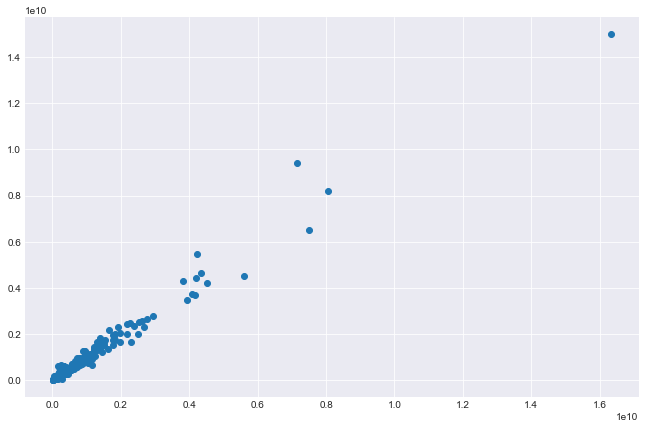

In [18]:
shares_outstanding_calc = df.MarketCapitalization / df.stockPrice
plt.scatter(df['SharesOutstanding'], shares_outstanding_calc)

As we can observe, there is a nearly perfect linear relationship between `MarketCapitalization` and `SharesOutstanding`. Thus, any `MarketCapitalization` related variables need to be left out of the data

In [19]:
df = df.drop(columns=['MarketCapitalization'])

In [20]:
df.info(max_cols=150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 109 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    operatingCashflow                                          499 non-null    object 
 1    paymentsForOperatingActivities                             499 non-null    object 
 2    proceedsFromOperatingActivities                            499 non-null    object 
 3    changeInOperatingLiabilities                               499 non-null    object 
 4    changeInOperatingAssets                                    499 non-null    object 
 5    depreciationDepletionAndAmortization                       499 non-null    object 
 6    capitalExpenditures                                        499 non-null    object 
 7    changeInReceivables                                        499 non-null    object 
 8  

### Ensuring that the dataset is cleaned for further exploratory analysis:

Given that we have many columns and rows of data, we will need to ensure that no fields are filled with `None`, `-`, `NaN` values which will give errors when trying perform exploratory analysis. This is done by iterating through the entire dataset once again to replace any of such value with 0.

In [21]:
# Next thing we need to do is to replace 'None' to 0 
# And also any other str to 0
# This is so that we can convert the object to float64
for column in df:
    df[column] = df[column].replace(['None'], 0)
    df[column] = df[column].replace(['-'], 0)
    df[column] = df[column].replace(['NaN'], 0)
    df[column] = df[column].astype(float)
    df[column] = df[column].fillna(0)  

In [23]:
df.info(max_cols = 150)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 109 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    operatingCashflow                                          499 non-null    float64
 1    paymentsForOperatingActivities                             499 non-null    float64
 2    proceedsFromOperatingActivities                            499 non-null    float64
 3    changeInOperatingLiabilities                               499 non-null    float64
 4    changeInOperatingAssets                                    499 non-null    float64
 5    depreciationDepletionAndAmortization                       499 non-null    float64
 6    capitalExpenditures                                        499 non-null    float64
 7    changeInReceivables                                        499 non-null    float64
 8  

In [24]:
df.tail(n=10)

operatingCashflow  paymentsForOperatingActivities  \
489       2.176000e+09                    9.360000e+08   
490       3.496000e+09                    1.179000e+09   
491      -1.072425e+09                    4.923310e+08   
492       2.189000e+09                    7.880000e+08   
493       5.380000e+08                    2.360000e+08   
494       1.706000e+09                    9.260000e+08   
495       1.069000e+09                    3.070000e+08   
496       1.499200e+09                    3.591000e+08   
497       6.290000e+08                    1.310000e+08   
498       2.213000e+09                    3.280000e+08   

     proceedsFromOperatingActivities  changeInOperatingLiabilities  \
489                              0.0                  1.095000e+09   
490                       40000000.0                 -3.160000e+08   
491                              0.0                 -3.549260e+08   
492                              0.0                  2.000000e+06   
493                              0.0                  7.900000e+07   
494                              0.0                  8.100000e+07   
495                              0.0                  2.070000e+08   
496                              0.0                 -4.680000e+07   
497                              0.0                  1.300000e+07   
498                              0.0                  1.850000e+08   

     changeInOperatingAssets  depreciationDepletionAndAmortization  \
489              880000000.0                          4.940000e+08   
490                2000000.0                          1.721000e+09   
491              -81646000.0                          6.996000e+08   
492              160000000.0                          7.000000e+06   
493              237000000.0                          2.450000e+08   
494               79000000.0                          1.640000e+08   
495              244000000.0                          1.890000e+08   
496               -3700000.0                          1.067400e+09   
497              171000000.0                         -1.400000e+07   
498              528000000.0                          4.480000e+08   

     capitalExpenditures  changeInReceivables  changeInInventory  \
489         5.250000e+08          232000000.0        648000000.0   
490         1.283000e+09            2000000.0         11000000.0   
491         2.901150e+08          -81646000.0         27660000.0   
492         4.244000e+09         -164000000.0        126000000.0   
493         2.080000e+08           70000000.0        167000000.0   
494         2.300000e+08           46000000.0                0.0   
495         5.900000e+07          239000000.0        -18000000.0   
496         1.720000e+08           15100000.0        -18800000.0   
497         2.060000e+08                  0.0                0.0   
498         4.770000e+08          155000000.0        366000000.0   

       profitLoss  ...  QuarterlyRevenueGrowthYOY  EVToRevenue  EVToEBITDA  \
489  1.806000e+09  ...                      0.003        0.681        4.99   
490  1.980000e+08  ...                      0.417        5.370       11.36   
491 -2.326946e+09  ...                      0.000        0.000        0.00   
492  1.597000e+09  ...                      0.535        5.360       65.03   
493  4.270000e+08  ...                      0.258       12.570       37.83   
494  1.575000e+09  ...                     -0.036        3.358       20.97   
495  8.370000e+08  ...                      0.084        7.160       19.78   
496  4.021000e+08  ...                      0.122        4.109       19.93   
497 -3.155000e+09  ...                     -0.023        4.067       18.81   
498  2.034000e+09  ...                     -0.084        0.000        0.00   

      Beta  52WeekHigh  52WeekLow  50DayMovingAverage  200DayMovingAverage  \
489  1.752      250.76     178.81              215.50               219.44   
490  1.316       31.02      21.57               28.43       

---
## Feature Selection: 
Feature selection is the process of reducing the number of input variables when developing a predictive model. We want to reduce the number of fundamental factors to both reduce the computational cost of modeling and to improve the performance of the model.

Our Feature Selection Methods involves passing our data through a pipeline of techniques. The following techniques employed are:

1. `StandardScalar` : Standardises data through transforming the raw data in a way that it has mean as 0 and standard deviation of 1, arranging it in a normal distrubtion for future processing.


2. `KNNImputer` : Identifies and replaces missing values from each column via the k-nearest neighbour (KNN) algorithm to eliminate missing data imputation prior to modeling our prediction task.


3. `GradientBoostingRegressor` : Classification and regressor technique chosen that optimises an arbitrary differentiable loss function, `huber` by generalising other methods. This method is specifically chosen since it is designed to combine attributes from our data known as 'weak learners' into a single strong learner.

---

### Feature Selection Methods:

Import necessary modules employed in Feature Selection

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [27]:
# Extract the Response and Predictors
y = pd.DataFrame(df['stockPrice']).values.ravel()
X = pd.DataFrame(df.drop(columns=['stockPrice']))

# Splitting the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Our Feature Selection Pipeline
Feature selection is the process of reducing the number of input variables when developing a predictive model. We want to reduce the number of fundamental factors to both reduce the computational cost of modeling and to improve the performance of the model.


#### (i) Standardization
Each financial indicator has its own scale. For example, EV / EBITDA can always be higher than returns on assets. So to prevent such scale difference leading to unparalleled weights and unreliable conclusion, we have to first standardize the data. 

#### (ii) Data Imputer
In our current dataset, there are no missing values. But in the case of datasets which have missing values, we will need to complete the misisng values using a data imputer. 

#### (iii) Gradient Boosting Regressor
Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance. This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other. The feature importances are then averaged across all of the the decision trees within the model. We will be using the Gradient Boosting Regressor to achieve this where the loss function is `huber`.

In [28]:
# Creating a Pipeline for feature selection
est = Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(add_indicator=False, weights='distance')),
                ('regressor',GradientBoostingRegressor(loss='huber', 
                                                       learning_rate = 0.02,
                                                       max_depth=2,
                                                       n_estimators=1000, 
                                                       random_state=0,
                                                       subsample=0.7))])

In [29]:
cv_scores = cross_val_score(est, X, y, scoring='r2', cv=5)
cv_scores.mean()

0.8556542413938935

In [30]:
# Fit the train data
est.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.02, loss='huber',
                                           max_depth=2, n_estimators=1000,
                                           random_state=0, subsample=0.7))])

In [31]:
feature_importance = est.steps[2][1].feature_importances_

Text(0.5, 1.0, 'Feature Importance (MDI)')

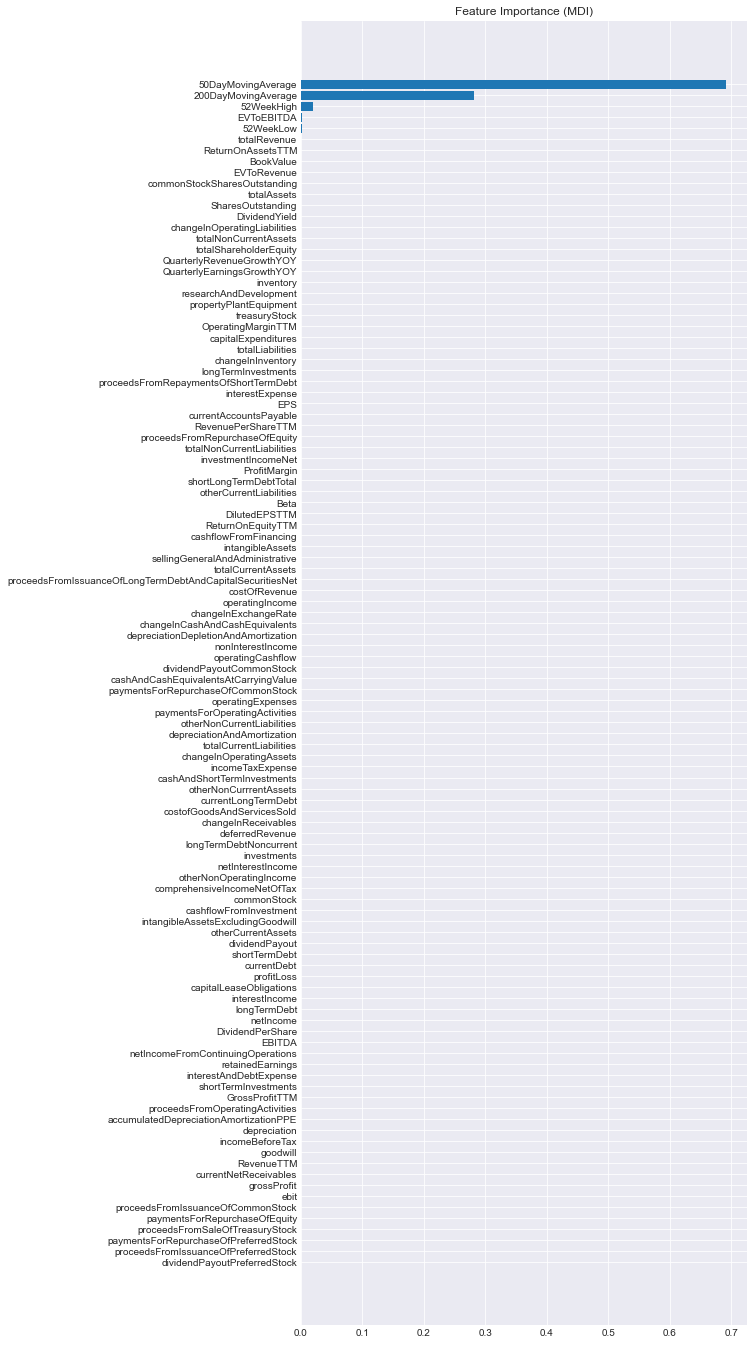

In [32]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 24))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

#### Observation
We can observe that the `50DayMovingAverage`, `200DayMovingAverage`, `52WeekHigh` and `52WeekLow`are the top 4 most important features generated by our algorithm. However, upon closer inspection of the 4 cols, we can observe that the values are actually just data points of the average price based on the respective periods and the highest and low price of the respective periods. This causes target leakage and we should treat it similarly to `MarketCapitalization`.

Let's drop it and re-run the feature selection algorithm.

In [33]:
# Extract the Response and Predictors
y = pd.DataFrame(df['stockPrice']).values.ravel()
X = pd.DataFrame(df.drop(columns=['stockPrice', '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage']))

# Splitting the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
# Creating a Pipeline for feature selection
est = Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(add_indicator=False, weights='distance')),
                ('regressor',GradientBoostingRegressor(loss='huber', 
                                                       learning_rate = 0.02,
                                                       max_depth=2,
                                                       n_estimators=1000, 
                                                       random_state=0,
                                                       subsample=0.7))])

In [35]:
cv_scores = cross_val_score(est, X, y, scoring='r2', cv=5)
cv_scores.mean()

0.558340799651777

In [36]:
# Fit the train data
est.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.02, loss='huber',
                                           max_depth=2, n_estimators=1000,
                                           random_state=0, subsample=0.7))])

In [37]:
feature_importance = est.steps[2][1].feature_importances_

Text(0.5, 1.0, 'Feature Importance (MDI)')

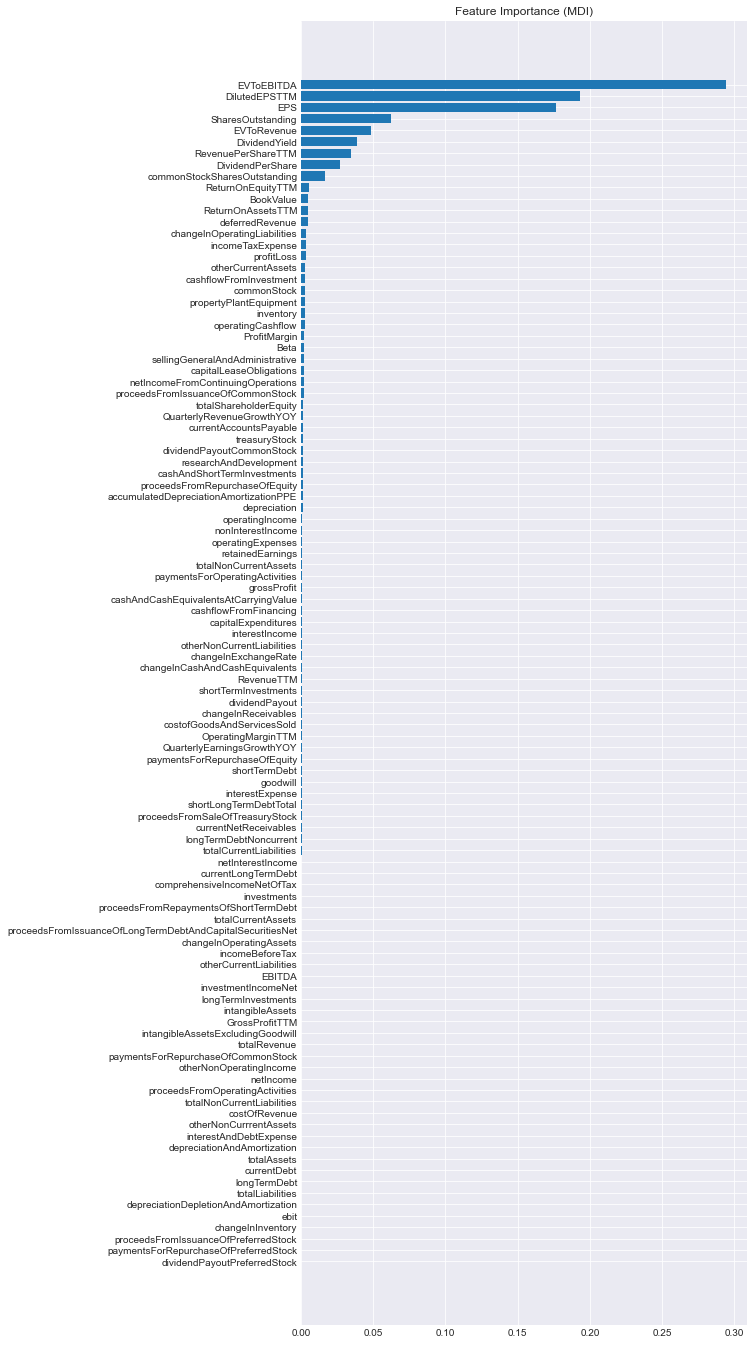

In [38]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 24))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

We can see that the `EVToEBITDA` is the most important feature, with `DilutedEPSTTM` and `EPS`.
These instances can be hard to interpret as these features are highly correlated with each other.

In [39]:
from sklearn.inspection import permutation_importance

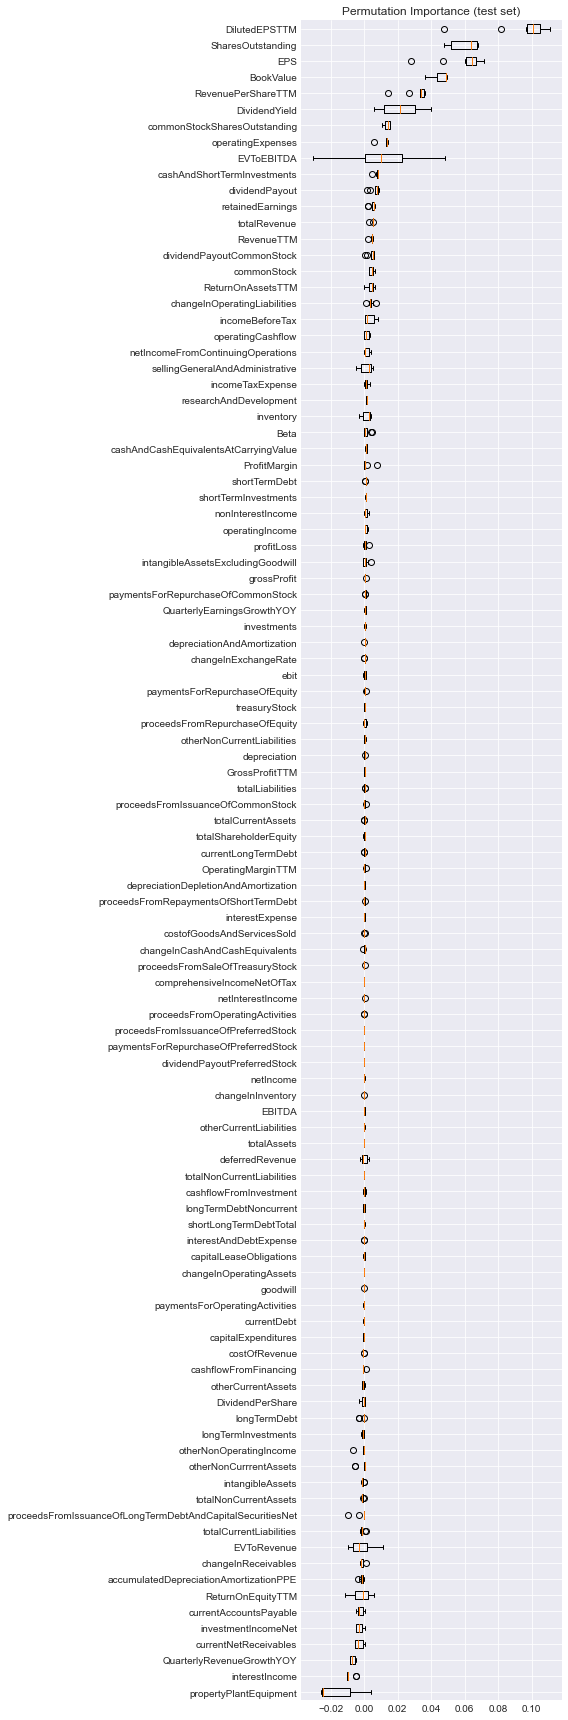

In [40]:
result = permutation_importance(est, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,24))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

Interestingly, we can see that `Book Value` has taken the top spot for being the most important feature whereas `EVToEBITDA` has fallen to the 3rd Spot. This is likely due to the fact that some of the other features may have their actual importance watered down by the fact that they have correlated features present in the feature set

### Let's use GridSearchCV for hyperparameter tuning using Cross-Validation (CV) for GradientBoostingRegressor

In [39]:
from sklearn.model_selection import GridSearchCV

#Define the hyper-parameters Grid to search on, for GradientBoostingRegressor
param_grid = {'learning_rate' : [0.01,0.02,0.03,0.04,0.05],
              'subsample' : [0.9,0.7,0.5,0.4,0.3,0.2,0.1],
              'n_estimators' : np.arange(100,1501,100),
              'max_depth' : [2,4,6,8]}

grid_GBR = GridSearchCV(GradientBoostingRegressor(),
                        param_grid,
                        cv = 5,
                        scoring = 'r2',
                        verbose=10)

# Train the models using CV
grid_GBR.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 2100 candidates, totalling 10500 fits
[CV 1/5; 1/2100] START learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9
[CV 1/5; 1/2100] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=0.198 total time=   0.3s
[CV 2/5; 1/2100] START learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9
[CV 2/5; 1/2100] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=0.257 total time=   0.3s
[CV 3/5; 1/2100] START learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9
[CV 3/5; 1/2100] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=-0.034 total time=   0.3s
[CV 4/5; 1/2100] START learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9
[CV 4/5; 1/2100] END learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=0.090 total time=   0.3s
[CV 5/5; 1/2100] START learning_rate=0.01, max_depth=2, n_estimators=100, subsample=0.9
[CV 5/5; 1/2100] 

[CV 5/5; 8/2100] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.9;, score=0.267 total time=   0.5s
[CV 1/5; 9/2100] START learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7
[CV 1/5; 9/2100] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7;, score=0.297 total time=   0.4s
[CV 2/5; 9/2100] START learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7
[CV 2/5; 9/2100] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7;, score=0.369 total time=   0.4s
[CV 3/5; 9/2100] START learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7
[CV 3/5; 9/2100] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7;, score=-0.372 total time=   0.4s
[CV 4/5; 9/2100] START learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7
[CV 4/5; 9/2100] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7;, score=0.236 total time=   0.4s
[CV 5/5; 9/2100] START learning_rate=0.01, max_depth

[CV 5/5; 16/2100] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.7;, score=0.259 total time=   0.6s
[CV 1/5; 17/2100] START learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5
[CV 1/5; 17/2100] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5;, score=0.391 total time=   0.4s
[CV 2/5; 17/2100] START learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5
[CV 2/5; 17/2100] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5;, score=0.366 total time=   0.4s
[CV 3/5; 17/2100] START learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5
[CV 3/5; 17/2100] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5;, score=-1.327 total time=   0.4s
[CV 4/5; 17/2100] START learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5
[CV 4/5; 17/2100] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5;, score=0.319 total time=   0.4s
[CV 5/5; 17/2100] START learning_rate=0.01,

[CV 5/5; 24/2100] END learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.5;, score=0.231 total time=   0.6s
[CV 1/5; 25/2100] START learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4
[CV 1/5; 25/2100] END learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4;, score=0.437 total time=   0.5s
[CV 2/5; 25/2100] START learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4
[CV 2/5; 25/2100] END learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4;, score=0.372 total time=   0.5s
[CV 3/5; 25/2100] START learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4
[CV 3/5; 25/2100] END learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4;, score=-0.801 total time=   0.5s
[CV 4/5; 25/2100] START learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4
[CV 4/5; 25/2100] END learning_rate=0.01, max_depth=2, n_estimators=400, subsample=0.4;, score=0.333 total time=   0.5s
[CV 5/5; 25/2100] START learning_rate=0.01,

[CV 5/5; 32/2100] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.4;, score=0.280 total time=   0.6s
[CV 1/5; 33/2100] START learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3
[CV 1/5; 33/2100] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3;, score=0.407 total time=   0.4s
[CV 2/5; 33/2100] START learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3
[CV 2/5; 33/2100] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3;, score=0.447 total time=   0.4s
[CV 3/5; 33/2100] START learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3
[CV 3/5; 33/2100] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3;, score=-0.709 total time=   0.4s
[CV 4/5; 33/2100] START learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3
[CV 4/5; 33/2100] END learning_rate=0.01, max_depth=2, n_estimators=500, subsample=0.3;, score=0.345 total time=   0.4s
[CV 5/5; 33/2100] START learning_rate=0.01,

[CV 5/5; 40/2100] END learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.3;, score=0.289 total time=   0.5s
[CV 1/5; 41/2100] START learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2
[CV 1/5; 41/2100] END learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2;, score=0.387 total time=   0.4s
[CV 2/5; 41/2100] START learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2
[CV 2/5; 41/2100] END learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2;, score=0.366 total time=   0.4s
[CV 3/5; 41/2100] START learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2
[CV 3/5; 41/2100] END learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2;, score=-0.634 total time=   0.4s
[CV 4/5; 41/2100] START learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2
[CV 4/5; 41/2100] END learning_rate=0.01, max_depth=2, n_estimators=600, subsample=0.2;, score=0.241 total time=   0.4s
[CV 5/5; 41/2100] START learning_rate=0.01,

[CV 5/5; 48/2100] END learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.2;, score=0.380 total time=   0.4s
[CV 1/5; 49/2100] START learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1
[CV 1/5; 49/2100] END learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1;, score=0.426 total time=   0.2s
[CV 2/5; 49/2100] START learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1
[CV 2/5; 49/2100] END learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1;, score=0.527 total time=   0.2s
[CV 3/5; 49/2100] START learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1
[CV 3/5; 49/2100] END learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1;, score=0.161 total time=   0.2s
[CV 4/5; 49/2100] START learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1
[CV 4/5; 49/2100] END learning_rate=0.01, max_depth=2, n_estimators=700, subsample=0.1;, score=0.289 total time=   0.2s
[CV 5/5; 49/2100] START learning_rate=0.01, 

[CV 5/5; 56/2100] END learning_rate=0.01, max_depth=2, n_estimators=800, subsample=0.1;, score=0.476 total time=   0.3s
[CV 1/5; 57/2100] START learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9
[CV 1/5; 57/2100] END learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9;, score=0.364 total time=   2.3s
[CV 2/5; 57/2100] START learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9
[CV 2/5; 57/2100] END learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9;, score=0.647 total time=   2.3s
[CV 3/5; 57/2100] START learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9
[CV 3/5; 57/2100] END learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9;, score=-0.191 total time=   2.3s
[CV 4/5; 57/2100] START learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9
[CV 4/5; 57/2100] END learning_rate=0.01, max_depth=2, n_estimators=900, subsample=0.9;, score=0.660 total time=   2.3s
[CV 5/5; 57/2100] START learning_rate=0.01,

[CV 5/5; 64/2100] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.9;, score=0.543 total time=   2.6s
[CV 1/5; 65/2100] START learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7
[CV 1/5; 65/2100] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7;, score=0.443 total time=   2.0s
[CV 2/5; 65/2100] START learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7
[CV 2/5; 65/2100] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7;, score=0.591 total time=   2.1s
[CV 3/5; 65/2100] START learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7
[CV 3/5; 65/2100] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7;, score=-0.655 total time=   2.2s
[CV 4/5; 65/2100] START learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7
[CV 4/5; 65/2100] END learning_rate=0.01, max_depth=2, n_estimators=1000, subsample=0.7;, score=0.617 total time=   2.0s
[CV 5/5; 65/2100] START learning_r

[CV 4/5; 72/2100] END learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.7;, score=0.662 total time=   2.2s
[CV 5/5; 72/2100] START learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.7
[CV 5/5; 72/2100] END learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.7;, score=0.423 total time=   2.2s
[CV 1/5; 73/2100] START learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5
[CV 1/5; 73/2100] END learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5;, score=0.428 total time=   1.5s
[CV 2/5; 73/2100] START learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5
[CV 2/5; 73/2100] END learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5;, score=0.600 total time=   1.5s
[CV 3/5; 73/2100] START learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5
[CV 3/5; 73/2100] END learning_rate=0.01, max_depth=2, n_estimators=1100, subsample=0.5;, score=-1.297 total time=   1.6s
[CV 4/5; 73/2100] START learning_r

[CV 3/5; 80/2100] END learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.5;, score=-0.745 total time=   1.7s
[CV 4/5; 80/2100] START learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.5
[CV 4/5; 80/2100] END learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.5;, score=0.585 total time=   1.8s
[CV 5/5; 80/2100] START learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.5
[CV 5/5; 80/2100] END learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.5;, score=0.375 total time=   1.8s
[CV 1/5; 81/2100] START learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.4
[CV 1/5; 81/2100] END learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.4;, score=0.379 total time=   1.4s
[CV 2/5; 81/2100] START learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.4
[CV 2/5; 81/2100] END learning_rate=0.01, max_depth=2, n_estimators=1200, subsample=0.4;, score=0.563 total time=   1.4s
[CV 3/5; 81/2100] START learning_r

[CV 2/5; 88/2100] END learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4;, score=0.578 total time=   1.5s
[CV 3/5; 88/2100] START learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4
[CV 3/5; 88/2100] END learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4;, score=-0.746 total time=   1.5s
[CV 4/5; 88/2100] START learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4
[CV 4/5; 88/2100] END learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4;, score=0.577 total time=   1.5s
[CV 5/5; 88/2100] START learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4
[CV 5/5; 88/2100] END learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.4;, score=0.401 total time=   1.5s
[CV 1/5; 89/2100] START learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.3
[CV 1/5; 89/2100] END learning_rate=0.01, max_depth=2, n_estimators=1300, subsample=0.3;, score=0.430 total time=   1.1s
[CV 2/5; 89/2100] START learning_r

[CV 1/5; 96/2100] END learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3;, score=0.383 total time=   1.2s
[CV 2/5; 96/2100] START learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3
[CV 2/5; 96/2100] END learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3;, score=0.568 total time=   1.2s
[CV 3/5; 96/2100] START learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3
[CV 3/5; 96/2100] END learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3;, score=-1.008 total time=   1.2s
[CV 4/5; 96/2100] START learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3
[CV 4/5; 96/2100] END learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3;, score=0.471 total time=   1.2s
[CV 5/5; 96/2100] START learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3
[CV 5/5; 96/2100] END learning_rate=0.01, max_depth=2, n_estimators=1400, subsample=0.3;, score=0.395 total time=   1.2s
[CV 1/5; 97/2100] START learning_r

[CV 5/5; 103/2100] END learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.3;, score=0.431 total time=   1.4s
[CV 1/5; 104/2100] START learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2
[CV 1/5; 104/2100] END learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2;, score=0.384 total time=   0.9s
[CV 2/5; 104/2100] START learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2
[CV 2/5; 104/2100] END learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2;, score=0.524 total time=   1.1s
[CV 3/5; 104/2100] START learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2
[CV 3/5; 104/2100] END learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2;, score=-0.985 total time=   1.2s
[CV 4/5; 104/2100] START learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2
[CV 4/5; 104/2100] END learning_rate=0.01, max_depth=2, n_estimators=1500, subsample=0.2;, score=0.369 total time=   1.0s
[CV 5/5; 104/2100] START 

[CV 5/5; 111/2100] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.2;, score=0.211 total time=   0.1s
[CV 1/5; 112/2100] START learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1
[CV 1/5; 112/2100] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1;, score=0.181 total time=   0.1s
[CV 2/5; 112/2100] START learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1
[CV 2/5; 112/2100] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1;, score=0.252 total time=   0.1s
[CV 3/5; 112/2100] START learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1
[CV 3/5; 112/2100] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1;, score=0.488 total time=   0.1s
[CV 4/5; 112/2100] START learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1
[CV 4/5; 112/2100] END learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.1;, score=0.243 total time=   0.1s
[CV 5/5; 112/2100] START learning_r

[CV 4/5; 119/2100] END learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.1;, score=0.270 total time=   0.1s
[CV 5/5; 119/2100] START learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.1
[CV 5/5; 119/2100] END learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.1;, score=0.259 total time=   0.1s
[CV 1/5; 120/2100] START learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9
[CV 1/5; 120/2100] END learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9;, score=0.332 total time=   1.4s
[CV 2/5; 120/2100] START learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9
[CV 2/5; 120/2100] END learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9;, score=0.571 total time=   1.5s
[CV 3/5; 120/2100] START learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9
[CV 3/5; 120/2100] END learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9;, score=-0.375 total time=   1.5s
[CV 4/5; 120/2100] START learning_

[CV 3/5; 127/2100] END learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9;, score=-0.353 total time=   2.0s
[CV 4/5; 127/2100] START learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9
[CV 4/5; 127/2100] END learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9;, score=0.580 total time=   2.0s
[CV 5/5; 127/2100] START learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9
[CV 5/5; 127/2100] END learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.9;, score=0.300 total time=   2.0s
[CV 1/5; 128/2100] START learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.7
[CV 1/5; 128/2100] END learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.7;, score=0.434 total time=   1.5s
[CV 2/5; 128/2100] START learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.7
[CV 2/5; 128/2100] END learning_rate=0.01, max_depth=4, n_estimators=400, subsample=0.7;, score=0.593 total time=   1.5s
[CV 3/5; 128/2100] START learning_

[CV 2/5; 135/2100] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7;, score=0.659 total time=   1.9s
[CV 3/5; 135/2100] START learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7
[CV 3/5; 135/2100] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7;, score=-0.829 total time=   1.9s
[CV 4/5; 135/2100] START learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7
[CV 4/5; 135/2100] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7;, score=0.600 total time=   1.9s
[CV 5/5; 135/2100] START learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7
[CV 5/5; 135/2100] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.7;, score=0.297 total time=   1.9s
[CV 1/5; 136/2100] START learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5
[CV 1/5; 136/2100] END learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5;, score=0.390 total time=   1.4s
[CV 2/5; 136/2100] START learning_

[CV 1/5; 143/2100] END learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5;, score=0.424 total time=   1.6s
[CV 2/5; 143/2100] START learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5
[CV 2/5; 143/2100] END learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5;, score=0.569 total time=   1.6s
[CV 3/5; 143/2100] START learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5
[CV 3/5; 143/2100] END learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5;, score=-1.069 total time=   1.6s
[CV 4/5; 143/2100] START learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5
[CV 4/5; 143/2100] END learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5;, score=0.576 total time=   1.6s
[CV 5/5; 143/2100] START learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5
[CV 5/5; 143/2100] END learning_rate=0.01, max_depth=4, n_estimators=600, subsample=0.5;, score=0.321 total time=   1.6s
[CV 1/5; 144/2100] START learning_

[CV 5/5; 150/2100] END learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.5;, score=0.286 total time=   1.9s
[CV 1/5; 151/2100] START learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4
[CV 1/5; 151/2100] END learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4;, score=0.426 total time=   1.5s
[CV 2/5; 151/2100] START learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4
[CV 2/5; 151/2100] END learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4;, score=0.580 total time=   1.5s
[CV 3/5; 151/2100] START learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4
[CV 3/5; 151/2100] END learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4;, score=-1.327 total time=   1.5s
[CV 4/5; 151/2100] START learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4
[CV 4/5; 151/2100] END learning_rate=0.01, max_depth=4, n_estimators=700, subsample=0.4;, score=0.535 total time=   1.5s
[CV 5/5; 151/2100] START learning_

[CV 4/5; 158/2100] END learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.4;, score=0.507 total time=   1.7s
[CV 5/5; 158/2100] START learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.4
[CV 5/5; 158/2100] END learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.4;, score=0.315 total time=   1.7s
[CV 1/5; 159/2100] START learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3
[CV 1/5; 159/2100] END learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3;, score=0.373 total time=   1.2s
[CV 2/5; 159/2100] START learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3
[CV 2/5; 159/2100] END learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3;, score=0.543 total time=   1.2s
[CV 3/5; 159/2100] START learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3
[CV 3/5; 159/2100] END learning_rate=0.01, max_depth=4, n_estimators=800, subsample=0.3;, score=-1.361 total time=   1.3s
[CV 4/5; 159/2100] START learning_

[CV 3/5; 166/2100] END learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.3;, score=-1.265 total time=   1.4s
[CV 4/5; 166/2100] START learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.3
[CV 4/5; 166/2100] END learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.3;, score=0.476 total time=   1.4s
[CV 5/5; 166/2100] START learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.3
[CV 5/5; 166/2100] END learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.3;, score=0.350 total time=   1.4s
[CV 1/5; 167/2100] START learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.2
[CV 1/5; 167/2100] END learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.2;, score=0.379 total time=   0.9s
[CV 2/5; 167/2100] START learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.2
[CV 2/5; 167/2100] END learning_rate=0.01, max_depth=4, n_estimators=900, subsample=0.2;, score=0.507 total time=   0.9s
[CV 3/5; 167/2100] START learning_

[CV 2/5; 174/2100] END learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2;, score=0.485 total time=   1.0s
[CV 3/5; 174/2100] START learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2
[CV 3/5; 174/2100] END learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2;, score=-0.754 total time=   1.0s
[CV 4/5; 174/2100] START learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2
[CV 4/5; 174/2100] END learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2;, score=0.365 total time=   1.0s
[CV 5/5; 174/2100] START learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2
[CV 5/5; 174/2100] END learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.2;, score=0.394 total time=   1.0s
[CV 1/5; 175/2100] START learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1
[CV 1/5; 175/2100] END learning_rate=0.01, max_depth=4, n_estimators=1000, subsample=0.1;, score=0.417 total time=   0.5s
[CV 2/5; 175/2100] START 

[CV 1/5; 182/2100] END learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.371 total time=   0.6s
[CV 2/5; 182/2100] START learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1
[CV 2/5; 182/2100] END learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.451 total time=   0.6s
[CV 3/5; 182/2100] START learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1
[CV 3/5; 182/2100] END learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.309 total time=   0.6s
[CV 4/5; 182/2100] START learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1
[CV 4/5; 182/2100] END learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.463 total time=   0.6s
[CV 5/5; 182/2100] START learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1
[CV 5/5; 182/2100] END learning_rate=0.01, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.494 total time=   0.6s
[CV 1/5; 183/2100] START l

[CV 5/5; 189/2100] END learning_rate=0.01, max_depth=4, n_estimators=1200, subsample=0.1;, score=0.511 total time=   0.7s
[CV 1/5; 190/2100] START learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9
[CV 1/5; 190/2100] END learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9;, score=0.356 total time=   6.2s
[CV 2/5; 190/2100] START learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9
[CV 2/5; 190/2100] END learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9;, score=0.614 total time=   6.2s
[CV 3/5; 190/2100] START learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9
[CV 3/5; 190/2100] END learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9;, score=-0.643 total time=   6.3s
[CV 4/5; 190/2100] START learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9
[CV 4/5; 190/2100] END learning_rate=0.01, max_depth=4, n_estimators=1300, subsample=0.9;, score=0.635 total time=   6.3s
[CV 5/5; 190/2100] START 

[CV 4/5; 197/2100] END learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.9;, score=0.626 total time=   6.7s
[CV 5/5; 197/2100] START learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.9
[CV 5/5; 197/2100] END learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.9;, score=0.313 total time=   6.8s
[CV 1/5; 198/2100] START learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7
[CV 1/5; 198/2100] END learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7;, score=0.419 total time=   5.1s
[CV 2/5; 198/2100] START learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7
[CV 2/5; 198/2100] END learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7;, score=0.678 total time=   5.1s
[CV 3/5; 198/2100] START learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7
[CV 3/5; 198/2100] END learning_rate=0.01, max_depth=4, n_estimators=1400, subsample=0.7;, score=-0.596 total time=   5.1s
[CV 4/5; 198/2100] START 

[CV 3/5; 205/2100] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.7;, score=-0.863 total time=   5.5s
[CV 4/5; 205/2100] START learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.7
[CV 4/5; 205/2100] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.7;, score=0.671 total time=   5.5s
[CV 5/5; 205/2100] START learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.7
[CV 5/5; 205/2100] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.7;, score=0.335 total time=   5.5s
[CV 1/5; 206/2100] START learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5
[CV 1/5; 206/2100] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5;, score=0.316 total time=   3.9s
[CV 2/5; 206/2100] START learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5
[CV 2/5; 206/2100] END learning_rate=0.01, max_depth=4, n_estimators=1500, subsample=0.5;, score=0.650 total time=   3.9s
[CV 3/5; 206/2100] START 

[CV 2/5; 213/2100] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5;, score=0.419 total time=   0.4s
[CV 3/5; 213/2100] START learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5
[CV 3/5; 213/2100] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5;, score=0.399 total time=   0.4s
[CV 4/5; 213/2100] START learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5
[CV 4/5; 213/2100] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5;, score=0.354 total time=   0.4s
[CV 5/5; 213/2100] START learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5
[CV 5/5; 213/2100] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5;, score=0.143 total time=   0.4s
[CV 1/5; 214/2100] START learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.4
[CV 1/5; 214/2100] END learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.4;, score=0.299 total time=   0.3s
[CV 2/5; 214/2100] START learning_r

[CV 1/5; 221/2100] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4;, score=0.336 total time=   0.6s
[CV 2/5; 221/2100] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4
[CV 2/5; 221/2100] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4;, score=0.381 total time=   0.6s
[CV 3/5; 221/2100] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4
[CV 3/5; 221/2100] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4;, score=-0.280 total time=   0.6s
[CV 4/5; 221/2100] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4
[CV 4/5; 221/2100] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4;, score=0.498 total time=   0.6s
[CV 5/5; 221/2100] START learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4
[CV 5/5; 221/2100] END learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.4;, score=0.242 total time=   0.6s
[CV 1/5; 222/2100] START learning_

[CV 5/5; 228/2100] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.4;, score=0.189 total time=   0.9s
[CV 1/5; 229/2100] START learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3
[CV 1/5; 229/2100] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3;, score=0.423 total time=   0.6s
[CV 2/5; 229/2100] START learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3
[CV 2/5; 229/2100] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3;, score=0.470 total time=   0.6s
[CV 3/5; 229/2100] START learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3
[CV 3/5; 229/2100] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3;, score=-0.802 total time=   0.7s
[CV 4/5; 229/2100] START learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3
[CV 4/5; 229/2100] END learning_rate=0.01, max_depth=6, n_estimators=300, subsample=0.3;, score=0.458 total time=   0.7s
[CV 5/5; 229/2100] START learning_

[CV 4/5; 236/2100] END learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.3;, score=0.459 total time=   0.9s
[CV 5/5; 236/2100] START learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.3
[CV 5/5; 236/2100] END learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.3;, score=0.319 total time=   0.9s
[CV 1/5; 237/2100] START learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2
[CV 1/5; 237/2100] END learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2;, score=0.349 total time=   0.6s
[CV 2/5; 237/2100] START learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2
[CV 2/5; 237/2100] END learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2;, score=0.483 total time=   0.6s
[CV 3/5; 237/2100] START learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2
[CV 3/5; 237/2100] END learning_rate=0.01, max_depth=6, n_estimators=400, subsample=0.2;, score=0.040 total time=   0.6s
[CV 4/5; 237/2100] START learning_r

[CV 3/5; 244/2100] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2;, score=-0.323 total time=   0.7s
[CV 4/5; 244/2100] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2
[CV 4/5; 244/2100] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2;, score=0.449 total time=   0.7s
[CV 5/5; 244/2100] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2
[CV 5/5; 244/2100] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.2;, score=0.370 total time=   0.7s
[CV 1/5; 245/2100] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1
[CV 1/5; 245/2100] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1;, score=0.388 total time=   0.3s
[CV 2/5; 245/2100] START learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1
[CV 2/5; 245/2100] END learning_rate=0.01, max_depth=6, n_estimators=500, subsample=0.1;, score=0.512 total time=   0.3s
[CV 3/5; 245/2100] START learning_

[CV 2/5; 252/2100] END learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1;, score=0.440 total time=   0.4s
[CV 3/5; 252/2100] START learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1
[CV 3/5; 252/2100] END learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1;, score=0.293 total time=   0.4s
[CV 4/5; 252/2100] START learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1
[CV 4/5; 252/2100] END learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1;, score=0.250 total time=   0.4s
[CV 5/5; 252/2100] START learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1
[CV 5/5; 252/2100] END learning_rate=0.01, max_depth=6, n_estimators=600, subsample=0.1;, score=0.418 total time=   0.4s
[CV 1/5; 253/2100] START learning_rate=0.01, max_depth=6, n_estimators=700, subsample=0.9
[CV 1/5; 253/2100] END learning_rate=0.01, max_depth=6, n_estimators=700, subsample=0.9;, score=0.340 total time=   4.7s
[CV 2/5; 253/2100] START learning_r

[CV 1/5; 260/2100] END learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9;, score=0.362 total time=   5.4s
[CV 2/5; 260/2100] START learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9
[CV 2/5; 260/2100] END learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9;, score=0.574 total time=   5.5s
[CV 3/5; 260/2100] START learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9
[CV 3/5; 260/2100] END learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9;, score=-0.625 total time=   5.5s
[CV 4/5; 260/2100] START learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9
[CV 4/5; 260/2100] END learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9;, score=0.545 total time=   5.6s
[CV 5/5; 260/2100] START learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9
[CV 5/5; 260/2100] END learning_rate=0.01, max_depth=6, n_estimators=800, subsample=0.9;, score=0.176 total time=   5.6s
[CV 1/5; 261/2100] START learning_

[CV 5/5; 267/2100] END learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.9;, score=0.213 total time=   6.3s
[CV 1/5; 268/2100] START learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7
[CV 1/5; 268/2100] END learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7;, score=0.412 total time=   4.8s
[CV 2/5; 268/2100] START learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7
[CV 2/5; 268/2100] END learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7;, score=0.631 total time=   4.8s
[CV 3/5; 268/2100] START learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7
[CV 3/5; 268/2100] END learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7;, score=-1.012 total time= 1.7min
[CV 4/5; 268/2100] START learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7
[CV 4/5; 268/2100] END learning_rate=0.01, max_depth=6, n_estimators=900, subsample=0.7;, score=0.609 total time=   5.2s
[CV 5/5; 268/2100] START learning_

[CV 4/5; 275/2100] END learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.603 total time=   5.3s
[CV 5/5; 275/2100] START learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.7
[CV 5/5; 275/2100] END learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.191 total time=   5.4s
[CV 1/5; 276/2100] START learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5
[CV 1/5; 276/2100] END learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5;, score=0.378 total time=   3.7s
[CV 2/5; 276/2100] START learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5
[CV 2/5; 276/2100] END learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5;, score=0.548 total time=   3.8s
[CV 3/5; 276/2100] START learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5
[CV 3/5; 276/2100] END learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.5;, score=-1.405 total time=   3.8s
[CV 4/5; 276/2100] START 

[CV 3/5; 283/2100] END learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.5;, score=-0.907 total time=   4.2s
[CV 4/5; 283/2100] START learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.5
[CV 4/5; 283/2100] END learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.5;, score=0.591 total time=   4.1s
[CV 5/5; 283/2100] START learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.5
[CV 5/5; 283/2100] END learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.5;, score=0.221 total time=   4.2s
[CV 1/5; 284/2100] START learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.4
[CV 1/5; 284/2100] END learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.4;, score=0.384 total time=   3.3s
[CV 2/5; 284/2100] START learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.4
[CV 2/5; 284/2100] END learning_rate=0.01, max_depth=6, n_estimators=1100, subsample=0.4;, score=0.545 total time=   3.3s
[CV 3/5; 284/2100] START 

[CV 2/5; 291/2100] END learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4;, score=0.559 total time=   3.6s
[CV 3/5; 291/2100] START learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4
[CV 3/5; 291/2100] END learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4;, score=-1.645 total time=   3.7s
[CV 4/5; 291/2100] START learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4
[CV 4/5; 291/2100] END learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4;, score=0.565 total time=   3.7s
[CV 5/5; 291/2100] START learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4
[CV 5/5; 291/2100] END learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.4;, score=0.229 total time=   3.6s
[CV 1/5; 292/2100] START learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.3
[CV 1/5; 292/2100] END learning_rate=0.01, max_depth=6, n_estimators=1200, subsample=0.3;, score=0.356 total time=   2.6s
[CV 2/5; 292/2100] START 

[CV 1/5; 299/2100] END learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3;, score=0.358 total time=   2.8s
[CV 2/5; 299/2100] START learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3
[CV 2/5; 299/2100] END learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3;, score=0.536 total time=   2.8s
[CV 3/5; 299/2100] START learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3
[CV 3/5; 299/2100] END learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3;, score=-1.577 total time=   2.8s
[CV 4/5; 299/2100] START learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3
[CV 4/5; 299/2100] END learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3;, score=0.470 total time=   2.8s
[CV 5/5; 299/2100] START learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3
[CV 5/5; 299/2100] END learning_rate=0.01, max_depth=6, n_estimators=1300, subsample=0.3;, score=0.268 total time=   2.9s
[CV 1/5; 300/2100] START 

[CV 5/5; 306/2100] END learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.3;, score=0.306 total time=   3.1s
[CV 1/5; 307/2100] START learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2
[CV 1/5; 307/2100] END learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2;, score=0.411 total time=   2.0s
[CV 2/5; 307/2100] START learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2
[CV 2/5; 307/2100] END learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2;, score=0.473 total time=   2.0s
[CV 3/5; 307/2100] START learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2
[CV 3/5; 307/2100] END learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2;, score=-0.956 total time=   2.0s
[CV 4/5; 307/2100] START learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2
[CV 4/5; 307/2100] END learning_rate=0.01, max_depth=6, n_estimators=1400, subsample=0.2;, score=0.393 total time=   2.0s
[CV 5/5; 307/2100] START 

[CV 4/5; 314/2100] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2;, score=0.376 total time=   2.1s
[CV 5/5; 314/2100] START learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2
[CV 5/5; 314/2100] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.2;, score=0.380 total time=   2.1s
[CV 1/5; 315/2100] START learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1
[CV 1/5; 315/2100] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1;, score=0.432 total time=   1.0s
[CV 2/5; 315/2100] START learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1
[CV 2/5; 315/2100] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1;, score=0.415 total time=   1.0s
[CV 3/5; 315/2100] START learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1
[CV 3/5; 315/2100] END learning_rate=0.01, max_depth=6, n_estimators=1500, subsample=0.1;, score=0.004 total time=   1.0s
[CV 4/5; 315/2100] START l

[CV 4/5; 322/2100] END learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1;, score=0.275 total time=   0.1s
[CV 5/5; 322/2100] START learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1
[CV 5/5; 322/2100] END learning_rate=0.01, max_depth=8, n_estimators=100, subsample=0.1;, score=0.241 total time=   0.1s
[CV 1/5; 323/2100] START learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9
[CV 1/5; 323/2100] END learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9;, score=0.313 total time=   1.7s
[CV 2/5; 323/2100] START learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9
[CV 2/5; 323/2100] END learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9;, score=0.521 total time=   1.8s
[CV 3/5; 323/2100] START learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9
[CV 3/5; 323/2100] END learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.9;, score=-0.578 total time=   1.9s
[CV 4/5; 323/2100] START learning_

[CV 3/5; 330/2100] END learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.9;, score=-0.361 total time=   2.7s
[CV 4/5; 330/2100] START learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.9
[CV 4/5; 330/2100] END learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.9;, score=0.495 total time=   2.7s
[CV 5/5; 330/2100] START learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.9
[CV 5/5; 330/2100] END learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.9;, score=0.151 total time=   2.7s
[CV 1/5; 331/2100] START learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.7
[CV 1/5; 331/2100] END learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.7;, score=0.413 total time=   2.0s
[CV 2/5; 331/2100] START learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.7
[CV 2/5; 331/2100] END learning_rate=0.01, max_depth=8, n_estimators=300, subsample=0.7;, score=0.543 total time=   2.1s
[CV 3/5; 331/2100] START learning_

[CV 2/5; 338/2100] END learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7;, score=0.497 total time=   2.8s
[CV 3/5; 338/2100] START learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7
[CV 3/5; 338/2100] END learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7;, score=-1.199 total time=   2.8s
[CV 4/5; 338/2100] START learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7
[CV 4/5; 338/2100] END learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7;, score=0.572 total time=   2.8s
[CV 5/5; 338/2100] START learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7
[CV 5/5; 338/2100] END learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.7;, score=0.117 total time=   2.8s
[CV 1/5; 339/2100] START learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.5
[CV 1/5; 339/2100] END learning_rate=0.01, max_depth=8, n_estimators=400, subsample=0.5;, score=0.408 total time=   1.9s
[CV 2/5; 339/2100] START learning_

[CV 1/5; 346/2100] END learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5;, score=0.408 total time=   2.4s
[CV 2/5; 346/2100] START learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5
[CV 2/5; 346/2100] END learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5;, score=0.493 total time=   2.4s
[CV 3/5; 346/2100] START learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5
[CV 3/5; 346/2100] END learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5;, score=-1.204 total time=   2.4s
[CV 4/5; 346/2100] START learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5
[CV 4/5; 346/2100] END learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5;, score=0.555 total time=   2.4s
[CV 5/5; 346/2100] START learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5
[CV 5/5; 346/2100] END learning_rate=0.01, max_depth=8, n_estimators=500, subsample=0.5;, score=0.153 total time=   2.4s
[CV 1/5; 347/2100] START learning_

[CV 5/5; 353/2100] END learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.5;, score=0.196 total time=   2.9s
[CV 1/5; 354/2100] START learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4
[CV 1/5; 354/2100] END learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4;, score=0.365 total time=   2.3s
[CV 2/5; 354/2100] START learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4
[CV 2/5; 354/2100] END learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4;, score=0.458 total time=   2.3s
[CV 3/5; 354/2100] START learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4
[CV 3/5; 354/2100] END learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4;, score=-0.986 total time=   2.3s
[CV 4/5; 354/2100] START learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4
[CV 4/5; 354/2100] END learning_rate=0.01, max_depth=8, n_estimators=600, subsample=0.4;, score=0.557 total time=   2.3s
[CV 5/5; 354/2100] START learning_

[CV 4/5; 361/2100] END learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.4;, score=0.554 total time=   2.7s
[CV 5/5; 361/2100] START learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.4
[CV 5/5; 361/2100] END learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.4;, score=0.234 total time=   2.8s
[CV 1/5; 362/2100] START learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3
[CV 1/5; 362/2100] END learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3;, score=0.356 total time=   2.1s
[CV 2/5; 362/2100] START learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3
[CV 2/5; 362/2100] END learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3;, score=0.480 total time=   2.0s
[CV 3/5; 362/2100] START learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3
[CV 3/5; 362/2100] END learning_rate=0.01, max_depth=8, n_estimators=700, subsample=0.3;, score=-1.429 total time=   2.0s
[CV 4/5; 362/2100] START learning_

[CV 3/5; 369/2100] END learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.3;, score=-1.099 total time=   2.2s
[CV 4/5; 369/2100] START learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.3
[CV 4/5; 369/2100] END learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.3;, score=0.503 total time=   2.2s
[CV 5/5; 369/2100] START learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.3
[CV 5/5; 369/2100] END learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.3;, score=0.328 total time=   2.2s
[CV 1/5; 370/2100] START learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.2
[CV 1/5; 370/2100] END learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.2;, score=0.367 total time=   1.4s
[CV 2/5; 370/2100] START learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.2
[CV 2/5; 370/2100] END learning_rate=0.01, max_depth=8, n_estimators=800, subsample=0.2;, score=0.426 total time=   1.4s
[CV 3/5; 370/2100] START learning_

[CV 2/5; 377/2100] END learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2;, score=0.473 total time=   1.6s
[CV 3/5; 377/2100] START learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2
[CV 3/5; 377/2100] END learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2;, score=-0.418 total time=   1.6s
[CV 4/5; 377/2100] START learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2
[CV 4/5; 377/2100] END learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2;, score=0.403 total time=   1.6s
[CV 5/5; 377/2100] START learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2
[CV 5/5; 377/2100] END learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.2;, score=0.362 total time=   1.6s
[CV 1/5; 378/2100] START learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.1
[CV 1/5; 378/2100] END learning_rate=0.01, max_depth=8, n_estimators=900, subsample=0.1;, score=0.427 total time=   0.7s
[CV 2/5; 378/2100] START learning_

[CV 1/5; 385/2100] END learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.372 total time=   0.8s
[CV 2/5; 385/2100] START learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1
[CV 2/5; 385/2100] END learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.542 total time=   0.8s
[CV 3/5; 385/2100] START learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1
[CV 3/5; 385/2100] END learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.108 total time=   0.8s
[CV 4/5; 385/2100] START learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1
[CV 4/5; 385/2100] END learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.378 total time=   0.8s
[CV 5/5; 385/2100] START learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1
[CV 5/5; 385/2100] END learning_rate=0.01, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.442 total time=   0.8s
[CV 1/5; 386/2100] START l

[CV 5/5; 392/2100] END learning_rate=0.01, max_depth=8, n_estimators=1100, subsample=0.1;, score=0.535 total time=   0.9s
[CV 1/5; 393/2100] START learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9
[CV 1/5; 393/2100] END learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.384 total time=  10.5s
[CV 2/5; 393/2100] START learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9
[CV 2/5; 393/2100] END learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.452 total time=  10.7s
[CV 3/5; 393/2100] START learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9
[CV 3/5; 393/2100] END learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9;, score=-1.041 total time=  10.8s
[CV 4/5; 393/2100] START learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9
[CV 4/5; 393/2100] END learning_rate=0.01, max_depth=8, n_estimators=1200, subsample=0.9;, score=0.512 total time=  10.8s
[CV 5/5; 393/2100] START 

[CV 4/5; 400/2100] END learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.9;, score=0.520 total time=  11.5s
[CV 5/5; 400/2100] START learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.9
[CV 5/5; 400/2100] END learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.9;, score=0.142 total time=31.8min
[CV 1/5; 401/2100] START learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7
[CV 1/5; 401/2100] END learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7;, score=0.469 total time=   9.2s
[CV 2/5; 401/2100] START learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7
[CV 2/5; 401/2100] END learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7;, score=0.609 total time=   8.9s
[CV 3/5; 401/2100] START learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7
[CV 3/5; 401/2100] END learning_rate=0.01, max_depth=8, n_estimators=1300, subsample=0.7;, score=-1.196 total time=   9.0s
[CV 4/5; 401/2100] START 

[CV 3/5; 408/2100] END learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.7;, score=-0.617 total time=   9.6s
[CV 4/5; 408/2100] START learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.7
[CV 4/5; 408/2100] END learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.7;, score=0.558 total time=   9.5s
[CV 5/5; 408/2100] START learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.7
[CV 5/5; 408/2100] END learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.7;, score=0.133 total time=   9.6s
[CV 1/5; 409/2100] START learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.5
[CV 1/5; 409/2100] END learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.5;, score=0.424 total time=   6.7s
[CV 2/5; 409/2100] START learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.5
[CV 2/5; 409/2100] END learning_rate=0.01, max_depth=8, n_estimators=1400, subsample=0.5;, score=0.479 total time=   6.7s
[CV 3/5; 409/2100] START 

[CV 2/5; 416/2100] END learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5;, score=0.518 total time=   7.2s
[CV 3/5; 416/2100] START learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5
[CV 3/5; 416/2100] END learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5;, score=-1.404 total time=   7.2s
[CV 4/5; 416/2100] START learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5
[CV 4/5; 416/2100] END learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5;, score=0.583 total time=   7.2s
[CV 5/5; 416/2100] START learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5
[CV 5/5; 416/2100] END learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.5;, score=0.167 total time=   7.2s
[CV 1/5; 417/2100] START learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.4
[CV 1/5; 417/2100] END learning_rate=0.01, max_depth=8, n_estimators=1500, subsample=0.4;, score=0.376 total time=   5.7s
[CV 2/5; 417/2100] START 

[CV 2/5; 424/2100] END learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4;, score=0.317 total time=   0.1s
[CV 3/5; 424/2100] START learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4
[CV 3/5; 424/2100] END learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4;, score=-0.495 total time=   0.1s
[CV 4/5; 424/2100] START learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4
[CV 4/5; 424/2100] END learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4;, score=0.270 total time=   0.1s
[CV 5/5; 424/2100] START learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4
[CV 5/5; 424/2100] END learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.4;, score=0.200 total time=   0.1s
[CV 1/5; 425/2100] START learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.3
[CV 1/5; 425/2100] END learning_rate=0.02, max_depth=2, n_estimators=100, subsample=0.3;, score=0.373 total time=   0.1s
[CV 2/5; 425/2100] START learning_

[CV 2/5; 432/2100] END learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3;, score=0.385 total time=   0.2s
[CV 3/5; 432/2100] START learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3
[CV 3/5; 432/2100] END learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3;, score=-0.625 total time=   0.2s
[CV 4/5; 432/2100] START learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3
[CV 4/5; 432/2100] END learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3;, score=0.249 total time=   0.2s
[CV 5/5; 432/2100] START learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3
[CV 5/5; 432/2100] END learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.3;, score=0.242 total time=   0.2s
[CV 1/5; 433/2100] START learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.2
[CV 1/5; 433/2100] END learning_rate=0.02, max_depth=2, n_estimators=200, subsample=0.2;, score=0.356 total time=   0.1s
[CV 2/5; 433/2100] START learning_

[CV 2/5; 440/2100] END learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2;, score=0.418 total time=   0.2s
[CV 3/5; 440/2100] START learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2
[CV 3/5; 440/2100] END learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2;, score=-0.263 total time=   0.2s
[CV 4/5; 440/2100] START learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2
[CV 4/5; 440/2100] END learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2;, score=0.296 total time=   0.2s
[CV 5/5; 440/2100] START learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2
[CV 5/5; 440/2100] END learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.2;, score=0.345 total time=   0.2s
[CV 1/5; 441/2100] START learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.1
[CV 1/5; 441/2100] END learning_rate=0.02, max_depth=2, n_estimators=300, subsample=0.1;, score=0.428 total time=   0.1s
[CV 2/5; 441/2100] START learning_

[CV 2/5; 448/2100] END learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1;, score=0.552 total time=   0.1s
[CV 3/5; 448/2100] START learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1
[CV 3/5; 448/2100] END learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1;, score=0.190 total time=   0.1s
[CV 4/5; 448/2100] START learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1
[CV 4/5; 448/2100] END learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1;, score=0.282 total time=   0.1s
[CV 5/5; 448/2100] START learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1
[CV 5/5; 448/2100] END learning_rate=0.02, max_depth=2, n_estimators=400, subsample=0.1;, score=0.446 total time=   0.1s
[CV 1/5; 449/2100] START learning_rate=0.02, max_depth=2, n_estimators=500, subsample=0.9
[CV 1/5; 449/2100] END learning_rate=0.02, max_depth=2, n_estimators=500, subsample=0.9;, score=0.370 total time=   1.3s
[CV 2/5; 449/2100] START learning_r

[CV 1/5; 456/2100] END learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9;, score=0.380 total time=   1.5s
[CV 2/5; 456/2100] START learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9
[CV 2/5; 456/2100] END learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9;, score=0.624 total time=   1.6s
[CV 3/5; 456/2100] START learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9
[CV 3/5; 456/2100] END learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9;, score=-0.410 total time=   1.5s
[CV 4/5; 456/2100] START learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9
[CV 4/5; 456/2100] END learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9;, score=0.678 total time=   1.5s
[CV 5/5; 456/2100] START learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9
[CV 5/5; 456/2100] END learning_rate=0.02, max_depth=2, n_estimators=600, subsample=0.9;, score=0.506 total time=   1.6s
[CV 1/5; 457/2100] START learning_

[CV 5/5; 463/2100] END learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.9;, score=0.513 total time=   1.8s
[CV 1/5; 464/2100] START learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7
[CV 1/5; 464/2100] END learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7;, score=0.400 total time=   1.4s
[CV 2/5; 464/2100] START learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7
[CV 2/5; 464/2100] END learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7;, score=0.592 total time=   1.4s
[CV 3/5; 464/2100] START learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7
[CV 3/5; 464/2100] END learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7;, score=-0.931 total time=   1.4s
[CV 4/5; 464/2100] START learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7
[CV 4/5; 464/2100] END learning_rate=0.02, max_depth=2, n_estimators=700, subsample=0.7;, score=0.664 total time=   1.4s
[CV 5/5; 464/2100] START learning_

[CV 4/5; 471/2100] END learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.7;, score=0.668 total time=   1.6s
[CV 5/5; 471/2100] START learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.7
[CV 5/5; 471/2100] END learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.7;, score=0.460 total time=   1.6s
[CV 1/5; 472/2100] START learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5
[CV 1/5; 472/2100] END learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5;, score=0.387 total time=   1.1s
[CV 2/5; 472/2100] START learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5
[CV 2/5; 472/2100] END learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5;, score=0.624 total time=   1.1s
[CV 3/5; 472/2100] START learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5
[CV 3/5; 472/2100] END learning_rate=0.02, max_depth=2, n_estimators=800, subsample=0.5;, score=-0.756 total time=   1.1s
[CV 4/5; 472/2100] START learning_

[CV 3/5; 479/2100] END learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.5;, score=-0.953 total time=   1.3s
[CV 4/5; 479/2100] START learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.5
[CV 4/5; 479/2100] END learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.5;, score=0.597 total time=   1.3s
[CV 5/5; 479/2100] START learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.5
[CV 5/5; 479/2100] END learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.5;, score=0.411 total time=   1.3s
[CV 1/5; 480/2100] START learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.4
[CV 1/5; 480/2100] END learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.4;, score=0.470 total time=   1.0s
[CV 2/5; 480/2100] START learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.4
[CV 2/5; 480/2100] END learning_rate=0.02, max_depth=2, n_estimators=900, subsample=0.4;, score=0.620 total time=   1.0s
[CV 3/5; 480/2100] START learning_

[CV 2/5; 487/2100] END learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4;, score=0.576 total time=   1.1s
[CV 3/5; 487/2100] START learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4
[CV 3/5; 487/2100] END learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4;, score=-1.067 total time=   1.1s
[CV 4/5; 487/2100] START learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4
[CV 4/5; 487/2100] END learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4;, score=0.548 total time=   1.1s
[CV 5/5; 487/2100] START learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4
[CV 5/5; 487/2100] END learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.4;, score=0.374 total time=   1.2s
[CV 1/5; 488/2100] START learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.3
[CV 1/5; 488/2100] END learning_rate=0.02, max_depth=2, n_estimators=1000, subsample=0.3;, score=0.429 total time=   0.9s
[CV 2/5; 488/2100] START 

[CV 1/5; 495/2100] END learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3;, score=0.386 total time=   0.9s
[CV 2/5; 495/2100] START learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3
[CV 2/5; 495/2100] END learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3;, score=0.510 total time=   1.0s
[CV 3/5; 495/2100] START learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3
[CV 3/5; 495/2100] END learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3;, score=-1.162 total time=   0.9s
[CV 4/5; 495/2100] START learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3
[CV 4/5; 495/2100] END learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3;, score=0.443 total time=   1.0s
[CV 5/5; 495/2100] START learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3
[CV 5/5; 495/2100] END learning_rate=0.02, max_depth=2, n_estimators=1100, subsample=0.3;, score=0.411 total time=   1.0s
[CV 1/5; 496/2100] START 

[CV 5/5; 502/2100] END learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.3;, score=0.433 total time=   1.1s
[CV 1/5; 503/2100] START learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2
[CV 1/5; 503/2100] END learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2;, score=0.375 total time=   0.7s
[CV 2/5; 503/2100] START learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2
[CV 2/5; 503/2100] END learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2;, score=0.589 total time=   0.7s
[CV 3/5; 503/2100] START learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2
[CV 3/5; 503/2100] END learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2;, score=-0.708 total time=   0.7s
[CV 4/5; 503/2100] START learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2
[CV 4/5; 503/2100] END learning_rate=0.02, max_depth=2, n_estimators=1200, subsample=0.2;, score=0.425 total time=   0.7s
[CV 5/5; 503/2100] START 

[CV 4/5; 510/2100] END learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.2;, score=0.420 total time=   0.8s
[CV 5/5; 510/2100] START learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.2
[CV 5/5; 510/2100] END learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.2;, score=0.426 total time=   0.8s
[CV 1/5; 511/2100] START learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1
[CV 1/5; 511/2100] END learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1;, score=0.365 total time=   0.4s
[CV 2/5; 511/2100] START learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1
[CV 2/5; 511/2100] END learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1;, score=0.446 total time=   0.4s
[CV 3/5; 511/2100] START learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1
[CV 3/5; 511/2100] END learning_rate=0.02, max_depth=2, n_estimators=1300, subsample=0.1;, score=-0.198 total time=   0.4s
[CV 4/5; 511/2100] START 

[CV 3/5; 518/2100] END learning_rate=0.02, max_depth=2, n_estimators=1400, subsample=0.1;, score=-0.385 total time=   0.5s
[CV 4/5; 518/2100] START learning_rate=0.02, max_depth=2, n_estimators=1400, subsample=0.1
[CV 4/5; 518/2100] END learning_rate=0.02, max_depth=2, n_estimators=1400, subsample=0.1;, score=0.160 total time=   0.5s
[CV 5/5; 518/2100] START learning_rate=0.02, max_depth=2, n_estimators=1400, subsample=0.1
[CV 5/5; 518/2100] END learning_rate=0.02, max_depth=2, n_estimators=1400, subsample=0.1;, score=0.506 total time=   0.5s
[CV 1/5; 519/2100] START learning_rate=0.02, max_depth=2, n_estimators=1500, subsample=0.9
[CV 1/5; 519/2100] END learning_rate=0.02, max_depth=2, n_estimators=1500, subsample=0.9;, score=0.414 total time=   3.8s
[CV 2/5; 519/2100] START learning_rate=0.02, max_depth=2, n_estimators=1500, subsample=0.9
[CV 2/5; 519/2100] END learning_rate=0.02, max_depth=2, n_estimators=1500, subsample=0.9;, score=0.702 total time=   3.9s
[CV 3/5; 519/2100] START 

[CV 2/5; 526/2100] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.528 total time=   0.5s
[CV 3/5; 526/2100] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 3/5; 526/2100] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=-0.836 total time=   0.5s
[CV 4/5; 526/2100] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 4/5; 526/2100] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.416 total time=   0.5s
[CV 5/5; 526/2100] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9
[CV 5/5; 526/2100] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.9;, score=0.165 total time=   0.5s
[CV 1/5; 527/2100] START learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.7
[CV 1/5; 527/2100] END learning_rate=0.02, max_depth=4, n_estimators=100, subsample=0.7;, score=0.323 total time=   0.4s
[CV 2/5; 527/2100] START learning_

[CV 1/5; 534/2100] END learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7;, score=0.430 total time=   0.8s
[CV 2/5; 534/2100] START learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7
[CV 2/5; 534/2100] END learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7;, score=0.569 total time=   0.8s
[CV 3/5; 534/2100] START learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7
[CV 3/5; 534/2100] END learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7;, score=-0.588 total time=   0.8s
[CV 4/5; 534/2100] START learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7
[CV 4/5; 534/2100] END learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7;, score=0.566 total time=   0.8s
[CV 5/5; 534/2100] START learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7
[CV 5/5; 534/2100] END learning_rate=0.02, max_depth=4, n_estimators=200, subsample=0.7;, score=0.299 total time=   0.8s
[CV 1/5; 535/2100] START learning_

[CV 5/5; 541/2100] END learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.7;, score=0.260 total time=   1.1s
[CV 1/5; 542/2100] START learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5
[CV 1/5; 542/2100] END learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5;, score=0.450 total time=   0.8s
[CV 2/5; 542/2100] START learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5
[CV 2/5; 542/2100] END learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5;, score=0.543 total time=   0.8s
[CV 3/5; 542/2100] START learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5
[CV 3/5; 542/2100] END learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5;, score=-0.804 total time=   0.8s
[CV 4/5; 542/2100] START learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5
[CV 4/5; 542/2100] END learning_rate=0.02, max_depth=4, n_estimators=300, subsample=0.5;, score=0.563 total time=   0.8s
[CV 5/5; 542/2100] START learning_

[CV 4/5; 549/2100] END learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.5;, score=0.594 total time=   1.1s
[CV 5/5; 549/2100] START learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.5
[CV 5/5; 549/2100] END learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.5;, score=0.313 total time=   1.1s
[CV 1/5; 550/2100] START learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4
[CV 1/5; 550/2100] END learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4;, score=0.338 total time=   0.8s
[CV 2/5; 550/2100] START learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4
[CV 2/5; 550/2100] END learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4;, score=0.577 total time=   0.8s
[CV 3/5; 550/2100] START learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4
[CV 3/5; 550/2100] END learning_rate=0.02, max_depth=4, n_estimators=400, subsample=0.4;, score=-1.114 total time=   0.9s
[CV 4/5; 550/2100] START learning_

[CV 3/5; 557/2100] END learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.4;, score=-1.139 total time=   1.1s
[CV 4/5; 557/2100] START learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.4
[CV 4/5; 557/2100] END learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.4;, score=0.613 total time=   1.1s
[CV 5/5; 557/2100] START learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.4
[CV 5/5; 557/2100] END learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.4;, score=0.308 total time=   1.1s
[CV 1/5; 558/2100] START learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.3
[CV 1/5; 558/2100] END learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.3;, score=0.344 total time=   0.8s
[CV 2/5; 558/2100] START learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.3
[CV 2/5; 558/2100] END learning_rate=0.02, max_depth=4, n_estimators=500, subsample=0.3;, score=0.514 total time=   0.8s
[CV 3/5; 558/2100] START learning_

[CV 2/5; 565/2100] END learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3;, score=0.658 total time=   0.9s
[CV 3/5; 565/2100] START learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3
[CV 3/5; 565/2100] END learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3;, score=-1.114 total time=   0.9s
[CV 4/5; 565/2100] START learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3
[CV 4/5; 565/2100] END learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3;, score=0.518 total time=   0.9s
[CV 5/5; 565/2100] START learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3
[CV 5/5; 565/2100] END learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.3;, score=0.403 total time=   1.0s
[CV 1/5; 566/2100] START learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.2
[CV 1/5; 566/2100] END learning_rate=0.02, max_depth=4, n_estimators=600, subsample=0.2;, score=0.385 total time=   0.6s
[CV 2/5; 566/2100] START learning_

[CV 1/5; 573/2100] END learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2;, score=0.391 total time=   0.7s
[CV 2/5; 573/2100] START learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2
[CV 2/5; 573/2100] END learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2;, score=0.600 total time=   0.7s
[CV 3/5; 573/2100] START learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2
[CV 3/5; 573/2100] END learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2;, score=-0.669 total time=   0.7s
[CV 4/5; 573/2100] START learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2
[CV 4/5; 573/2100] END learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2;, score=0.483 total time=   0.7s
[CV 5/5; 573/2100] START learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2
[CV 5/5; 573/2100] END learning_rate=0.02, max_depth=4, n_estimators=700, subsample=0.2;, score=0.360 total time=   0.7s
[CV 1/5; 574/2100] START learning_

[CV 5/5; 580/2100] END learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.2;, score=0.380 total time=   0.8s
[CV 1/5; 581/2100] START learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1
[CV 1/5; 581/2100] END learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1;, score=0.454 total time=   0.4s
[CV 2/5; 581/2100] START learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1
[CV 2/5; 581/2100] END learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1;, score=0.531 total time=   0.4s
[CV 3/5; 581/2100] START learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1
[CV 3/5; 581/2100] END learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1;, score=-0.091 total time=   0.4s
[CV 4/5; 581/2100] START learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1
[CV 4/5; 581/2100] END learning_rate=0.02, max_depth=4, n_estimators=800, subsample=0.1;, score=0.405 total time=   0.4s
[CV 5/5; 581/2100] START learning_

[CV 4/5; 588/2100] END learning_rate=0.02, max_depth=4, n_estimators=900, subsample=0.1;, score=0.297 total time=   0.5s
[CV 5/5; 588/2100] START learning_rate=0.02, max_depth=4, n_estimators=900, subsample=0.1
[CV 5/5; 588/2100] END learning_rate=0.02, max_depth=4, n_estimators=900, subsample=0.1;, score=0.459 total time=   0.5s
[CV 1/5; 589/2100] START learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9
[CV 1/5; 589/2100] END learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9;, score=0.336 total time=   4.8s
[CV 2/5; 589/2100] START learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9
[CV 2/5; 589/2100] END learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9;, score=0.660 total time=   4.8s
[CV 3/5; 589/2100] START learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9
[CV 3/5; 589/2100] END learning_rate=0.02, max_depth=4, n_estimators=1000, subsample=0.9;, score=-0.649 total time=   4.8s
[CV 4/5; 589/2100] START lea

[CV 3/5; 596/2100] END learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.9;, score=-0.599 total time=   5.3s
[CV 4/5; 596/2100] START learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.9
[CV 4/5; 596/2100] END learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.9;, score=0.650 total time=   5.3s
[CV 5/5; 596/2100] START learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.9
[CV 5/5; 596/2100] END learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.9;, score=0.299 total time=   5.3s
[CV 1/5; 597/2100] START learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.7
[CV 1/5; 597/2100] END learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.7;, score=0.438 total time=   4.0s
[CV 2/5; 597/2100] START learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.7
[CV 2/5; 597/2100] END learning_rate=0.02, max_depth=4, n_estimators=1100, subsample=0.7;, score=0.621 total time=   4.0s
[CV 3/5; 597/2100] START 

[CV 2/5; 604/2100] END learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7;, score=0.640 total time=   4.4s
[CV 3/5; 604/2100] START learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7
[CV 3/5; 604/2100] END learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7;, score=-0.495 total time=   4.4s
[CV 4/5; 604/2100] START learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7
[CV 4/5; 604/2100] END learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7;, score=0.666 total time=   4.4s
[CV 5/5; 604/2100] START learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7
[CV 5/5; 604/2100] END learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.7;, score=0.294 total time=   4.4s
[CV 1/5; 605/2100] START learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.5
[CV 1/5; 605/2100] END learning_rate=0.02, max_depth=4, n_estimators=1200, subsample=0.5;, score=0.423 total time=   3.1s
[CV 2/5; 605/2100] START 

[CV 1/5; 612/2100] END learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5;, score=0.443 total time=   3.5s
[CV 2/5; 612/2100] START learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5
[CV 2/5; 612/2100] END learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5;, score=0.589 total time=   3.3s
[CV 3/5; 612/2100] START learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5
[CV 3/5; 612/2100] END learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5;, score=-0.731 total time=   3.3s
[CV 4/5; 612/2100] START learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5
[CV 4/5; 612/2100] END learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5;, score=0.642 total time=   3.4s
[CV 5/5; 612/2100] START learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5
[CV 5/5; 612/2100] END learning_rate=0.02, max_depth=4, n_estimators=1300, subsample=0.5;, score=0.316 total time=   3.5s
[CV 1/5; 613/2100] START 

[CV 5/5; 619/2100] END learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.5;, score=0.326 total time=   3.6s
[CV 1/5; 620/2100] START learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4
[CV 1/5; 620/2100] END learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4;, score=0.340 total time=   2.9s
[CV 2/5; 620/2100] START learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4
[CV 2/5; 620/2100] END learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4;, score=0.643 total time=   2.9s
[CV 3/5; 620/2100] START learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4
[CV 3/5; 620/2100] END learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4;, score=-0.850 total time=   2.9s
[CV 4/5; 620/2100] START learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4
[CV 4/5; 620/2100] END learning_rate=0.02, max_depth=4, n_estimators=1400, subsample=0.4;, score=0.549 total time=   2.9s
[CV 5/5; 620/2100] START 

[CV 4/5; 627/2100] END learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.4;, score=0.602 total time=   3.1s
[CV 5/5; 627/2100] START learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.4
[CV 5/5; 627/2100] END learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.4;, score=0.299 total time=   3.3s
[CV 1/5; 628/2100] START learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3
[CV 1/5; 628/2100] END learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3;, score=0.332 total time=   2.3s
[CV 2/5; 628/2100] START learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3
[CV 2/5; 628/2100] END learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3;, score=0.546 total time=   2.3s
[CV 3/5; 628/2100] START learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3
[CV 3/5; 628/2100] END learning_rate=0.02, max_depth=4, n_estimators=1500, subsample=0.3;, score=-1.120 total time=   2.3s
[CV 4/5; 628/2100] START 

[CV 3/5; 635/2100] END learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.3;, score=0.051 total time=   0.2s
[CV 4/5; 635/2100] START learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.3
[CV 4/5; 635/2100] END learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.3;, score=0.503 total time=   0.2s
[CV 5/5; 635/2100] START learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.3
[CV 5/5; 635/2100] END learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.3;, score=0.274 total time=   0.2s
[CV 1/5; 636/2100] START learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2
[CV 1/5; 636/2100] END learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2;, score=0.339 total time=   0.1s
[CV 2/5; 636/2100] START learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2
[CV 2/5; 636/2100] END learning_rate=0.02, max_depth=6, n_estimators=100, subsample=0.2;, score=0.457 total time=   0.1s
[CV 3/5; 636/2100] START learning_r

[CV 2/5; 643/2100] END learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2;, score=0.489 total time=   0.3s
[CV 3/5; 643/2100] START learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2
[CV 3/5; 643/2100] END learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2;, score=0.029 total time=   0.3s
[CV 4/5; 643/2100] START learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2
[CV 4/5; 643/2100] END learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2;, score=0.276 total time=   0.3s
[CV 5/5; 643/2100] START learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2
[CV 5/5; 643/2100] END learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.2;, score=0.376 total time=   0.3s
[CV 1/5; 644/2100] START learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.1
[CV 1/5; 644/2100] END learning_rate=0.02, max_depth=6, n_estimators=200, subsample=0.1;, score=0.345 total time=   0.1s
[CV 2/5; 644/2100] START learning_r

[CV 1/5; 651/2100] END learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1;, score=0.389 total time=   0.2s
[CV 2/5; 651/2100] START learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1
[CV 2/5; 651/2100] END learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1;, score=0.464 total time=   0.2s
[CV 3/5; 651/2100] START learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1
[CV 3/5; 651/2100] END learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1;, score=-0.036 total time=   0.2s
[CV 4/5; 651/2100] START learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1
[CV 4/5; 651/2100] END learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1;, score=0.391 total time=   0.2s
[CV 5/5; 651/2100] START learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1
[CV 5/5; 651/2100] END learning_rate=0.02, max_depth=6, n_estimators=300, subsample=0.1;, score=0.485 total time=   0.2s
[CV 1/5; 652/2100] START learning_

[CV 5/5; 658/2100] END learning_rate=0.02, max_depth=6, n_estimators=400, subsample=0.1;, score=0.459 total time=   0.3s
[CV 1/5; 659/2100] START learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9
[CV 1/5; 659/2100] END learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9;, score=0.359 total time=   3.4s
[CV 2/5; 659/2100] START learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9
[CV 2/5; 659/2100] END learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9;, score=0.557 total time=   3.4s
[CV 3/5; 659/2100] START learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9
[CV 3/5; 659/2100] END learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9;, score=-0.781 total time=   3.5s
[CV 4/5; 659/2100] START learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9
[CV 4/5; 659/2100] END learning_rate=0.02, max_depth=6, n_estimators=500, subsample=0.9;, score=0.582 total time=   3.4s
[CV 5/5; 659/2100] START learning_

[CV 4/5; 666/2100] END learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.9;, score=0.540 total time=   4.1s
[CV 5/5; 666/2100] START learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.9
[CV 5/5; 666/2100] END learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.9;, score=0.213 total time=   4.2s
[CV 1/5; 667/2100] START learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7
[CV 1/5; 667/2100] END learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7;, score=0.443 total time=   3.1s
[CV 2/5; 667/2100] START learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7
[CV 2/5; 667/2100] END learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7;, score=0.704 total time=   3.2s
[CV 3/5; 667/2100] START learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7
[CV 3/5; 667/2100] END learning_rate=0.02, max_depth=6, n_estimators=600, subsample=0.7;, score=-1.313 total time=   3.2s
[CV 4/5; 667/2100] START learning_

[CV 3/5; 674/2100] END learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.7;, score=-0.849 total time=   3.7s
[CV 4/5; 674/2100] START learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.7
[CV 4/5; 674/2100] END learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.7;, score=0.607 total time=   3.7s
[CV 5/5; 674/2100] START learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.7
[CV 5/5; 674/2100] END learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.7;, score=0.148 total time=   3.7s
[CV 1/5; 675/2100] START learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.5
[CV 1/5; 675/2100] END learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.5;, score=0.372 total time=   2.6s
[CV 2/5; 675/2100] START learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.5
[CV 2/5; 675/2100] END learning_rate=0.02, max_depth=6, n_estimators=700, subsample=0.5;, score=0.499 total time=   2.6s
[CV 3/5; 675/2100] START learning_

[CV 2/5; 682/2100] END learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5;, score=0.582 total time=   3.0s
[CV 3/5; 682/2100] START learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5
[CV 3/5; 682/2100] END learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5;, score=-0.625 total time=   3.0s
[CV 4/5; 682/2100] START learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5
[CV 4/5; 682/2100] END learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5;, score=0.577 total time=   3.0s
[CV 5/5; 682/2100] START learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5
[CV 5/5; 682/2100] END learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.5;, score=0.201 total time=   3.0s
[CV 1/5; 683/2100] START learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.4
[CV 1/5; 683/2100] END learning_rate=0.02, max_depth=6, n_estimators=800, subsample=0.4;, score=0.332 total time=   2.4s
[CV 2/5; 683/2100] START learning_

[CV 1/5; 690/2100] END learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4;, score=0.431 total time=   2.6s
[CV 2/5; 690/2100] START learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4
[CV 2/5; 690/2100] END learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4;, score=0.490 total time=   2.6s
[CV 3/5; 690/2100] START learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4
[CV 3/5; 690/2100] END learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4;, score=-1.096 total time=   2.6s
[CV 4/5; 690/2100] START learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4
[CV 4/5; 690/2100] END learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4;, score=0.546 total time=   2.6s
[CV 5/5; 690/2100] START learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4
[CV 5/5; 690/2100] END learning_rate=0.02, max_depth=6, n_estimators=900, subsample=0.4;, score=0.214 total time=   2.7s
[CV 1/5; 691/2100] START learning_

[CV 5/5; 697/2100] END learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.4;, score=0.253 total time=   2.9s
[CV 1/5; 698/2100] START learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3
[CV 1/5; 698/2100] END learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3;, score=0.332 total time=   2.2s
[CV 2/5; 698/2100] START learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3
[CV 2/5; 698/2100] END learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3;, score=0.553 total time=   2.2s
[CV 3/5; 698/2100] START learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3
[CV 3/5; 698/2100] END learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3;, score=-1.581 total time=   2.2s
[CV 4/5; 698/2100] START learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3
[CV 4/5; 698/2100] END learning_rate=0.02, max_depth=6, n_estimators=1000, subsample=0.3;, score=0.411 total time=   2.2s
[CV 5/5; 698/2100] START 

[CV 4/5; 705/2100] END learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.3;, score=0.451 total time=   2.4s
[CV 5/5; 705/2100] START learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.3
[CV 5/5; 705/2100] END learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.3;, score=0.257 total time=   2.4s
[CV 1/5; 706/2100] START learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2
[CV 1/5; 706/2100] END learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2;, score=0.357 total time=   1.5s
[CV 2/5; 706/2100] START learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2
[CV 2/5; 706/2100] END learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2;, score=0.508 total time=   1.5s
[CV 3/5; 706/2100] START learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2
[CV 3/5; 706/2100] END learning_rate=0.02, max_depth=6, n_estimators=1100, subsample=0.2;, score=-1.181 total time=   1.5s
[CV 4/5; 706/2100] START 

[CV 3/5; 713/2100] END learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.2;, score=-1.555 total time=   1.7s
[CV 4/5; 713/2100] START learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.2
[CV 4/5; 713/2100] END learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.2;, score=0.407 total time=   1.7s
[CV 5/5; 713/2100] START learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.2
[CV 5/5; 713/2100] END learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.2;, score=0.376 total time=   1.7s
[CV 1/5; 714/2100] START learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.1
[CV 1/5; 714/2100] END learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.1;, score=0.404 total time=   0.9s
[CV 2/5; 714/2100] START learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.1
[CV 2/5; 714/2100] END learning_rate=0.02, max_depth=6, n_estimators=1200, subsample=0.1;, score=0.418 total time=   0.9s
[CV 3/5; 714/2100] START 

[CV 2/5; 721/2100] END learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1;, score=0.434 total time=   0.9s
[CV 3/5; 721/2100] START learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1
[CV 3/5; 721/2100] END learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1;, score=-0.519 total time=   0.9s
[CV 4/5; 721/2100] START learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1
[CV 4/5; 721/2100] END learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1;, score=0.376 total time=   0.9s
[CV 5/5; 721/2100] START learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1
[CV 5/5; 721/2100] END learning_rate=0.02, max_depth=6, n_estimators=1300, subsample=0.1;, score=0.447 total time=   0.9s
[CV 1/5; 722/2100] START learning_rate=0.02, max_depth=6, n_estimators=1400, subsample=0.9
[CV 1/5; 722/2100] END learning_rate=0.02, max_depth=6, n_estimators=1400, subsample=0.9;, score=0.336 total time=   9.8s
[CV 2/5; 722/2100] START 

[CV 1/5; 729/2100] END learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9;, score=0.379 total time=  10.2s
[CV 2/5; 729/2100] START learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9
[CV 2/5; 729/2100] END learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9;, score=0.560 total time=  10.2s
[CV 3/5; 729/2100] START learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9
[CV 3/5; 729/2100] END learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9;, score=-1.113 total time=  10.3s
[CV 4/5; 729/2100] START learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9
[CV 4/5; 729/2100] END learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9;, score=0.572 total time=  10.3s
[CV 5/5; 729/2100] START learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9
[CV 5/5; 729/2100] END learning_rate=0.02, max_depth=6, n_estimators=1500, subsample=0.9;, score=0.183 total time=  10.4s
[CV 1/5; 730/2100] START 

[CV 5/5; 736/2100] END learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.9;, score=0.123 total time=   1.0s
[CV 1/5; 737/2100] START learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7
[CV 1/5; 737/2100] END learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7;, score=0.365 total time=   0.7s
[CV 2/5; 737/2100] START learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7
[CV 2/5; 737/2100] END learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7;, score=0.459 total time=   0.7s
[CV 3/5; 737/2100] START learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7
[CV 3/5; 737/2100] END learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7;, score=-0.301 total time=   0.7s
[CV 4/5; 737/2100] START learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7
[CV 4/5; 737/2100] END learning_rate=0.02, max_depth=8, n_estimators=100, subsample=0.7;, score=0.474 total time=   0.7s
[CV 5/5; 737/2100] START learning_

[CV 4/5; 744/2100] END learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.7;, score=0.537 total time=   1.4s
[CV 5/5; 744/2100] START learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.7
[CV 5/5; 744/2100] END learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.7;, score=0.131 total time=   1.4s
[CV 1/5; 745/2100] START learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5
[CV 1/5; 745/2100] END learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5;, score=0.401 total time=   1.0s
[CV 2/5; 745/2100] START learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5
[CV 2/5; 745/2100] END learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5;, score=0.482 total time=   1.0s
[CV 3/5; 745/2100] START learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5
[CV 3/5; 745/2100] END learning_rate=0.02, max_depth=8, n_estimators=200, subsample=0.5;, score=-1.207 total time=   1.0s
[CV 4/5; 745/2100] START learning_

[CV 3/5; 752/2100] END learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.5;, score=-0.906 total time=   1.5s
[CV 4/5; 752/2100] START learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.5
[CV 4/5; 752/2100] END learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.5;, score=0.562 total time=   1.5s
[CV 5/5; 752/2100] START learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.5
[CV 5/5; 752/2100] END learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.5;, score=0.185 total time=   1.5s
[CV 1/5; 753/2100] START learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.4
[CV 1/5; 753/2100] END learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.4;, score=0.448 total time=   1.2s
[CV 2/5; 753/2100] START learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.4
[CV 2/5; 753/2100] END learning_rate=0.02, max_depth=8, n_estimators=300, subsample=0.4;, score=0.494 total time=   1.1s
[CV 3/5; 753/2100] START learning_

[CV 2/5; 760/2100] END learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4;, score=0.486 total time=   1.5s
[CV 3/5; 760/2100] START learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4
[CV 3/5; 760/2100] END learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4;, score=-1.402 total time=   1.6s
[CV 4/5; 760/2100] START learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4
[CV 4/5; 760/2100] END learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4;, score=0.522 total time=   1.6s
[CV 5/5; 760/2100] START learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4
[CV 5/5; 760/2100] END learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.4;, score=0.206 total time=   1.6s
[CV 1/5; 761/2100] START learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.3
[CV 1/5; 761/2100] END learning_rate=0.02, max_depth=8, n_estimators=400, subsample=0.3;, score=0.365 total time=   1.1s
[CV 2/5; 761/2100] START learning_

[CV 1/5; 768/2100] END learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3;, score=0.396 total time=   1.4s
[CV 2/5; 768/2100] START learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3
[CV 2/5; 768/2100] END learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3;, score=0.513 total time=   1.4s
[CV 3/5; 768/2100] START learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3
[CV 3/5; 768/2100] END learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3;, score=-1.159 total time=   1.4s
[CV 4/5; 768/2100] START learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3
[CV 4/5; 768/2100] END learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3;, score=0.474 total time=   1.4s
[CV 5/5; 768/2100] START learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3
[CV 5/5; 768/2100] END learning_rate=0.02, max_depth=8, n_estimators=500, subsample=0.3;, score=0.230 total time=   1.4s
[CV 1/5; 769/2100] START learning_

[CV 5/5; 775/2100] END learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.3;, score=0.301 total time=   1.7s
[CV 1/5; 776/2100] START learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2
[CV 1/5; 776/2100] END learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2;, score=0.366 total time=   1.1s
[CV 2/5; 776/2100] START learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2
[CV 2/5; 776/2100] END learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2;, score=0.458 total time=   1.0s
[CV 3/5; 776/2100] START learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2
[CV 3/5; 776/2100] END learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2;, score=-0.839 total time=   1.1s
[CV 4/5; 776/2100] START learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2
[CV 4/5; 776/2100] END learning_rate=0.02, max_depth=8, n_estimators=600, subsample=0.2;, score=0.396 total time=   1.1s
[CV 5/5; 776/2100] START learning_

[CV 4/5; 783/2100] END learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.2;, score=0.321 total time=   1.2s
[CV 5/5; 783/2100] START learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.2
[CV 5/5; 783/2100] END learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.2;, score=0.355 total time=   1.3s
[CV 1/5; 784/2100] START learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1
[CV 1/5; 784/2100] END learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1;, score=0.402 total time=   0.5s
[CV 2/5; 784/2100] START learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1
[CV 2/5; 784/2100] END learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1;, score=0.434 total time=   0.5s
[CV 3/5; 784/2100] START learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1
[CV 3/5; 784/2100] END learning_rate=0.02, max_depth=8, n_estimators=700, subsample=0.1;, score=-0.445 total time=   0.5s
[CV 4/5; 784/2100] START learning_

[CV 3/5; 791/2100] END learning_rate=0.02, max_depth=8, n_estimators=800, subsample=0.1;, score=-0.101 total time=   0.6s
[CV 4/5; 791/2100] START learning_rate=0.02, max_depth=8, n_estimators=800, subsample=0.1
[CV 4/5; 791/2100] END learning_rate=0.02, max_depth=8, n_estimators=800, subsample=0.1;, score=0.380 total time=   0.6s
[CV 5/5; 791/2100] START learning_rate=0.02, max_depth=8, n_estimators=800, subsample=0.1
[CV 5/5; 791/2100] END learning_rate=0.02, max_depth=8, n_estimators=800, subsample=0.1;, score=0.490 total time=   0.6s
[CV 1/5; 792/2100] START learning_rate=0.02, max_depth=8, n_estimators=900, subsample=0.9
[CV 1/5; 792/2100] END learning_rate=0.02, max_depth=8, n_estimators=900, subsample=0.9;, score=0.375 total time=   7.8s
[CV 2/5; 792/2100] START learning_rate=0.02, max_depth=8, n_estimators=900, subsample=0.9
[CV 2/5; 792/2100] END learning_rate=0.02, max_depth=8, n_estimators=900, subsample=0.9;, score=0.531 total time=   8.0s
[CV 3/5; 792/2100] START learning_

[CV 2/5; 799/2100] END learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9;, score=0.439 total time=   8.9s
[CV 3/5; 799/2100] START learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9
[CV 3/5; 799/2100] END learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9;, score=-0.744 total time=   8.9s
[CV 4/5; 799/2100] START learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9
[CV 4/5; 799/2100] END learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9;, score=0.510 total time=   9.0s
[CV 5/5; 799/2100] START learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9
[CV 5/5; 799/2100] END learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.9;, score=0.151 total time=   9.1s
[CV 1/5; 800/2100] START learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.7
[CV 1/5; 800/2100] END learning_rate=0.02, max_depth=8, n_estimators=1000, subsample=0.7;, score=0.357 total time=   6.7s
[CV 2/5; 800/2100] START 

[CV 1/5; 807/2100] END learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7;, score=0.369 total time=   7.4s
[CV 2/5; 807/2100] START learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7
[CV 2/5; 807/2100] END learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7;, score=0.612 total time=   7.5s
[CV 3/5; 807/2100] START learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7
[CV 3/5; 807/2100] END learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7;, score=-1.058 total time=   7.6s
[CV 4/5; 807/2100] START learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7
[CV 4/5; 807/2100] END learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7;, score=0.578 total time=   7.5s
[CV 5/5; 807/2100] START learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7
[CV 5/5; 807/2100] END learning_rate=0.02, max_depth=8, n_estimators=1100, subsample=0.7;, score=0.106 total time=   7.6s
[CV 1/5; 808/2100] START 

[CV 5/5; 814/2100] END learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.7;, score=0.178 total time=  11.3s
[CV 1/5; 815/2100] START learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5
[CV 1/5; 815/2100] END learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5;, score=0.353 total time=   8.0s
[CV 2/5; 815/2100] START learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5
[CV 2/5; 815/2100] END learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5;, score=0.417 total time=   7.9s
[CV 3/5; 815/2100] START learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5
[CV 3/5; 815/2100] END learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5;, score=-1.042 total time=   8.0s
[CV 4/5; 815/2100] START learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5
[CV 4/5; 815/2100] END learning_rate=0.02, max_depth=8, n_estimators=1200, subsample=0.5;, score=0.554 total time=   7.9s
[CV 5/5; 815/2100] START 

[CV 4/5; 822/2100] END learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.5;, score=0.503 total time=   8.4s
[CV 5/5; 822/2100] START learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.5
[CV 5/5; 822/2100] END learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.5;, score=0.259 total time=   8.6s
[CV 1/5; 823/2100] START learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4
[CV 1/5; 823/2100] END learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4;, score=0.384 total time=   6.8s
[CV 2/5; 823/2100] START learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4
[CV 2/5; 823/2100] END learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4;, score=0.535 total time=   6.7s
[CV 3/5; 823/2100] START learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4
[CV 3/5; 823/2100] END learning_rate=0.02, max_depth=8, n_estimators=1300, subsample=0.4;, score=-1.241 total time=   6.8s
[CV 4/5; 823/2100] START 

[CV 3/5; 830/2100] END learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.4;, score=-1.394 total time=   7.3s
[CV 4/5; 830/2100] START learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.4
[CV 4/5; 830/2100] END learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.4;, score=0.565 total time=   7.3s
[CV 5/5; 830/2100] START learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.4
[CV 5/5; 830/2100] END learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.4;, score=0.244 total time=   7.3s
[CV 1/5; 831/2100] START learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.3
[CV 1/5; 831/2100] END learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.3;, score=0.350 total time=   5.3s
[CV 2/5; 831/2100] START learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.3
[CV 2/5; 831/2100] END learning_rate=0.02, max_depth=8, n_estimators=1400, subsample=0.3;, score=0.446 total time=   5.3s
[CV 3/5; 831/2100] START 

[CV 2/5; 838/2100] END learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3;, score=0.504 total time=   5.8s
[CV 3/5; 838/2100] START learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3
[CV 3/5; 838/2100] END learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3;, score=-1.296 total time=   5.7s
[CV 4/5; 838/2100] START learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3
[CV 4/5; 838/2100] END learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3;, score=0.447 total time=   5.7s
[CV 5/5; 838/2100] START learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3
[CV 5/5; 838/2100] END learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.3;, score=0.320 total time=   5.7s
[CV 1/5; 839/2100] START learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.2
[CV 1/5; 839/2100] END learning_rate=0.02, max_depth=8, n_estimators=1500, subsample=0.2;, score=0.362 total time=   3.6s
[CV 2/5; 839/2100] START 

[CV 1/5; 846/2100] END learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2;, score=0.363 total time=   0.1s
[CV 2/5; 846/2100] START learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2
[CV 2/5; 846/2100] END learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2;, score=0.338 total time=   0.1s
[CV 3/5; 846/2100] START learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2
[CV 3/5; 846/2100] END learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2;, score=-0.135 total time=   0.1s
[CV 4/5; 846/2100] START learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2
[CV 4/5; 846/2100] END learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2;, score=0.319 total time=   0.1s
[CV 5/5; 846/2100] START learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2
[CV 5/5; 846/2100] END learning_rate=0.03, max_depth=2, n_estimators=100, subsample=0.2;, score=0.275 total time=   0.1s
[CV 1/5; 847/2100] START learning_

[CV 1/5; 854/2100] END learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1;, score=0.414 total time=   0.1s
[CV 2/5; 854/2100] START learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1
[CV 2/5; 854/2100] END learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1;, score=0.322 total time=   0.1s
[CV 3/5; 854/2100] START learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1
[CV 3/5; 854/2100] END learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1;, score=0.242 total time=   0.1s
[CV 4/5; 854/2100] START learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1
[CV 4/5; 854/2100] END learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1;, score=0.250 total time=   0.1s
[CV 5/5; 854/2100] START learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1
[CV 5/5; 854/2100] END learning_rate=0.03, max_depth=2, n_estimators=200, subsample=0.1;, score=0.387 total time=   0.1s
[CV 1/5; 855/2100] START learning_r

[CV 1/5; 862/2100] END learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9;, score=0.353 total time=   1.5s
[CV 2/5; 862/2100] START learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9
[CV 2/5; 862/2100] END learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9;, score=0.642 total time=   1.4s
[CV 3/5; 862/2100] START learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9
[CV 3/5; 862/2100] END learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9;, score=-0.418 total time=   1.4s
[CV 4/5; 862/2100] START learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9
[CV 4/5; 862/2100] END learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9;, score=0.681 total time=   1.4s
[CV 5/5; 862/2100] START learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9
[CV 5/5; 862/2100] END learning_rate=0.03, max_depth=2, n_estimators=400, subsample=0.9;, score=0.513 total time=   1.4s
[CV 1/5; 863/2100] START learning_

[CV 5/5; 869/2100] END learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.9;, score=0.595 total time=   1.8s
[CV 1/5; 870/2100] START learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7
[CV 1/5; 870/2100] END learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7;, score=0.417 total time=   1.4s
[CV 2/5; 870/2100] START learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7
[CV 2/5; 870/2100] END learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7;, score=0.610 total time=   1.4s
[CV 3/5; 870/2100] START learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7
[CV 3/5; 870/2100] END learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7;, score=-0.756 total time=   1.4s
[CV 4/5; 870/2100] START learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7
[CV 4/5; 870/2100] END learning_rate=0.03, max_depth=2, n_estimators=500, subsample=0.7;, score=0.666 total time=   1.4s
[CV 5/5; 870/2100] START learning_

[CV 4/5; 877/2100] END learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.7;, score=0.670 total time=   1.7s
[CV 5/5; 877/2100] START learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.7
[CV 5/5; 877/2100] END learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.7;, score=0.424 total time=   1.7s
[CV 1/5; 878/2100] START learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5
[CV 1/5; 878/2100] END learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5;, score=0.467 total time=   1.2s
[CV 2/5; 878/2100] START learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5
[CV 2/5; 878/2100] END learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5;, score=0.580 total time=   1.2s
[CV 3/5; 878/2100] START learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5
[CV 3/5; 878/2100] END learning_rate=0.03, max_depth=2, n_estimators=600, subsample=0.5;, score=-0.917 total time=   1.2s
[CV 4/5; 878/2100] START learning_

[CV 3/5; 885/2100] END learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.5;, score=-1.128 total time=   1.4s
[CV 4/5; 885/2100] START learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.5
[CV 4/5; 885/2100] END learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.5;, score=0.637 total time=   1.4s
[CV 5/5; 885/2100] START learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.5
[CV 5/5; 885/2100] END learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.5;, score=0.417 total time=   1.4s
[CV 1/5; 886/2100] START learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.4
[CV 1/5; 886/2100] END learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.4;, score=0.384 total time=   1.1s
[CV 2/5; 886/2100] START learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.4
[CV 2/5; 886/2100] END learning_rate=0.03, max_depth=2, n_estimators=700, subsample=0.4;, score=0.521 total time=   1.1s
[CV 3/5; 886/2100] START learning_

[CV 2/5; 893/2100] END learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4;, score=0.541 total time=   1.3s
[CV 3/5; 893/2100] START learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4
[CV 3/5; 893/2100] END learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4;, score=-0.827 total time=   1.3s
[CV 4/5; 893/2100] START learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4
[CV 4/5; 893/2100] END learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4;, score=0.591 total time=   1.3s
[CV 5/5; 893/2100] START learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4
[CV 5/5; 893/2100] END learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.4;, score=0.442 total time=   1.3s
[CV 1/5; 894/2100] START learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.3
[CV 1/5; 894/2100] END learning_rate=0.03, max_depth=2, n_estimators=800, subsample=0.3;, score=0.294 total time=   1.0s
[CV 2/5; 894/2100] START learning_

[CV 1/5; 901/2100] END learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3;, score=0.470 total time=   1.1s
[CV 2/5; 901/2100] START learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3
[CV 2/5; 901/2100] END learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3;, score=0.509 total time=   1.1s
[CV 3/5; 901/2100] START learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3
[CV 3/5; 901/2100] END learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3;, score=-0.686 total time=   1.1s
[CV 4/5; 901/2100] START learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3
[CV 4/5; 901/2100] END learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3;, score=0.558 total time=   1.1s
[CV 5/5; 901/2100] START learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3
[CV 5/5; 901/2100] END learning_rate=0.03, max_depth=2, n_estimators=900, subsample=0.3;, score=0.376 total time=   1.1s
[CV 1/5; 902/2100] START learning_

[CV 5/5; 908/2100] END learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.3;, score=0.417 total time=   1.2s
[CV 1/5; 909/2100] START learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2
[CV 1/5; 909/2100] END learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2;, score=0.403 total time=   0.9s
[CV 2/5; 909/2100] START learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2
[CV 2/5; 909/2100] END learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2;, score=0.560 total time=   0.8s
[CV 3/5; 909/2100] START learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2
[CV 3/5; 909/2100] END learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2;, score=-0.434 total time=   0.9s
[CV 4/5; 909/2100] START learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2
[CV 4/5; 909/2100] END learning_rate=0.03, max_depth=2, n_estimators=1000, subsample=0.2;, score=0.383 total time=   0.8s
[CV 5/5; 909/2100] START 

[CV 4/5; 916/2100] END learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.2;, score=0.331 total time=   0.9s
[CV 5/5; 916/2100] START learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.2
[CV 5/5; 916/2100] END learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.2;, score=0.487 total time=   0.9s
[CV 1/5; 917/2100] START learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1
[CV 1/5; 917/2100] END learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1;, score=0.422 total time=   0.5s
[CV 2/5; 917/2100] START learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1
[CV 2/5; 917/2100] END learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1;, score=0.416 total time=   0.5s
[CV 3/5; 917/2100] START learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1
[CV 3/5; 917/2100] END learning_rate=0.03, max_depth=2, n_estimators=1100, subsample=0.1;, score=0.022 total time=   0.6s
[CV 4/5; 917/2100] START l

[CV 3/5; 924/2100] END learning_rate=0.03, max_depth=2, n_estimators=1200, subsample=0.1;, score=-0.195 total time=   0.6s
[CV 4/5; 924/2100] START learning_rate=0.03, max_depth=2, n_estimators=1200, subsample=0.1
[CV 4/5; 924/2100] END learning_rate=0.03, max_depth=2, n_estimators=1200, subsample=0.1;, score=0.406 total time=   0.6s
[CV 5/5; 924/2100] START learning_rate=0.03, max_depth=2, n_estimators=1200, subsample=0.1
[CV 5/5; 924/2100] END learning_rate=0.03, max_depth=2, n_estimators=1200, subsample=0.1;, score=0.499 total time=   0.6s
[CV 1/5; 925/2100] START learning_rate=0.03, max_depth=2, n_estimators=1300, subsample=0.9
[CV 1/5; 925/2100] END learning_rate=0.03, max_depth=2, n_estimators=1300, subsample=0.9;, score=0.350 total time=   4.7s
[CV 2/5; 925/2100] START learning_rate=0.03, max_depth=2, n_estimators=1300, subsample=0.9
[CV 2/5; 925/2100] END learning_rate=0.03, max_depth=2, n_estimators=1300, subsample=0.9;, score=0.674 total time=   4.6s
[CV 3/5; 925/2100] START 

[CV 2/5; 932/2100] END learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9;, score=0.664 total time=   5.0s
[CV 3/5; 932/2100] START learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9
[CV 3/5; 932/2100] END learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9;, score=-0.156 total time=   5.0s
[CV 4/5; 932/2100] START learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9
[CV 4/5; 932/2100] END learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9;, score=0.693 total time=   5.0s
[CV 5/5; 932/2100] START learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9
[CV 5/5; 932/2100] END learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.9;, score=0.562 total time=   5.0s
[CV 1/5; 933/2100] START learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.7
[CV 1/5; 933/2100] END learning_rate=0.03, max_depth=2, n_estimators=1400, subsample=0.7;, score=0.388 total time=   3.8s
[CV 2/5; 933/2100] START 

[CV 1/5; 940/2100] END learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7;, score=0.371 total time=   4.1s
[CV 2/5; 940/2100] START learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7
[CV 2/5; 940/2100] END learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7;, score=0.665 total time=   4.1s
[CV 3/5; 940/2100] START learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7
[CV 3/5; 940/2100] END learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7;, score=-0.908 total time=   4.1s
[CV 4/5; 940/2100] START learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7
[CV 4/5; 940/2100] END learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7;, score=0.671 total time=   4.2s
[CV 5/5; 940/2100] START learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7
[CV 5/5; 940/2100] END learning_rate=0.03, max_depth=2, n_estimators=1500, subsample=0.7;, score=0.503 total time=   4.2s
[CV 1/5; 941/2100] START 

[CV 5/5; 947/2100] END learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.7;, score=0.257 total time=   0.5s
[CV 1/5; 948/2100] START learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5
[CV 1/5; 948/2100] END learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5;, score=0.418 total time=   0.4s
[CV 2/5; 948/2100] START learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5
[CV 2/5; 948/2100] END learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5;, score=0.441 total time=   0.4s
[CV 3/5; 948/2100] START learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5
[CV 3/5; 948/2100] END learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5;, score=-0.655 total time=   0.4s
[CV 4/5; 948/2100] START learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5
[CV 4/5; 948/2100] END learning_rate=0.03, max_depth=4, n_estimators=100, subsample=0.5;, score=0.471 total time=   0.4s
[CV 5/5; 948/2100] START learning_

[CV 4/5; 955/2100] END learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.5;, score=0.560 total time=   0.8s
[CV 5/5; 955/2100] START learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.5
[CV 5/5; 955/2100] END learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.5;, score=0.230 total time=   0.8s
[CV 1/5; 956/2100] START learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4
[CV 1/5; 956/2100] END learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4;, score=0.382 total time=   0.6s
[CV 2/5; 956/2100] START learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4
[CV 2/5; 956/2100] END learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4;, score=0.529 total time=   0.6s
[CV 3/5; 956/2100] START learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4
[CV 3/5; 956/2100] END learning_rate=0.03, max_depth=4, n_estimators=200, subsample=0.4;, score=-1.415 total time=   0.6s
[CV 4/5; 956/2100] START learning_

[CV 3/5; 963/2100] END learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.4;, score=-0.794 total time=   0.9s
[CV 4/5; 963/2100] START learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.4
[CV 4/5; 963/2100] END learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.4;, score=0.652 total time=   0.9s
[CV 5/5; 963/2100] START learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.4
[CV 5/5; 963/2100] END learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.4;, score=0.374 total time=   0.9s
[CV 1/5; 964/2100] START learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.3
[CV 1/5; 964/2100] END learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.3;, score=0.334 total time=   0.7s
[CV 2/5; 964/2100] START learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.3
[CV 2/5; 964/2100] END learning_rate=0.03, max_depth=4, n_estimators=300, subsample=0.3;, score=0.533 total time=   0.7s
[CV 3/5; 964/2100] START learning_

[CV 2/5; 971/2100] END learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3;, score=0.619 total time=   0.9s
[CV 3/5; 971/2100] START learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3
[CV 3/5; 971/2100] END learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3;, score=-1.674 total time=   0.9s
[CV 4/5; 971/2100] START learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3
[CV 4/5; 971/2100] END learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3;, score=0.490 total time=   0.9s
[CV 5/5; 971/2100] START learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3
[CV 5/5; 971/2100] END learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.3;, score=0.285 total time=   0.9s
[CV 1/5; 972/2100] START learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.2
[CV 1/5; 972/2100] END learning_rate=0.03, max_depth=4, n_estimators=400, subsample=0.2;, score=0.424 total time=   0.6s
[CV 2/5; 972/2100] START learning_

[CV 1/5; 979/2100] END learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2;, score=0.331 total time=   0.7s
[CV 2/5; 979/2100] START learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2
[CV 2/5; 979/2100] END learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2;, score=0.390 total time=   0.7s
[CV 3/5; 979/2100] START learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2
[CV 3/5; 979/2100] END learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2;, score=-0.745 total time=   0.7s
[CV 4/5; 979/2100] START learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2
[CV 4/5; 979/2100] END learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2;, score=0.271 total time=   0.7s
[CV 5/5; 979/2100] START learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2
[CV 5/5; 979/2100] END learning_rate=0.03, max_depth=4, n_estimators=500, subsample=0.2;, score=0.376 total time=   0.7s
[CV 1/5; 980/2100] START learning_

[CV 5/5; 986/2100] END learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.2;, score=0.468 total time=   0.9s
[CV 1/5; 987/2100] START learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1
[CV 1/5; 987/2100] END learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1;, score=0.359 total time=   0.5s
[CV 2/5; 987/2100] START learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1
[CV 2/5; 987/2100] END learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1;, score=0.409 total time=   0.5s
[CV 3/5; 987/2100] START learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1
[CV 3/5; 987/2100] END learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1;, score=0.123 total time=   0.5s
[CV 4/5; 987/2100] START learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1
[CV 4/5; 987/2100] END learning_rate=0.03, max_depth=4, n_estimators=600, subsample=0.1;, score=0.377 total time=   0.5s
[CV 5/5; 987/2100] START learning_r

[CV 4/5; 994/2100] END learning_rate=0.03, max_depth=4, n_estimators=700, subsample=0.1;, score=0.297 total time=   1.9s
[CV 5/5; 994/2100] START learning_rate=0.03, max_depth=4, n_estimators=700, subsample=0.1
[CV 5/5; 994/2100] END learning_rate=0.03, max_depth=4, n_estimators=700, subsample=0.1;, score=0.564 total time=   2.0s
[CV 1/5; 995/2100] START learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9
[CV 1/5; 995/2100] END learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9;, score=0.337 total time=  20.0s
[CV 2/5; 995/2100] START learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9
[CV 2/5; 995/2100] END learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9;, score=0.591 total time=  19.9s
[CV 3/5; 995/2100] START learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9
[CV 3/5; 995/2100] END learning_rate=0.03, max_depth=4, n_estimators=800, subsample=0.9;, score=-0.287 total time=  20.0s
[CV 4/5; 995/2100] START learning_

[CV 3/5; 1002/2100] END learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.9;, score=-0.130 total time=  22.4s
[CV 4/5; 1002/2100] START learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.9
[CV 4/5; 1002/2100] END learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.9;, score=0.637 total time=  22.5s
[CV 5/5; 1002/2100] START learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.9
[CV 5/5; 1002/2100] END learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.9;, score=0.335 total time=  21.6s
[CV 1/5; 1003/2100] START learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.7
[CV 1/5; 1003/2100] END learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.7;, score=0.468 total time=  15.5s
[CV 2/5; 1003/2100] START learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.7
[CV 2/5; 1003/2100] END learning_rate=0.03, max_depth=4, n_estimators=900, subsample=0.7;, score=0.612 total time=  15.5s
[CV 3/5; 1003/2100] START

[CV 2/5; 1010/2100] END learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7;, score=0.638 total time=   5.2s
[CV 3/5; 1010/2100] START learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7
[CV 3/5; 1010/2100] END learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7;, score=-0.865 total time=   5.1s
[CV 4/5; 1010/2100] START learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7
[CV 4/5; 1010/2100] END learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7;, score=0.638 total time=   5.1s
[CV 5/5; 1010/2100] START learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7
[CV 5/5; 1010/2100] END learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.7;, score=0.324 total time=   5.1s
[CV 1/5; 1011/2100] START learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.5
[CV 1/5; 1011/2100] END learning_rate=0.03, max_depth=4, n_estimators=1000, subsample=0.5;, score=0.396 total time=   3.6s
[CV 2/5; 1011/21

[CV 1/5; 1018/2100] END learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5;, score=0.441 total time=   3.9s
[CV 2/5; 1018/2100] START learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5
[CV 2/5; 1018/2100] END learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5;, score=0.554 total time=   3.9s
[CV 3/5; 1018/2100] START learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5
[CV 3/5; 1018/2100] END learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5;, score=-1.069 total time=   4.0s
[CV 4/5; 1018/2100] START learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5
[CV 4/5; 1018/2100] END learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5;, score=0.621 total time=   3.9s
[CV 5/5; 1018/2100] START learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5
[CV 5/5; 1018/2100] END learning_rate=0.03, max_depth=4, n_estimators=1100, subsample=0.5;, score=0.369 total time=   4.0s
[CV 1/5; 1019/21

[CV 5/5; 1025/2100] END learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.5;, score=0.342 total time=  16.2s
[CV 1/5; 1026/2100] START learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4
[CV 1/5; 1026/2100] END learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4;, score=0.393 total time=  12.7s
[CV 2/5; 1026/2100] START learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4
[CV 2/5; 1026/2100] END learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4;, score=0.586 total time=  12.7s
[CV 3/5; 1026/2100] START learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4
[CV 3/5; 1026/2100] END learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4;, score=-0.879 total time=  12.8s
[CV 4/5; 1026/2100] START learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4
[CV 4/5; 1026/2100] END learning_rate=0.03, max_depth=4, n_estimators=1200, subsample=0.4;, score=0.585 total time=  12.7s
[CV 5/5; 1026/21

[CV 4/5; 1033/2100] END learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.4;, score=0.562 total time=   3.7s
[CV 5/5; 1033/2100] START learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.4
[CV 5/5; 1033/2100] END learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.4;, score=0.309 total time=   3.7s
[CV 1/5; 1034/2100] START learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3
[CV 1/5; 1034/2100] END learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3;, score=0.411 total time=   2.8s
[CV 2/5; 1034/2100] START learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3
[CV 2/5; 1034/2100] END learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3;, score=0.490 total time=   2.8s
[CV 3/5; 1034/2100] START learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3
[CV 3/5; 1034/2100] END learning_rate=0.03, max_depth=4, n_estimators=1300, subsample=0.3;, score=-1.124 total time=   2.8s
[CV 4/5; 1034/21

[CV 3/5; 1041/2100] END learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.3;, score=-1.458 total time=   3.0s
[CV 4/5; 1041/2100] START learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.3
[CV 4/5; 1041/2100] END learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.3;, score=0.496 total time=   3.0s
[CV 5/5; 1041/2100] START learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.3
[CV 5/5; 1041/2100] END learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.3;, score=0.400 total time=   3.0s
[CV 1/5; 1042/2100] START learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.2
[CV 1/5; 1042/2100] END learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.2;, score=0.357 total time=   2.0s
[CV 2/5; 1042/2100] START learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.2
[CV 2/5; 1042/2100] END learning_rate=0.03, max_depth=4, n_estimators=1400, subsample=0.2;, score=0.403 total time=   2.0s
[CV 3/5; 1042/21

[CV 2/5; 1049/2100] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2;, score=0.490 total time=   7.9s
[CV 3/5; 1049/2100] START learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2
[CV 3/5; 1049/2100] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2;, score=-0.969 total time=   7.9s
[CV 4/5; 1049/2100] START learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2
[CV 4/5; 1049/2100] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2;, score=0.374 total time=   7.9s
[CV 5/5; 1049/2100] START learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2
[CV 5/5; 1049/2100] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.2;, score=0.436 total time=   8.1s
[CV 1/5; 1050/2100] START learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.1
[CV 1/5; 1050/2100] END learning_rate=0.03, max_depth=4, n_estimators=1500, subsample=0.1;, score=0.399 total time=   4.1s
[CV 2/5; 1050/21

[CV 1/5; 1057/2100] END learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1;, score=0.256 total time=   0.4s
[CV 2/5; 1057/2100] START learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1
[CV 2/5; 1057/2100] END learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1;, score=0.379 total time=   0.4s
[CV 3/5; 1057/2100] START learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1
[CV 3/5; 1057/2100] END learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1;, score=0.311 total time=   0.4s
[CV 4/5; 1057/2100] START learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1
[CV 4/5; 1057/2100] END learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1;, score=0.270 total time=   0.4s
[CV 5/5; 1057/2100] START learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1
[CV 5/5; 1057/2100] END learning_rate=0.03, max_depth=6, n_estimators=100, subsample=0.1;, score=0.272 total time=   0.4s
[CV 1/5; 1058/2100] START 

[CV 5/5; 1064/2100] END learning_rate=0.03, max_depth=6, n_estimators=200, subsample=0.1;, score=0.448 total time=   0.7s
[CV 1/5; 1065/2100] START learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9
[CV 1/5; 1065/2100] END learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9;, score=0.293 total time=  10.6s
[CV 2/5; 1065/2100] START learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9
[CV 2/5; 1065/2100] END learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9;, score=0.562 total time=  10.7s
[CV 3/5; 1065/2100] START learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9
[CV 3/5; 1065/2100] END learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9;, score=-0.643 total time=  10.8s
[CV 4/5; 1065/2100] START learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9
[CV 4/5; 1065/2100] END learning_rate=0.03, max_depth=6, n_estimators=300, subsample=0.9;, score=0.555 total time=  10.8s
[CV 5/5; 1065/2100] START

[CV 4/5; 1072/2100] END learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.9;, score=0.562 total time=  14.4s
[CV 5/5; 1072/2100] START learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.9
[CV 5/5; 1072/2100] END learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.9;, score=0.173 total time=  14.4s
[CV 1/5; 1073/2100] START learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7
[CV 1/5; 1073/2100] END learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7;, score=0.422 total time=  10.8s
[CV 2/5; 1073/2100] START learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7
[CV 2/5; 1073/2100] END learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7;, score=0.650 total time=  11.0s
[CV 3/5; 1073/2100] START learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7
[CV 3/5; 1073/2100] END learning_rate=0.03, max_depth=6, n_estimators=400, subsample=0.7;, score=-1.364 total time=  11.0s
[CV 4/5; 1073/2100] START

[CV 3/5; 1080/2100] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.7;, score=-1.105 total time=  13.7s
[CV 4/5; 1080/2100] START learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.7
[CV 4/5; 1080/2100] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.7;, score=0.588 total time=  13.7s
[CV 5/5; 1080/2100] START learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.7
[CV 5/5; 1080/2100] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.7;, score=0.150 total time=  13.8s
[CV 1/5; 1081/2100] START learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5
[CV 1/5; 1081/2100] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5;, score=0.466 total time=   9.6s
[CV 2/5; 1081/2100] START learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5
[CV 2/5; 1081/2100] END learning_rate=0.03, max_depth=6, n_estimators=500, subsample=0.5;, score=0.451 total time=   5.2s
[CV 3/5; 1081/2100] START

[CV 2/5; 1088/2100] END learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5;, score=0.528 total time=   4.4s
[CV 3/5; 1088/2100] START learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5
[CV 3/5; 1088/2100] END learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5;, score=-1.039 total time=   4.1s
[CV 4/5; 1088/2100] START learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5
[CV 4/5; 1088/2100] END learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5;, score=0.645 total time=   3.0s
[CV 5/5; 1088/2100] START learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5
[CV 5/5; 1088/2100] END learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.5;, score=0.162 total time=   3.2s
[CV 1/5; 1089/2100] START learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.4
[CV 1/5; 1089/2100] END learning_rate=0.03, max_depth=6, n_estimators=600, subsample=0.4;, score=0.350 total time=   2.4s
[CV 2/5; 1089/2100] START

[CV 1/5; 1096/2100] END learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4;, score=0.364 total time=   2.9s
[CV 2/5; 1096/2100] START learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4
[CV 2/5; 1096/2100] END learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4;, score=0.486 total time=   2.9s
[CV 3/5; 1096/2100] START learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4
[CV 3/5; 1096/2100] END learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4;, score=-1.244 total time=   2.9s
[CV 4/5; 1096/2100] START learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4
[CV 4/5; 1096/2100] END learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4;, score=0.508 total time=   2.8s
[CV 5/5; 1096/2100] START learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4
[CV 5/5; 1096/2100] END learning_rate=0.03, max_depth=6, n_estimators=700, subsample=0.4;, score=0.274 total time=   2.9s
[CV 1/5; 1097/2100] START

[CV 5/5; 1103/2100] END learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.4;, score=0.301 total time=  12.3s
[CV 1/5; 1104/2100] START learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3
[CV 1/5; 1104/2100] END learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3;, score=0.363 total time=   9.0s
[CV 2/5; 1104/2100] START learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3
[CV 2/5; 1104/2100] END learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3;, score=0.502 total time=   9.0s
[CV 3/5; 1104/2100] START learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3
[CV 3/5; 1104/2100] END learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3;, score=-1.001 total time=   9.0s
[CV 4/5; 1104/2100] START learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3
[CV 4/5; 1104/2100] END learning_rate=0.03, max_depth=6, n_estimators=800, subsample=0.3;, score=0.438 total time=   9.6s
[CV 5/5; 1104/2100] START

[CV 4/5; 1111/2100] END learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.3;, score=0.311 total time=  10.1s
[CV 5/5; 1111/2100] START learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.3
[CV 5/5; 1111/2100] END learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.3;, score=0.273 total time=  10.2s
[CV 1/5; 1112/2100] START learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2
[CV 1/5; 1112/2100] END learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2;, score=0.266 total time=   6.6s
[CV 2/5; 1112/2100] START learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2
[CV 2/5; 1112/2100] END learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2;, score=0.477 total time=   6.5s
[CV 3/5; 1112/2100] START learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2
[CV 3/5; 1112/2100] END learning_rate=0.03, max_depth=6, n_estimators=900, subsample=0.2;, score=-1.140 total time=   6.6s
[CV 4/5; 1112/2100] START

[CV 3/5; 1119/2100] END learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2;, score=-0.919 total time=   1.4s
[CV 4/5; 1119/2100] START learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2
[CV 4/5; 1119/2100] END learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2;, score=0.368 total time=   1.4s
[CV 5/5; 1119/2100] START learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2
[CV 5/5; 1119/2100] END learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.2;, score=0.384 total time=   1.4s
[CV 1/5; 1120/2100] START learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1
[CV 1/5; 1120/2100] END learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1;, score=0.359 total time=   0.7s
[CV 2/5; 1120/2100] START learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1
[CV 2/5; 1120/2100] END learning_rate=0.03, max_depth=6, n_estimators=1000, subsample=0.1;, score=0.384 total time=   0.7s
[CV 3/5; 1120/21

[CV 2/5; 1127/2100] END learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1;, score=0.301 total time=   0.7s
[CV 3/5; 1127/2100] START learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1
[CV 3/5; 1127/2100] END learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1;, score=-0.117 total time=   0.7s
[CV 4/5; 1127/2100] START learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1
[CV 4/5; 1127/2100] END learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1;, score=0.393 total time=   0.8s
[CV 5/5; 1127/2100] START learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1
[CV 5/5; 1127/2100] END learning_rate=0.03, max_depth=6, n_estimators=1100, subsample=0.1;, score=0.502 total time=   0.9s
[CV 1/5; 1128/2100] START learning_rate=0.03, max_depth=6, n_estimators=1200, subsample=0.9
[CV 1/5; 1128/2100] END learning_rate=0.03, max_depth=6, n_estimators=1200, subsample=0.9;, score=0.443 total time=   8.4s
[CV 2/5; 1128/21

[CV 1/5; 1135/2100] END learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9;, score=0.346 total time=   8.9s
[CV 2/5; 1135/2100] START learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9
[CV 2/5; 1135/2100] END learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9;, score=0.639 total time=   9.0s
[CV 3/5; 1135/2100] START learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9
[CV 3/5; 1135/2100] END learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9;, score=-1.410 total time=   9.2s
[CV 4/5; 1135/2100] START learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9
[CV 4/5; 1135/2100] END learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9;, score=0.566 total time=   9.0s
[CV 5/5; 1135/2100] START learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9
[CV 5/5; 1135/2100] END learning_rate=0.03, max_depth=6, n_estimators=1300, subsample=0.9;, score=0.199 total time=   9.0s
[CV 1/5; 1136/21

[CV 5/5; 1142/2100] END learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.9;, score=0.198 total time=   9.7s
[CV 1/5; 1143/2100] START learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7
[CV 1/5; 1143/2100] END learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7;, score=0.388 total time=   7.5s
[CV 2/5; 1143/2100] START learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7
[CV 2/5; 1143/2100] END learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7;, score=0.613 total time=   7.5s
[CV 3/5; 1143/2100] START learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7
[CV 3/5; 1143/2100] END learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7;, score=-1.069 total time=   7.4s
[CV 4/5; 1143/2100] START learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7
[CV 4/5; 1143/2100] END learning_rate=0.03, max_depth=6, n_estimators=1400, subsample=0.7;, score=0.600 total time=   7.5s
[CV 5/5; 1143/21

[CV 4/5; 1150/2100] END learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.7;, score=0.570 total time=   7.9s
[CV 5/5; 1150/2100] START learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.7
[CV 5/5; 1150/2100] END learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.7;, score=0.236 total time=   8.0s
[CV 1/5; 1151/2100] START learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5
[CV 1/5; 1151/2100] END learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5;, score=0.428 total time=   5.5s
[CV 2/5; 1151/2100] START learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5
[CV 2/5; 1151/2100] END learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5;, score=0.508 total time=   5.6s
[CV 3/5; 1151/2100] START learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5
[CV 3/5; 1151/2100] END learning_rate=0.03, max_depth=6, n_estimators=1500, subsample=0.5;, score=-1.229 total time=   5.5s
[CV 4/5; 1151/21

[CV 3/5; 1158/2100] END learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5;, score=-0.982 total time=   0.5s
[CV 4/5; 1158/2100] START learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5
[CV 4/5; 1158/2100] END learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5;, score=0.548 total time=   0.5s
[CV 5/5; 1158/2100] START learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5
[CV 5/5; 1158/2100] END learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.5;, score=0.136 total time=   0.5s
[CV 1/5; 1159/2100] START learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.4
[CV 1/5; 1159/2100] END learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.4;, score=0.360 total time=   0.4s
[CV 2/5; 1159/2100] START learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.4
[CV 2/5; 1159/2100] END learning_rate=0.03, max_depth=8, n_estimators=100, subsample=0.4;, score=0.440 total time=   0.4s
[CV 3/5; 1159/2100] START

[CV 2/5; 1166/2100] END learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4;, score=0.513 total time=   0.8s
[CV 3/5; 1166/2100] START learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4
[CV 3/5; 1166/2100] END learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4;, score=-1.781 total time=   0.8s
[CV 4/5; 1166/2100] START learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4
[CV 4/5; 1166/2100] END learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4;, score=0.520 total time=   0.8s
[CV 5/5; 1166/2100] START learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4
[CV 5/5; 1166/2100] END learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.4;, score=0.251 total time=   0.8s
[CV 1/5; 1167/2100] START learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.3
[CV 1/5; 1167/2100] END learning_rate=0.03, max_depth=8, n_estimators=200, subsample=0.3;, score=0.499 total time=   0.6s
[CV 2/5; 1167/2100] START

[CV 1/5; 1174/2100] END learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3;, score=0.401 total time=   0.8s
[CV 2/5; 1174/2100] START learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3
[CV 2/5; 1174/2100] END learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3;, score=0.497 total time=   0.8s
[CV 3/5; 1174/2100] START learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3
[CV 3/5; 1174/2100] END learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3;, score=-1.166 total time=   0.9s
[CV 4/5; 1174/2100] START learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3
[CV 4/5; 1174/2100] END learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3;, score=0.461 total time=   0.8s
[CV 5/5; 1174/2100] START learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3
[CV 5/5; 1174/2100] END learning_rate=0.03, max_depth=8, n_estimators=300, subsample=0.3;, score=0.370 total time=   0.8s
[CV 1/5; 1175/2100] START

[CV 5/5; 1181/2100] END learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.3;, score=0.338 total time=   1.1s
[CV 1/5; 1182/2100] START learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2
[CV 1/5; 1182/2100] END learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2;, score=0.399 total time=   0.7s
[CV 2/5; 1182/2100] START learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2
[CV 2/5; 1182/2100] END learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2;, score=0.500 total time=   0.7s
[CV 3/5; 1182/2100] START learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2
[CV 3/5; 1182/2100] END learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2;, score=-1.151 total time=   0.7s
[CV 4/5; 1182/2100] START learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2
[CV 4/5; 1182/2100] END learning_rate=0.03, max_depth=8, n_estimators=400, subsample=0.2;, score=0.317 total time=   0.7s
[CV 5/5; 1182/2100] START

[CV 4/5; 1189/2100] END learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.2;, score=0.382 total time=   0.9s
[CV 5/5; 1189/2100] START learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.2
[CV 5/5; 1189/2100] END learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.2;, score=0.303 total time=   0.9s
[CV 1/5; 1190/2100] START learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1
[CV 1/5; 1190/2100] END learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1;, score=0.432 total time=   0.4s
[CV 2/5; 1190/2100] START learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1
[CV 2/5; 1190/2100] END learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1;, score=0.489 total time=   0.4s
[CV 3/5; 1190/2100] START learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1
[CV 3/5; 1190/2100] END learning_rate=0.03, max_depth=8, n_estimators=500, subsample=0.1;, score=-0.402 total time=   0.4s
[CV 4/5; 1190/2100] START

[CV 3/5; 1197/2100] END learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.1;, score=-0.014 total time=   0.5s
[CV 4/5; 1197/2100] START learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.1
[CV 4/5; 1197/2100] END learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.1;, score=0.302 total time=   0.5s
[CV 5/5; 1197/2100] START learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.1
[CV 5/5; 1197/2100] END learning_rate=0.03, max_depth=8, n_estimators=600, subsample=0.1;, score=0.371 total time=   0.5s
[CV 1/5; 1198/2100] START learning_rate=0.03, max_depth=8, n_estimators=700, subsample=0.9
[CV 1/5; 1198/2100] END learning_rate=0.03, max_depth=8, n_estimators=700, subsample=0.9;, score=0.415 total time=   6.1s
[CV 2/5; 1198/2100] START learning_rate=0.03, max_depth=8, n_estimators=700, subsample=0.9
[CV 2/5; 1198/2100] END learning_rate=0.03, max_depth=8, n_estimators=700, subsample=0.9;, score=0.550 total time=   6.2s
[CV 3/5; 1198/2100] START

[CV 2/5; 1205/2100] END learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9;, score=0.585 total time=   7.1s
[CV 3/5; 1205/2100] START learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9
[CV 3/5; 1205/2100] END learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9;, score=-0.788 total time=   7.1s
[CV 4/5; 1205/2100] START learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9
[CV 4/5; 1205/2100] END learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9;, score=0.483 total time=   7.1s
[CV 5/5; 1205/2100] START learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9
[CV 5/5; 1205/2100] END learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.9;, score=0.178 total time=   7.1s
[CV 1/5; 1206/2100] START learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.7
[CV 1/5; 1206/2100] END learning_rate=0.03, max_depth=8, n_estimators=800, subsample=0.7;, score=0.397 total time=   5.4s
[CV 2/5; 1206/2100] START

[CV 1/5; 1213/2100] END learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7;, score=0.394 total time=16.9min
[CV 2/5; 1213/2100] START learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7
[CV 2/5; 1213/2100] END learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7;, score=0.586 total time=   6.0s
[CV 3/5; 1213/2100] START learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7
[CV 3/5; 1213/2100] END learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7;, score=-1.028 total time=   6.3s
[CV 4/5; 1213/2100] START learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7
[CV 4/5; 1213/2100] END learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7;, score=0.577 total time=   6.4s
[CV 5/5; 1213/2100] START learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7
[CV 5/5; 1213/2100] END learning_rate=0.03, max_depth=8, n_estimators=900, subsample=0.7;, score=0.105 total time=   6.1s
[CV 1/5; 1214/2100] START

[CV 5/5; 1220/2100] END learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.7;, score=0.131 total time=   6.7s
[CV 1/5; 1221/2100] START learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5
[CV 1/5; 1221/2100] END learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5;, score=0.339 total time=   4.7s
[CV 2/5; 1221/2100] START learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5
[CV 2/5; 1221/2100] END learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5;, score=0.593 total time=   4.8s
[CV 3/5; 1221/2100] START learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5
[CV 3/5; 1221/2100] END learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5;, score=-1.042 total time=   4.8s
[CV 4/5; 1221/2100] START learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5
[CV 4/5; 1221/2100] END learning_rate=0.03, max_depth=8, n_estimators=1000, subsample=0.5;, score=0.600 total time=   4.7s
[CV 5/5; 1221/21

[CV 4/5; 1228/2100] END learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.5;, score=0.597 total time=   5.2s
[CV 5/5; 1228/2100] START learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.5
[CV 5/5; 1228/2100] END learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.5;, score=0.196 total time=   5.3s
[CV 1/5; 1229/2100] START learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4
[CV 1/5; 1229/2100] END learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4;, score=0.313 total time=   4.1s
[CV 2/5; 1229/2100] START learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4
[CV 2/5; 1229/2100] END learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4;, score=0.521 total time=   4.1s
[CV 3/5; 1229/2100] START learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4
[CV 3/5; 1229/2100] END learning_rate=0.03, max_depth=8, n_estimators=1100, subsample=0.4;, score=-1.696 total time=   4.2s
[CV 4/5; 1229/21

[CV 3/5; 1236/2100] END learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.4;, score=-1.578 total time=   4.6s
[CV 4/5; 1236/2100] START learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.4
[CV 4/5; 1236/2100] END learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.4;, score=0.492 total time=   4.6s
[CV 5/5; 1236/2100] START learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.4
[CV 5/5; 1236/2100] END learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.4;, score=0.190 total time=   4.6s
[CV 1/5; 1237/2100] START learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.3
[CV 1/5; 1237/2100] END learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.3;, score=0.291 total time=   3.3s
[CV 2/5; 1237/2100] START learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.3
[CV 2/5; 1237/2100] END learning_rate=0.03, max_depth=8, n_estimators=1200, subsample=0.3;, score=0.414 total time=   3.3s
[CV 3/5; 1237/21

[CV 2/5; 1244/2100] END learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3;, score=0.581 total time=   3.7s
[CV 3/5; 1244/2100] START learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3
[CV 3/5; 1244/2100] END learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3;, score=-1.578 total time=   3.6s
[CV 4/5; 1244/2100] START learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3
[CV 4/5; 1244/2100] END learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3;, score=0.321 total time=   3.6s
[CV 5/5; 1244/2100] START learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3
[CV 5/5; 1244/2100] END learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.3;, score=0.328 total time=   3.6s
[CV 1/5; 1245/2100] START learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.2
[CV 1/5; 1245/2100] END learning_rate=0.03, max_depth=8, n_estimators=1300, subsample=0.2;, score=0.327 total time=   2.2s
[CV 2/5; 1245/21

[CV 1/5; 1252/2100] END learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2;, score=0.355 total time=   2.5s
[CV 2/5; 1252/2100] START learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2
[CV 2/5; 1252/2100] END learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2;, score=0.492 total time=   2.4s
[CV 3/5; 1252/2100] START learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2
[CV 3/5; 1252/2100] END learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2;, score=-1.204 total time=   2.5s
[CV 4/5; 1252/2100] START learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2
[CV 4/5; 1252/2100] END learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2;, score=0.370 total time=   2.5s
[CV 5/5; 1252/2100] START learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2
[CV 5/5; 1252/2100] END learning_rate=0.03, max_depth=8, n_estimators=1400, subsample=0.2;, score=0.342 total time=   2.5s
[CV 1/5; 1253/21

[CV 5/5; 1259/2100] END learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.2;, score=0.475 total time=   2.7s
[CV 1/5; 1260/2100] START learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1
[CV 1/5; 1260/2100] END learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1;, score=0.298 total time=   1.1s
[CV 2/5; 1260/2100] START learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1
[CV 2/5; 1260/2100] END learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1;, score=0.535 total time=   1.1s
[CV 3/5; 1260/2100] START learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1
[CV 3/5; 1260/2100] END learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1;, score=-0.354 total time=   1.1s
[CV 4/5; 1260/2100] START learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1
[CV 4/5; 1260/2100] END learning_rate=0.03, max_depth=8, n_estimators=1500, subsample=0.1;, score=0.224 total time=   1.2s
[CV 5/5; 1260/21

[CV 1/5; 1268/2100] END learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9;, score=0.383 total time=   0.6s
[CV 2/5; 1268/2100] START learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9
[CV 2/5; 1268/2100] END learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9;, score=0.678 total time=   0.6s
[CV 3/5; 1268/2100] START learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9
[CV 3/5; 1268/2100] END learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9;, score=-0.781 total time=   0.6s
[CV 4/5; 1268/2100] START learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9
[CV 4/5; 1268/2100] END learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9;, score=0.645 total time=   0.5s
[CV 5/5; 1268/2100] START learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9
[CV 5/5; 1268/2100] END learning_rate=0.04, max_depth=2, n_estimators=200, subsample=0.9;, score=0.481 total time=   0.5s
[CV 1/5; 1269/2100] START

[CV 5/5; 1275/2100] END learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.9;, score=0.510 total time=   0.8s
[CV 1/5; 1276/2100] START learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7
[CV 1/5; 1276/2100] END learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7;, score=0.414 total time=   0.6s
[CV 2/5; 1276/2100] START learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7
[CV 2/5; 1276/2100] END learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7;, score=0.648 total time=   0.6s
[CV 3/5; 1276/2100] START learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7
[CV 3/5; 1276/2100] END learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7;, score=-0.565 total time=   0.6s
[CV 4/5; 1276/2100] START learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7
[CV 4/5; 1276/2100] END learning_rate=0.04, max_depth=2, n_estimators=300, subsample=0.7;, score=0.627 total time=   0.6s
[CV 5/5; 1276/2100] START

[CV 4/5; 1283/2100] END learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.7;, score=0.646 total time=   0.8s
[CV 5/5; 1283/2100] START learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.7
[CV 5/5; 1283/2100] END learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.7;, score=0.462 total time=   0.8s
[CV 1/5; 1284/2100] START learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5
[CV 1/5; 1284/2100] END learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5;, score=0.350 total time=   0.6s
[CV 2/5; 1284/2100] START learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5
[CV 2/5; 1284/2100] END learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5;, score=0.637 total time=   0.6s
[CV 3/5; 1284/2100] START learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5
[CV 3/5; 1284/2100] END learning_rate=0.04, max_depth=2, n_estimators=400, subsample=0.5;, score=-1.899 total time=   0.6s
[CV 4/5; 1284/2100] START

[CV 3/5; 1291/2100] END learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.5;, score=-0.746 total time=   0.7s
[CV 4/5; 1291/2100] START learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.5
[CV 4/5; 1291/2100] END learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.5;, score=0.639 total time=   0.7s
[CV 5/5; 1291/2100] START learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.5
[CV 5/5; 1291/2100] END learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.5;, score=0.453 total time=   0.7s
[CV 1/5; 1292/2100] START learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.4
[CV 1/5; 1292/2100] END learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.4;, score=0.391 total time=   0.6s
[CV 2/5; 1292/2100] START learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.4
[CV 2/5; 1292/2100] END learning_rate=0.04, max_depth=2, n_estimators=500, subsample=0.4;, score=0.508 total time=   0.6s
[CV 3/5; 1292/2100] START

[CV 2/5; 1299/2100] END learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4;, score=0.546 total time=   0.7s
[CV 3/5; 1299/2100] START learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4
[CV 3/5; 1299/2100] END learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4;, score=-0.929 total time=   0.7s
[CV 4/5; 1299/2100] START learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4
[CV 4/5; 1299/2100] END learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4;, score=0.613 total time=   0.7s
[CV 5/5; 1299/2100] START learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4
[CV 5/5; 1299/2100] END learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.4;, score=0.470 total time=   0.7s
[CV 1/5; 1300/2100] START learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.3
[CV 1/5; 1300/2100] END learning_rate=0.04, max_depth=2, n_estimators=600, subsample=0.3;, score=0.313 total time=   0.5s
[CV 2/5; 1300/2100] START

[CV 1/5; 1307/2100] END learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3;, score=0.330 total time=   0.6s
[CV 2/5; 1307/2100] START learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3
[CV 2/5; 1307/2100] END learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3;, score=0.594 total time=   0.6s
[CV 3/5; 1307/2100] START learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3
[CV 3/5; 1307/2100] END learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3;, score=-1.372 total time=   0.6s
[CV 4/5; 1307/2100] START learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3
[CV 4/5; 1307/2100] END learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3;, score=0.441 total time=   0.6s
[CV 5/5; 1307/2100] START learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3
[CV 5/5; 1307/2100] END learning_rate=0.04, max_depth=2, n_estimators=700, subsample=0.3;, score=0.379 total time=   0.6s
[CV 1/5; 1308/2100] START

[CV 5/5; 1314/2100] END learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.3;, score=0.360 total time=   1.0s
[CV 1/5; 1315/2100] START learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2
[CV 1/5; 1315/2100] END learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2;, score=0.377 total time=   0.5s
[CV 2/5; 1315/2100] START learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2
[CV 2/5; 1315/2100] END learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2;, score=0.602 total time=   0.5s
[CV 3/5; 1315/2100] START learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2
[CV 3/5; 1315/2100] END learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2;, score=-0.906 total time=   0.5s
[CV 4/5; 1315/2100] START learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2
[CV 4/5; 1315/2100] END learning_rate=0.04, max_depth=2, n_estimators=800, subsample=0.2;, score=0.357 total time=   0.5s
[CV 5/5; 1315/2100] START

[CV 4/5; 1322/2100] END learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.2;, score=0.466 total time=   0.5s
[CV 5/5; 1322/2100] START learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.2
[CV 5/5; 1322/2100] END learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.2;, score=0.508 total time=   0.6s
[CV 1/5; 1323/2100] START learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1
[CV 1/5; 1323/2100] END learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1;, score=0.305 total time=   0.3s
[CV 2/5; 1323/2100] START learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1
[CV 2/5; 1323/2100] END learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1;, score=0.258 total time=   0.3s
[CV 3/5; 1323/2100] START learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1
[CV 3/5; 1323/2100] END learning_rate=0.04, max_depth=2, n_estimators=900, subsample=0.1;, score=-0.604 total time=   0.3s
[CV 4/5; 1323/2100] START

[CV 3/5; 1330/2100] END learning_rate=0.04, max_depth=2, n_estimators=1000, subsample=0.1;, score=-0.196 total time=   0.3s
[CV 4/5; 1330/2100] START learning_rate=0.04, max_depth=2, n_estimators=1000, subsample=0.1
[CV 4/5; 1330/2100] END learning_rate=0.04, max_depth=2, n_estimators=1000, subsample=0.1;, score=0.382 total time=   0.3s
[CV 5/5; 1330/2100] START learning_rate=0.04, max_depth=2, n_estimators=1000, subsample=0.1
[CV 5/5; 1330/2100] END learning_rate=0.04, max_depth=2, n_estimators=1000, subsample=0.1;, score=0.527 total time=   0.4s
[CV 1/5; 1331/2100] START learning_rate=0.04, max_depth=2, n_estimators=1100, subsample=0.9
[CV 1/5; 1331/2100] END learning_rate=0.04, max_depth=2, n_estimators=1100, subsample=0.9;, score=0.426 total time=   2.9s
[CV 2/5; 1331/2100] START learning_rate=0.04, max_depth=2, n_estimators=1100, subsample=0.9
[CV 2/5; 1331/2100] END learning_rate=0.04, max_depth=2, n_estimators=1100, subsample=0.9;, score=0.541 total time=   2.9s
[CV 3/5; 1331/21

[CV 2/5; 1338/2100] END learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9;, score=0.668 total time=   3.2s
[CV 3/5; 1338/2100] START learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9
[CV 3/5; 1338/2100] END learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9;, score=0.090 total time=   3.1s
[CV 4/5; 1338/2100] START learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9
[CV 4/5; 1338/2100] END learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9;, score=0.726 total time=   3.1s
[CV 5/5; 1338/2100] START learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9
[CV 5/5; 1338/2100] END learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.9;, score=0.520 total time=   3.2s
[CV 1/5; 1339/2100] START learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.7
[CV 1/5; 1339/2100] END learning_rate=0.04, max_depth=2, n_estimators=1200, subsample=0.7;, score=0.439 total time=   2.4s
[CV 2/5; 1339/210

[CV 1/5; 1346/2100] END learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7;, score=0.433 total time=   2.6s
[CV 2/5; 1346/2100] START learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7
[CV 2/5; 1346/2100] END learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7;, score=0.636 total time=   2.6s
[CV 3/5; 1346/2100] START learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7
[CV 3/5; 1346/2100] END learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7;, score=-1.629 total time=   2.6s
[CV 4/5; 1346/2100] START learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7
[CV 4/5; 1346/2100] END learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7;, score=0.699 total time=   2.6s
[CV 5/5; 1346/2100] START learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7
[CV 5/5; 1346/2100] END learning_rate=0.04, max_depth=2, n_estimators=1300, subsample=0.7;, score=0.499 total time=   2.7s
[CV 1/5; 1347/21

[CV 5/5; 1353/2100] END learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.7;, score=0.494 total time=   2.9s
[CV 1/5; 1354/2100] START learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5
[CV 1/5; 1354/2100] END learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5;, score=0.415 total time=   2.0s
[CV 2/5; 1354/2100] START learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5
[CV 2/5; 1354/2100] END learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5;, score=0.574 total time=   2.0s
[CV 3/5; 1354/2100] START learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5
[CV 3/5; 1354/2100] END learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5;, score=-1.197 total time=   2.0s
[CV 4/5; 1354/2100] START learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5
[CV 4/5; 1354/2100] END learning_rate=0.04, max_depth=2, n_estimators=1400, subsample=0.5;, score=0.681 total time=   2.0s
[CV 5/5; 1354/21

[CV 4/5; 1361/2100] END learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.5;, score=0.634 total time=   2.2s
[CV 5/5; 1361/2100] START learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.5
[CV 5/5; 1361/2100] END learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.5;, score=0.415 total time=   2.2s
[CV 1/5; 1362/2100] START learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4
[CV 1/5; 1362/2100] END learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4;, score=0.419 total time=   1.7s
[CV 2/5; 1362/2100] START learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4
[CV 2/5; 1362/2100] END learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4;, score=0.492 total time=   1.7s
[CV 3/5; 1362/2100] START learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4
[CV 3/5; 1362/2100] END learning_rate=0.04, max_depth=2, n_estimators=1500, subsample=0.4;, score=-1.333 total time=   1.8s
[CV 4/5; 1362/21

[CV 3/5; 1369/2100] END learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.4;, score=-0.980 total time=   0.2s
[CV 4/5; 1369/2100] START learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.4
[CV 4/5; 1369/2100] END learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.4;, score=0.499 total time=   0.2s
[CV 5/5; 1369/2100] START learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.4
[CV 5/5; 1369/2100] END learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.4;, score=0.255 total time=   0.2s
[CV 1/5; 1370/2100] START learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.3
[CV 1/5; 1370/2100] END learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.3;, score=0.463 total time=   0.2s
[CV 2/5; 1370/2100] START learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.3
[CV 2/5; 1370/2100] END learning_rate=0.04, max_depth=4, n_estimators=100, subsample=0.3;, score=0.419 total time=   0.2s
[CV 3/5; 1370/2100] START

[CV 2/5; 1377/2100] END learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3;, score=0.593 total time=   0.3s
[CV 3/5; 1377/2100] START learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3
[CV 3/5; 1377/2100] END learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3;, score=-0.652 total time=   0.3s
[CV 4/5; 1377/2100] START learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3
[CV 4/5; 1377/2100] END learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3;, score=0.462 total time=   0.3s
[CV 5/5; 1377/2100] START learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3
[CV 5/5; 1377/2100] END learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.3;, score=0.236 total time=   0.3s
[CV 1/5; 1378/2100] START learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.2
[CV 1/5; 1378/2100] END learning_rate=0.04, max_depth=4, n_estimators=200, subsample=0.2;, score=0.369 total time=   0.2s
[CV 2/5; 1378/2100] START

[CV 1/5; 1385/2100] END learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2;, score=0.324 total time=   0.3s
[CV 2/5; 1385/2100] START learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2
[CV 2/5; 1385/2100] END learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2;, score=0.488 total time=   0.4s
[CV 3/5; 1385/2100] START learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2
[CV 3/5; 1385/2100] END learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2;, score=-1.220 total time=   0.4s
[CV 4/5; 1385/2100] START learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2
[CV 4/5; 1385/2100] END learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2;, score=0.395 total time=   0.4s
[CV 5/5; 1385/2100] START learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2
[CV 5/5; 1385/2100] END learning_rate=0.04, max_depth=4, n_estimators=300, subsample=0.2;, score=0.433 total time=   0.4s
[CV 1/5; 1386/2100] START

[CV 5/5; 1392/2100] END learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.2;, score=0.360 total time=   0.4s
[CV 1/5; 1393/2100] START learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1
[CV 1/5; 1393/2100] END learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1;, score=0.387 total time=   0.2s
[CV 2/5; 1393/2100] START learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1
[CV 2/5; 1393/2100] END learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1;, score=0.423 total time=   0.2s
[CV 3/5; 1393/2100] START learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1
[CV 3/5; 1393/2100] END learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1;, score=-0.313 total time=   0.2s
[CV 4/5; 1393/2100] START learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1
[CV 4/5; 1393/2100] END learning_rate=0.04, max_depth=4, n_estimators=400, subsample=0.1;, score=0.360 total time=   0.2s
[CV 5/5; 1393/2100] START

[CV 4/5; 1400/2100] END learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1;, score=0.345 total time=   0.3s
[CV 5/5; 1400/2100] START learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1
[CV 5/5; 1400/2100] END learning_rate=0.04, max_depth=4, n_estimators=500, subsample=0.1;, score=0.448 total time=   0.3s
[CV 1/5; 1401/2100] START learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9
[CV 1/5; 1401/2100] END learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9;, score=0.327 total time=   3.0s
[CV 2/5; 1401/2100] START learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9
[CV 2/5; 1401/2100] END learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9;, score=0.554 total time=   3.0s
[CV 3/5; 1401/2100] START learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9
[CV 3/5; 1401/2100] END learning_rate=0.04, max_depth=4, n_estimators=600, subsample=0.9;, score=-0.115 total time=   3.0s
[CV 4/5; 1401/2100] START

[CV 3/5; 1408/2100] END learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.9;, score=-0.572 total time=   3.4s
[CV 4/5; 1408/2100] START learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.9
[CV 4/5; 1408/2100] END learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.9;, score=0.616 total time=   3.4s
[CV 5/5; 1408/2100] START learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.9
[CV 5/5; 1408/2100] END learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.9;, score=0.413 total time=   3.5s
[CV 1/5; 1409/2100] START learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.7
[CV 1/5; 1409/2100] END learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.7;, score=0.388 total time=   2.6s
[CV 2/5; 1409/2100] START learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.7
[CV 2/5; 1409/2100] END learning_rate=0.04, max_depth=4, n_estimators=700, subsample=0.7;, score=0.683 total time=   2.6s
[CV 3/5; 1409/2100] START

[CV 2/5; 1416/2100] END learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7;, score=0.664 total time=   2.9s
[CV 3/5; 1416/2100] START learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7
[CV 3/5; 1416/2100] END learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7;, score=-0.772 total time=   3.0s
[CV 4/5; 1416/2100] START learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7
[CV 4/5; 1416/2100] END learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7;, score=0.654 total time=   3.0s
[CV 5/5; 1416/2100] START learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7
[CV 5/5; 1416/2100] END learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.7;, score=0.267 total time=   3.0s
[CV 1/5; 1417/2100] START learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.5
[CV 1/5; 1417/2100] END learning_rate=0.04, max_depth=4, n_estimators=800, subsample=0.5;, score=0.430 total time=   2.1s
[CV 2/5; 1417/2100] START

[CV 1/5; 1424/2100] END learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5;, score=0.422 total time=   2.3s
[CV 2/5; 1424/2100] START learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5
[CV 2/5; 1424/2100] END learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5;, score=0.564 total time=   2.3s
[CV 3/5; 1424/2100] START learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5
[CV 3/5; 1424/2100] END learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5;, score=-0.977 total time=   2.3s
[CV 4/5; 1424/2100] START learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5
[CV 4/5; 1424/2100] END learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5;, score=0.621 total time=   2.3s
[CV 5/5; 1424/2100] START learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5
[CV 5/5; 1424/2100] END learning_rate=0.04, max_depth=4, n_estimators=900, subsample=0.5;, score=0.277 total time=   2.3s
[CV 1/5; 1425/2100] START

[CV 5/5; 1431/2100] END learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.5;, score=0.311 total time=   2.7s
[CV 1/5; 1432/2100] START learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4
[CV 1/5; 1432/2100] END learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4;, score=0.412 total time=   2.1s
[CV 2/5; 1432/2100] START learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4
[CV 2/5; 1432/2100] END learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4;, score=0.532 total time=   2.1s
[CV 3/5; 1432/2100] START learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4
[CV 3/5; 1432/2100] END learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4;, score=-1.458 total time=   2.1s
[CV 4/5; 1432/2100] START learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4
[CV 4/5; 1432/2100] END learning_rate=0.04, max_depth=4, n_estimators=1000, subsample=0.4;, score=0.586 total time=   2.1s
[CV 5/5; 1432/21

[CV 4/5; 1439/2100] END learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.4;, score=0.600 total time=   2.3s
[CV 5/5; 1439/2100] START learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.4
[CV 5/5; 1439/2100] END learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.4;, score=0.363 total time=   2.3s
[CV 1/5; 1440/2100] START learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3
[CV 1/5; 1440/2100] END learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3;, score=0.396 total time=   1.7s
[CV 2/5; 1440/2100] START learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3
[CV 2/5; 1440/2100] END learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3;, score=0.492 total time=   1.7s
[CV 3/5; 1440/2100] START learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3
[CV 3/5; 1440/2100] END learning_rate=0.04, max_depth=4, n_estimators=1100, subsample=0.3;, score=-1.516 total time=   1.7s
[CV 4/5; 1440/21

[CV 3/5; 1447/2100] END learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.3;, score=-1.760 total time=   1.8s
[CV 4/5; 1447/2100] START learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.3
[CV 4/5; 1447/2100] END learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.3;, score=0.466 total time=   1.8s
[CV 5/5; 1447/2100] START learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.3
[CV 5/5; 1447/2100] END learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.3;, score=0.299 total time=   1.8s
[CV 1/5; 1448/2100] START learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.2
[CV 1/5; 1448/2100] END learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.2;, score=0.341 total time=   1.2s
[CV 2/5; 1448/2100] START learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.2
[CV 2/5; 1448/2100] END learning_rate=0.04, max_depth=4, n_estimators=1200, subsample=0.2;, score=0.576 total time=   1.2s
[CV 3/5; 1448/21

[CV 2/5; 1455/2100] END learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2;, score=0.472 total time=   1.3s
[CV 3/5; 1455/2100] START learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2
[CV 3/5; 1455/2100] END learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2;, score=-0.826 total time=   1.3s
[CV 4/5; 1455/2100] START learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2
[CV 4/5; 1455/2100] END learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2;, score=0.307 total time=   1.3s
[CV 5/5; 1455/2100] START learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2
[CV 5/5; 1455/2100] END learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.2;, score=0.347 total time=   1.3s
[CV 1/5; 1456/2100] START learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.1
[CV 1/5; 1456/2100] END learning_rate=0.04, max_depth=4, n_estimators=1300, subsample=0.1;, score=0.387 total time=   0.7s
[CV 2/5; 1456/21

[CV 1/5; 1463/2100] END learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1;, score=0.273 total time=   0.7s
[CV 2/5; 1463/2100] START learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1
[CV 2/5; 1463/2100] END learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1;, score=0.273 total time=   0.7s
[CV 3/5; 1463/2100] START learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1
[CV 3/5; 1463/2100] END learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1;, score=-0.725 total time=   0.7s
[CV 4/5; 1463/2100] START learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1
[CV 4/5; 1463/2100] END learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1;, score=0.178 total time=   0.7s
[CV 5/5; 1463/2100] START learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1
[CV 5/5; 1463/2100] END learning_rate=0.04, max_depth=4, n_estimators=1400, subsample=0.1;, score=0.523 total time=   0.8s
[CV 1/5; 1464/21

[CV 5/5; 1470/2100] END learning_rate=0.04, max_depth=4, n_estimators=1500, subsample=0.1;, score=0.391 total time=   0.8s
[CV 1/5; 1471/2100] START learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9
[CV 1/5; 1471/2100] END learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9;, score=0.291 total time=   0.7s
[CV 2/5; 1471/2100] START learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9
[CV 2/5; 1471/2100] END learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9;, score=0.548 total time=   0.7s
[CV 3/5; 1471/2100] START learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9
[CV 3/5; 1471/2100] END learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9;, score=-0.806 total time=   0.7s
[CV 4/5; 1471/2100] START learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9
[CV 4/5; 1471/2100] END learning_rate=0.04, max_depth=6, n_estimators=100, subsample=0.9;, score=0.506 total time=   0.7s
[CV 5/5; 1471/2100] STAR

[CV 4/5; 1478/2100] END learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.9;, score=0.546 total time=   1.4s
[CV 5/5; 1478/2100] START learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.9
[CV 5/5; 1478/2100] END learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.9;, score=0.193 total time=   1.4s
[CV 1/5; 1479/2100] START learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7
[CV 1/5; 1479/2100] END learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7;, score=0.451 total time=   1.0s
[CV 2/5; 1479/2100] START learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7
[CV 2/5; 1479/2100] END learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7;, score=0.601 total time=   1.1s
[CV 3/5; 1479/2100] START learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7
[CV 3/5; 1479/2100] END learning_rate=0.04, max_depth=6, n_estimators=200, subsample=0.7;, score=-1.394 total time=   1.1s
[CV 4/5; 1479/2100] START

[CV 3/5; 1486/2100] END learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.7;, score=-1.067 total time=   1.6s
[CV 4/5; 1486/2100] START learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.7
[CV 4/5; 1486/2100] END learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.7;, score=0.579 total time=   1.6s
[CV 5/5; 1486/2100] START learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.7
[CV 5/5; 1486/2100] END learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.7;, score=0.218 total time=   1.6s
[CV 1/5; 1487/2100] START learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.5
[CV 1/5; 1487/2100] END learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.5;, score=0.360 total time=   1.1s
[CV 2/5; 1487/2100] START learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.5
[CV 2/5; 1487/2100] END learning_rate=0.04, max_depth=6, n_estimators=300, subsample=0.5;, score=0.366 total time=   1.1s
[CV 3/5; 1487/2100] START

[CV 2/5; 1494/2100] END learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5;, score=0.564 total time=   1.5s
[CV 3/5; 1494/2100] START learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5
[CV 3/5; 1494/2100] END learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5;, score=-2.138 total time=   1.5s
[CV 4/5; 1494/2100] START learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5
[CV 4/5; 1494/2100] END learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5;, score=0.572 total time=   1.5s
[CV 5/5; 1494/2100] START learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5
[CV 5/5; 1494/2100] END learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.5;, score=0.355 total time=   1.5s
[CV 1/5; 1495/2100] START learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.4
[CV 1/5; 1495/2100] END learning_rate=0.04, max_depth=6, n_estimators=400, subsample=0.4;, score=0.430 total time=   1.2s
[CV 2/5; 1495/2100] START

[CV 1/5; 1502/2100] END learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4;, score=0.316 total time=   1.5s
[CV 2/5; 1502/2100] START learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4
[CV 2/5; 1502/2100] END learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4;, score=0.542 total time=   1.5s
[CV 3/5; 1502/2100] START learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4
[CV 3/5; 1502/2100] END learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4;, score=-1.506 total time=   1.5s
[CV 4/5; 1502/2100] START learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4
[CV 4/5; 1502/2100] END learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4;, score=0.562 total time=   1.5s
[CV 5/5; 1502/2100] START learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4
[CV 5/5; 1502/2100] END learning_rate=0.04, max_depth=6, n_estimators=500, subsample=0.4;, score=0.312 total time=   1.5s
[CV 1/5; 1503/2100] START

[CV 5/5; 1509/2100] END learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.4;, score=0.223 total time=   1.8s
[CV 1/5; 1510/2100] START learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3
[CV 1/5; 1510/2100] END learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3;, score=0.329 total time=   1.3s
[CV 2/5; 1510/2100] START learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3
[CV 2/5; 1510/2100] END learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3;, score=0.572 total time=   1.3s
[CV 3/5; 1510/2100] START learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3
[CV 3/5; 1510/2100] END learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3;, score=-2.011 total time=   1.4s
[CV 4/5; 1510/2100] START learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3
[CV 4/5; 1510/2100] END learning_rate=0.04, max_depth=6, n_estimators=600, subsample=0.3;, score=0.438 total time=   1.3s
[CV 5/5; 1510/2100] START

[CV 4/5; 1517/2100] END learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.3;, score=0.530 total time=   1.5s
[CV 5/5; 1517/2100] START learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.3
[CV 5/5; 1517/2100] END learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.3;, score=0.251 total time=   1.5s
[CV 1/5; 1518/2100] START learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2
[CV 1/5; 1518/2100] END learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2;, score=0.365 total time=   1.0s
[CV 2/5; 1518/2100] START learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2
[CV 2/5; 1518/2100] END learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2;, score=0.449 total time=   1.0s
[CV 3/5; 1518/2100] START learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2
[CV 3/5; 1518/2100] END learning_rate=0.04, max_depth=6, n_estimators=700, subsample=0.2;, score=-1.116 total time=   1.0s
[CV 4/5; 1518/2100] START

[CV 3/5; 1525/2100] END learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.2;, score=-1.110 total time=   1.1s
[CV 4/5; 1525/2100] START learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.2
[CV 4/5; 1525/2100] END learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.2;, score=0.471 total time=   1.2s
[CV 5/5; 1525/2100] START learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.2
[CV 5/5; 1525/2100] END learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.2;, score=0.388 total time=   1.3s
[CV 1/5; 1526/2100] START learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.1
[CV 1/5; 1526/2100] END learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.1;, score=0.344 total time=   0.6s
[CV 2/5; 1526/2100] START learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.1
[CV 2/5; 1526/2100] END learning_rate=0.04, max_depth=6, n_estimators=800, subsample=0.1;, score=0.307 total time=   0.5s
[CV 3/5; 1526/2100] START

[CV 2/5; 1533/2100] END learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1;, score=0.269 total time=   0.6s
[CV 3/5; 1533/2100] START learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1
[CV 3/5; 1533/2100] END learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1;, score=-0.804 total time=   0.6s
[CV 4/5; 1533/2100] START learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1
[CV 4/5; 1533/2100] END learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1;, score=0.329 total time=   0.6s
[CV 5/5; 1533/2100] START learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1
[CV 5/5; 1533/2100] END learning_rate=0.04, max_depth=6, n_estimators=900, subsample=0.1;, score=0.450 total time=   0.6s
[CV 1/5; 1534/2100] START learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9
[CV 1/5; 1534/2100] END learning_rate=0.04, max_depth=6, n_estimators=1000, subsample=0.9;, score=0.324 total time=   6.8s
[CV 2/5; 1534/2100] STA

[CV 1/5; 1541/2100] END learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9;, score=0.341 total time=   7.6s
[CV 2/5; 1541/2100] START learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9
[CV 2/5; 1541/2100] END learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9;, score=0.565 total time=   7.6s
[CV 3/5; 1541/2100] START learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9
[CV 3/5; 1541/2100] END learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9;, score=-1.155 total time=   7.7s
[CV 4/5; 1541/2100] START learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9
[CV 4/5; 1541/2100] END learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9;, score=0.569 total time=   7.7s
[CV 5/5; 1541/2100] START learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9
[CV 5/5; 1541/2100] END learning_rate=0.04, max_depth=6, n_estimators=1100, subsample=0.9;, score=0.248 total time=   7.7s
[CV 1/5; 1542/21

[CV 5/5; 1548/2100] END learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.9;, score=0.157 total time=   8.3s
[CV 1/5; 1549/2100] START learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7
[CV 1/5; 1549/2100] END learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7;, score=0.378 total time=   6.4s
[CV 2/5; 1549/2100] START learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7
[CV 2/5; 1549/2100] END learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7;, score=0.602 total time=   6.3s
[CV 3/5; 1549/2100] START learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7
[CV 3/5; 1549/2100] END learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7;, score=-0.680 total time=   6.3s
[CV 4/5; 1549/2100] START learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7
[CV 4/5; 1549/2100] END learning_rate=0.04, max_depth=6, n_estimators=1200, subsample=0.7;, score=0.576 total time=   6.3s
[CV 5/5; 1549/21

[CV 4/5; 1556/2100] END learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.7;, score=0.561 total time=   6.9s
[CV 5/5; 1556/2100] START learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.7
[CV 5/5; 1556/2100] END learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.7;, score=0.149 total time=   6.9s
[CV 1/5; 1557/2100] START learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5
[CV 1/5; 1557/2100] END learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5;, score=0.349 total time=   4.8s
[CV 2/5; 1557/2100] START learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5
[CV 2/5; 1557/2100] END learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5;, score=0.485 total time=   4.8s
[CV 3/5; 1557/2100] START learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5
[CV 3/5; 1557/2100] END learning_rate=0.04, max_depth=6, n_estimators=1300, subsample=0.5;, score=-1.317 total time=   4.8s
[CV 4/5; 1557/21

[CV 3/5; 1564/2100] END learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.5;, score=-0.507 total time=   5.3s
[CV 4/5; 1564/2100] START learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.5
[CV 4/5; 1564/2100] END learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.5;, score=0.595 total time=   5.2s
[CV 5/5; 1564/2100] START learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.5
[CV 5/5; 1564/2100] END learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.5;, score=0.180 total time=   5.2s
[CV 1/5; 1565/2100] START learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.4
[CV 1/5; 1565/2100] END learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.4;, score=0.303 total time=   4.1s
[CV 2/5; 1565/2100] START learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.4
[CV 2/5; 1565/2100] END learning_rate=0.04, max_depth=6, n_estimators=1400, subsample=0.4;, score=0.381 total time=   4.0s
[CV 3/5; 1565/21

[CV 2/5; 1572/2100] END learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4;, score=0.558 total time=   4.3s
[CV 3/5; 1572/2100] START learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4
[CV 3/5; 1572/2100] END learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4;, score=-1.241 total time=   4.3s
[CV 4/5; 1572/2100] START learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4
[CV 4/5; 1572/2100] END learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4;, score=0.568 total time=   4.3s
[CV 5/5; 1572/2100] START learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4
[CV 5/5; 1572/2100] END learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.4;, score=0.205 total time=   4.4s
[CV 1/5; 1573/2100] START learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.3
[CV 1/5; 1573/2100] END learning_rate=0.04, max_depth=6, n_estimators=1500, subsample=0.3;, score=0.364 total time=   3.2s
[CV 2/5; 1573/21

[CV 1/5; 1580/2100] END learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3;, score=0.480 total time=   0.3s
[CV 2/5; 1580/2100] START learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3
[CV 2/5; 1580/2100] END learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3;, score=0.466 total time=   0.3s
[CV 3/5; 1580/2100] START learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3
[CV 3/5; 1580/2100] END learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3;, score=-0.402 total time=   0.3s
[CV 4/5; 1580/2100] START learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3
[CV 4/5; 1580/2100] END learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3;, score=0.403 total time=   0.3s
[CV 5/5; 1580/2100] START learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3
[CV 5/5; 1580/2100] END learning_rate=0.04, max_depth=8, n_estimators=100, subsample=0.3;, score=0.263 total time=   0.3s
[CV 1/5; 1581/2100] START

[CV 5/5; 1587/2100] END learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.3;, score=0.281 total time=   0.6s
[CV 1/5; 1588/2100] START learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2
[CV 1/5; 1588/2100] END learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2;, score=0.338 total time=   0.3s
[CV 2/5; 1588/2100] START learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2
[CV 2/5; 1588/2100] END learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2;, score=0.436 total time=   0.3s
[CV 3/5; 1588/2100] START learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2
[CV 3/5; 1588/2100] END learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2;, score=-0.712 total time=   0.3s
[CV 4/5; 1588/2100] START learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2
[CV 4/5; 1588/2100] END learning_rate=0.04, max_depth=8, n_estimators=200, subsample=0.2;, score=0.293 total time=   0.3s
[CV 5/5; 1588/2100] START

[CV 4/5; 1595/2100] END learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.2;, score=0.316 total time=   0.5s
[CV 5/5; 1595/2100] START learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.2
[CV 5/5; 1595/2100] END learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.2;, score=0.372 total time=   0.5s
[CV 1/5; 1596/2100] START learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1
[CV 1/5; 1596/2100] END learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1;, score=0.327 total time=   0.2s
[CV 2/5; 1596/2100] START learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1
[CV 2/5; 1596/2100] END learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1;, score=0.302 total time=   0.2s
[CV 3/5; 1596/2100] START learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1
[CV 3/5; 1596/2100] END learning_rate=0.04, max_depth=8, n_estimators=300, subsample=0.1;, score=-0.125 total time=   0.2s
[CV 4/5; 1596/2100] START

[CV 3/5; 1603/2100] END learning_rate=0.04, max_depth=8, n_estimators=400, subsample=0.1;, score=-0.291 total time=   0.3s
[CV 4/5; 1603/2100] START learning_rate=0.04, max_depth=8, n_estimators=400, subsample=0.1
[CV 4/5; 1603/2100] END learning_rate=0.04, max_depth=8, n_estimators=400, subsample=0.1;, score=0.438 total time=   0.3s
[CV 5/5; 1603/2100] START learning_rate=0.04, max_depth=8, n_estimators=400, subsample=0.1
[CV 5/5; 1603/2100] END learning_rate=0.04, max_depth=8, n_estimators=400, subsample=0.1;, score=0.424 total time=   0.3s
[CV 1/5; 1604/2100] START learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9
[CV 1/5; 1604/2100] END learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9;, score=0.370 total time=   4.3s
[CV 2/5; 1604/2100] START learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9
[CV 2/5; 1604/2100] END learning_rate=0.04, max_depth=8, n_estimators=500, subsample=0.9;, score=0.515 total time=   4.3s
[CV 3/5; 1604/2100] START

[CV 2/5; 1611/2100] END learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9;, score=0.541 total time=   5.2s
[CV 3/5; 1611/2100] START learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9
[CV 3/5; 1611/2100] END learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9;, score=-1.588 total time=   5.2s
[CV 4/5; 1611/2100] START learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9
[CV 4/5; 1611/2100] END learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9;, score=0.525 total time=   5.3s
[CV 5/5; 1611/2100] START learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9
[CV 5/5; 1611/2100] END learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.9;, score=0.178 total time=   5.3s
[CV 1/5; 1612/2100] START learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.7
[CV 1/5; 1612/2100] END learning_rate=0.04, max_depth=8, n_estimators=600, subsample=0.7;, score=0.421 total time=   4.0s
[CV 2/5; 1612/2100] START

[CV 1/5; 1619/2100] END learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7;, score=0.428 total time=   4.7s
[CV 2/5; 1619/2100] START learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7
[CV 2/5; 1619/2100] END learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7;, score=0.508 total time=   4.7s
[CV 3/5; 1619/2100] START learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7
[CV 3/5; 1619/2100] END learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7;, score=-1.349 total time=   4.7s
[CV 4/5; 1619/2100] START learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7
[CV 4/5; 1619/2100] END learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7;, score=0.563 total time=   4.7s
[CV 5/5; 1619/2100] START learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7
[CV 5/5; 1619/2100] END learning_rate=0.04, max_depth=8, n_estimators=700, subsample=0.7;, score=0.166 total time=   4.7s
[CV 1/5; 1620/2100] START

[CV 5/5; 1626/2100] END learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.7;, score=0.114 total time=   5.4s
[CV 1/5; 1627/2100] START learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5
[CV 1/5; 1627/2100] END learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5;, score=0.399 total time=   3.9s
[CV 2/5; 1627/2100] START learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5
[CV 2/5; 1627/2100] END learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5;, score=0.584 total time=   3.8s
[CV 3/5; 1627/2100] START learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5
[CV 3/5; 1627/2100] END learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5;, score=-0.946 total time=   3.8s
[CV 4/5; 1627/2100] START learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5
[CV 4/5; 1627/2100] END learning_rate=0.04, max_depth=8, n_estimators=800, subsample=0.5;, score=0.650 total time=   3.8s
[CV 5/5; 1627/2100] START

[CV 4/5; 1634/2100] END learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.5;, score=0.598 total time=   4.2s
[CV 5/5; 1634/2100] START learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.5
[CV 5/5; 1634/2100] END learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.5;, score=0.094 total time=   4.3s
[CV 1/5; 1635/2100] START learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4
[CV 1/5; 1635/2100] END learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4;, score=0.327 total time=   3.4s
[CV 2/5; 1635/2100] START learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4
[CV 2/5; 1635/2100] END learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4;, score=0.523 total time=   3.4s
[CV 3/5; 1635/2100] START learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4
[CV 3/5; 1635/2100] END learning_rate=0.04, max_depth=8, n_estimators=900, subsample=0.4;, score=-1.077 total time=   3.4s
[CV 4/5; 1635/2100] START

[CV 3/5; 1642/2100] END learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.4;, score=-1.259 total time=   3.8s
[CV 4/5; 1642/2100] START learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.4
[CV 4/5; 1642/2100] END learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.4;, score=0.560 total time=   3.7s
[CV 5/5; 1642/2100] START learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.4
[CV 5/5; 1642/2100] END learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.4;, score=0.236 total time=   3.7s
[CV 1/5; 1643/2100] START learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.3
[CV 1/5; 1643/2100] END learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.3;, score=0.423 total time=   2.7s
[CV 2/5; 1643/2100] START learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.3
[CV 2/5; 1643/2100] END learning_rate=0.04, max_depth=8, n_estimators=1000, subsample=0.3;, score=0.485 total time=   2.7s
[CV 3/5; 1643/21

[CV 2/5; 1650/2100] END learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3;, score=0.492 total time=   3.0s
[CV 3/5; 1650/2100] START learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3
[CV 3/5; 1650/2100] END learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3;, score=-1.084 total time=   3.0s
[CV 4/5; 1650/2100] START learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3
[CV 4/5; 1650/2100] END learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3;, score=0.480 total time=   3.0s
[CV 5/5; 1650/2100] START learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3
[CV 5/5; 1650/2100] END learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.3;, score=0.352 total time=   3.0s
[CV 1/5; 1651/2100] START learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.2
[CV 1/5; 1651/2100] END learning_rate=0.04, max_depth=8, n_estimators=1100, subsample=0.2;, score=0.294 total time=   1.9s
[CV 2/5; 1651/21

[CV 1/5; 1658/2100] END learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2;, score=0.316 total time=   2.1s
[CV 2/5; 1658/2100] START learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2
[CV 2/5; 1658/2100] END learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2;, score=0.452 total time=   2.1s
[CV 3/5; 1658/2100] START learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2
[CV 3/5; 1658/2100] END learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2;, score=-1.440 total time=   2.1s
[CV 4/5; 1658/2100] START learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2
[CV 4/5; 1658/2100] END learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2;, score=0.104 total time=   2.1s
[CV 5/5; 1658/2100] START learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2
[CV 5/5; 1658/2100] END learning_rate=0.04, max_depth=8, n_estimators=1200, subsample=0.2;, score=0.435 total time=   2.1s
[CV 1/5; 1659/21

[CV 5/5; 1665/2100] END learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.2;, score=0.357 total time=   2.3s
[CV 1/5; 1666/2100] START learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1
[CV 1/5; 1666/2100] END learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1;, score=0.373 total time=   1.0s
[CV 2/5; 1666/2100] START learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1
[CV 2/5; 1666/2100] END learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1;, score=0.206 total time=   1.0s
[CV 3/5; 1666/2100] START learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1
[CV 3/5; 1666/2100] END learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1;, score=-1.280 total time=   1.0s
[CV 4/5; 1666/2100] START learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1
[CV 4/5; 1666/2100] END learning_rate=0.04, max_depth=8, n_estimators=1300, subsample=0.1;, score=0.340 total time=   1.0s
[CV 5/5; 1666/21

[CV 4/5; 1673/2100] END learning_rate=0.04, max_depth=8, n_estimators=1400, subsample=0.1;, score=0.343 total time=   1.0s
[CV 5/5; 1673/2100] START learning_rate=0.04, max_depth=8, n_estimators=1400, subsample=0.1
[CV 5/5; 1673/2100] END learning_rate=0.04, max_depth=8, n_estimators=1400, subsample=0.1;, score=0.478 total time=   1.1s
[CV 1/5; 1674/2100] START learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9
[CV 1/5; 1674/2100] END learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9;, score=0.391 total time=  13.1s
[CV 2/5; 1674/2100] START learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9
[CV 2/5; 1674/2100] END learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9;, score=0.558 total time=  13.1s
[CV 3/5; 1674/2100] START learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9
[CV 3/5; 1674/2100] END learning_rate=0.04, max_depth=8, n_estimators=1500, subsample=0.9;, score=-0.661 total time=  13.3s
[CV 4/5; 1674/21

[CV 3/5; 1681/2100] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.9;, score=-0.525 total time=   0.3s
[CV 4/5; 1681/2100] START learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.9
[CV 4/5; 1681/2100] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.9;, score=0.534 total time=   0.3s
[CV 5/5; 1681/2100] START learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.9
[CV 5/5; 1681/2100] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.9;, score=0.457 total time=   0.3s
[CV 1/5; 1682/2100] START learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.7
[CV 1/5; 1682/2100] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.7;, score=0.364 total time=   0.2s
[CV 2/5; 1682/2100] START learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.7
[CV 2/5; 1682/2100] END learning_rate=0.05, max_depth=2, n_estimators=100, subsample=0.7;, score=0.467 total time=   0.2s
[CV 3/5; 1682/2100] START

[CV 2/5; 1689/2100] END learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7;, score=0.480 total time=   0.4s
[CV 3/5; 1689/2100] START learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7
[CV 3/5; 1689/2100] END learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7;, score=-0.464 total time=   0.4s
[CV 4/5; 1689/2100] START learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7
[CV 4/5; 1689/2100] END learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7;, score=0.655 total time=   0.4s
[CV 5/5; 1689/2100] START learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7
[CV 5/5; 1689/2100] END learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.7;, score=0.399 total time=   0.4s
[CV 1/5; 1690/2100] START learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.5
[CV 1/5; 1690/2100] END learning_rate=0.05, max_depth=2, n_estimators=200, subsample=0.5;, score=0.439 total time=   0.3s
[CV 2/5; 1690/2100] START

[CV 1/5; 1697/2100] END learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5;, score=0.403 total time=   0.4s
[CV 2/5; 1697/2100] START learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5
[CV 2/5; 1697/2100] END learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5;, score=0.653 total time=   0.4s
[CV 3/5; 1697/2100] START learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5
[CV 3/5; 1697/2100] END learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5;, score=-0.783 total time=   0.4s
[CV 4/5; 1697/2100] START learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5
[CV 4/5; 1697/2100] END learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5;, score=0.531 total time=   0.4s
[CV 5/5; 1697/2100] START learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5
[CV 5/5; 1697/2100] END learning_rate=0.05, max_depth=2, n_estimators=300, subsample=0.5;, score=0.437 total time=   0.4s
[CV 1/5; 1698/2100] START

[CV 5/5; 1704/2100] END learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.5;, score=0.451 total time=   0.6s
[CV 1/5; 1705/2100] START learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4
[CV 1/5; 1705/2100] END learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4;, score=0.385 total time=   0.5s
[CV 2/5; 1705/2100] START learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4
[CV 2/5; 1705/2100] END learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4;, score=0.558 total time=   0.5s
[CV 3/5; 1705/2100] START learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4
[CV 3/5; 1705/2100] END learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4;, score=-0.929 total time=   0.5s
[CV 4/5; 1705/2100] START learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4
[CV 4/5; 1705/2100] END learning_rate=0.05, max_depth=2, n_estimators=400, subsample=0.4;, score=0.596 total time=   0.5s
[CV 5/5; 1705/2100] START

[CV 4/5; 1712/2100] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.4;, score=0.557 total time=   0.6s
[CV 5/5; 1712/2100] START learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.4
[CV 5/5; 1712/2100] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.4;, score=0.333 total time=   0.6s
[CV 1/5; 1713/2100] START learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3
[CV 1/5; 1713/2100] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3;, score=0.409 total time=   0.4s
[CV 2/5; 1713/2100] START learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3
[CV 2/5; 1713/2100] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3;, score=0.569 total time=   0.4s
[CV 3/5; 1713/2100] START learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3
[CV 3/5; 1713/2100] END learning_rate=0.05, max_depth=2, n_estimators=500, subsample=0.3;, score=-0.696 total time=   0.4s
[CV 4/5; 1713/2100] START

[CV 3/5; 1720/2100] END learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.3;, score=-1.271 total time=   0.5s
[CV 4/5; 1720/2100] START learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.3
[CV 4/5; 1720/2100] END learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.3;, score=0.542 total time=   0.5s
[CV 5/5; 1720/2100] START learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.3
[CV 5/5; 1720/2100] END learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.3;, score=0.421 total time=   0.5s
[CV 1/5; 1721/2100] START learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.2
[CV 1/5; 1721/2100] END learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.2;, score=0.356 total time=   0.4s
[CV 2/5; 1721/2100] START learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.2
[CV 2/5; 1721/2100] END learning_rate=0.05, max_depth=2, n_estimators=600, subsample=0.2;, score=0.422 total time=   0.4s
[CV 3/5; 1721/2100] START

[CV 2/5; 1728/2100] END learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2;, score=0.508 total time=   0.4s
[CV 3/5; 1728/2100] START learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2
[CV 3/5; 1728/2100] END learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2;, score=-0.618 total time=   0.4s
[CV 4/5; 1728/2100] START learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2
[CV 4/5; 1728/2100] END learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2;, score=0.434 total time=   0.4s
[CV 5/5; 1728/2100] START learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2
[CV 5/5; 1728/2100] END learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.2;, score=0.405 total time=   0.5s
[CV 1/5; 1729/2100] START learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.1
[CV 1/5; 1729/2100] END learning_rate=0.05, max_depth=2, n_estimators=700, subsample=0.1;, score=0.415 total time=   0.3s
[CV 2/5; 1729/2100] START

[CV 1/5; 1736/2100] END learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1;, score=0.404 total time=   0.3s
[CV 2/5; 1736/2100] START learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1
[CV 2/5; 1736/2100] END learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1;, score=0.235 total time=   0.3s
[CV 3/5; 1736/2100] START learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1
[CV 3/5; 1736/2100] END learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1;, score=-0.434 total time=   0.3s
[CV 4/5; 1736/2100] START learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1
[CV 4/5; 1736/2100] END learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1;, score=0.105 total time=   0.3s
[CV 5/5; 1736/2100] START learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1
[CV 5/5; 1736/2100] END learning_rate=0.05, max_depth=2, n_estimators=800, subsample=0.1;, score=0.525 total time=   0.3s
[CV 1/5; 1737/2100] START

[CV 5/5; 1743/2100] END learning_rate=0.05, max_depth=2, n_estimators=900, subsample=0.1;, score=0.502 total time=   0.3s
[CV 1/5; 1744/2100] START learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9
[CV 1/5; 1744/2100] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=0.396 total time=   2.6s
[CV 2/5; 1744/2100] START learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9
[CV 2/5; 1744/2100] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=0.654 total time=   2.6s
[CV 3/5; 1744/2100] START learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9
[CV 3/5; 1744/2100] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=-0.436 total time=   2.6s
[CV 4/5; 1744/2100] START learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9
[CV 4/5; 1744/2100] END learning_rate=0.05, max_depth=2, n_estimators=1000, subsample=0.9;, score=0.711 total time=   2.6s
[CV 5/5; 1744/210

[CV 4/5; 1751/2100] END learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.9;, score=0.714 total time=   2.8s
[CV 5/5; 1751/2100] START learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.9
[CV 5/5; 1751/2100] END learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.9;, score=0.597 total time=   2.8s
[CV 1/5; 1752/2100] START learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7
[CV 1/5; 1752/2100] END learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7;, score=0.362 total time=   2.2s
[CV 2/5; 1752/2100] START learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7
[CV 2/5; 1752/2100] END learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7;, score=0.654 total time=   2.2s
[CV 3/5; 1752/2100] START learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7
[CV 3/5; 1752/2100] END learning_rate=0.05, max_depth=2, n_estimators=1100, subsample=0.7;, score=-0.394 total time=   2.2s
[CV 4/5; 1752/21

[CV 3/5; 1759/2100] END learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.7;, score=-0.636 total time=   2.4s
[CV 4/5; 1759/2100] START learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.7
[CV 4/5; 1759/2100] END learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.7;, score=0.725 total time=   2.4s
[CV 5/5; 1759/2100] START learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.7
[CV 5/5; 1759/2100] END learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.7;, score=0.441 total time=   2.4s
[CV 1/5; 1760/2100] START learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.5
[CV 1/5; 1760/2100] END learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.5;, score=0.465 total time=   1.7s
[CV 2/5; 1760/2100] START learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.5
[CV 2/5; 1760/2100] END learning_rate=0.05, max_depth=2, n_estimators=1200, subsample=0.5;, score=0.616 total time=   1.7s
[CV 3/5; 1760/21

[CV 2/5; 1767/2100] END learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5;, score=0.569 total time=   1.8s
[CV 3/5; 1767/2100] START learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5
[CV 3/5; 1767/2100] END learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5;, score=-0.264 total time=   1.8s
[CV 4/5; 1767/2100] START learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5
[CV 4/5; 1767/2100] END learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5;, score=0.685 total time=   1.8s
[CV 5/5; 1767/2100] START learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5
[CV 5/5; 1767/2100] END learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.5;, score=0.397 total time=   1.9s
[CV 1/5; 1768/2100] START learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.4
[CV 1/5; 1768/2100] END learning_rate=0.05, max_depth=2, n_estimators=1300, subsample=0.4;, score=0.387 total time=   1.5s
[CV 2/5; 1768/21

[CV 1/5; 1775/2100] END learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4;, score=0.408 total time=   1.6s
[CV 2/5; 1775/2100] START learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4
[CV 2/5; 1775/2100] END learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4;, score=0.496 total time=   1.6s
[CV 3/5; 1775/2100] START learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4
[CV 3/5; 1775/2100] END learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4;, score=-1.753 total time=   1.6s
[CV 4/5; 1775/2100] START learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4
[CV 4/5; 1775/2100] END learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4;, score=0.653 total time=   1.6s
[CV 5/5; 1775/2100] START learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4
[CV 5/5; 1775/2100] END learning_rate=0.05, max_depth=2, n_estimators=1400, subsample=0.4;, score=0.434 total time=   1.6s
[CV 1/5; 1776/21

[CV 5/5; 1782/2100] END learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.4;, score=0.442 total time=   1.7s
[CV 1/5; 1783/2100] START learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3
[CV 1/5; 1783/2100] END learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3;, score=0.343 total time=   1.3s
[CV 2/5; 1783/2100] START learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3
[CV 2/5; 1783/2100] END learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3;, score=0.525 total time=   1.3s
[CV 3/5; 1783/2100] START learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3
[CV 3/5; 1783/2100] END learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3;, score=-0.633 total time=   1.3s
[CV 4/5; 1783/2100] START learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3
[CV 4/5; 1783/2100] END learning_rate=0.05, max_depth=2, n_estimators=1500, subsample=0.3;, score=0.395 total time=   1.3s
[CV 5/5; 1783/21

[CV 4/5; 1790/2100] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.3;, score=0.426 total time=   0.2s
[CV 5/5; 1790/2100] START learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.3
[CV 5/5; 1790/2100] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.3;, score=0.349 total time=   0.2s
[CV 1/5; 1791/2100] START learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2
[CV 1/5; 1791/2100] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2;, score=0.476 total time=   0.1s
[CV 2/5; 1791/2100] START learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2
[CV 2/5; 1791/2100] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2;, score=0.375 total time=   0.1s
[CV 3/5; 1791/2100] START learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2
[CV 3/5; 1791/2100] END learning_rate=0.05, max_depth=4, n_estimators=100, subsample=0.2;, score=-0.609 total time=   0.1s
[CV 4/5; 1791/2100] START

[CV 4/5; 1798/2100] END learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.2;, score=0.380 total time=   0.2s
[CV 5/5; 1798/2100] START learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.2
[CV 5/5; 1798/2100] END learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.2;, score=0.470 total time=   0.2s
[CV 1/5; 1799/2100] START learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1
[CV 1/5; 1799/2100] END learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1;, score=0.414 total time=   0.1s
[CV 2/5; 1799/2100] START learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1
[CV 2/5; 1799/2100] END learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1;, score=0.262 total time=   0.1s
[CV 3/5; 1799/2100] START learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1
[CV 3/5; 1799/2100] END learning_rate=0.05, max_depth=4, n_estimators=200, subsample=0.1;, score=0.005 total time=   0.1s
[CV 4/5; 1799/2100] START 

[CV 4/5; 1806/2100] END learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.1;, score=0.231 total time=   0.2s
[CV 5/5; 1806/2100] START learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.1
[CV 5/5; 1806/2100] END learning_rate=0.05, max_depth=4, n_estimators=300, subsample=0.1;, score=0.469 total time=   0.2s
[CV 1/5; 1807/2100] START learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9
[CV 1/5; 1807/2100] END learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9;, score=0.291 total time=   1.9s
[CV 2/5; 1807/2100] START learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9
[CV 2/5; 1807/2100] END learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9;, score=0.521 total time=   2.0s
[CV 3/5; 1807/2100] START learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9
[CV 3/5; 1807/2100] END learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9;, score=-0.473 total time=   1.9s
[CV 4/5; 1807/2100] START

[CV 3/5; 1814/2100] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9;, score=-0.789 total time=   2.4s
[CV 4/5; 1814/2100] START learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9
[CV 4/5; 1814/2100] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9;, score=0.660 total time=   2.4s
[CV 5/5; 1814/2100] START learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9
[CV 5/5; 1814/2100] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.9;, score=0.309 total time=   2.4s
[CV 1/5; 1815/2100] START learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.7
[CV 1/5; 1815/2100] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.7;, score=0.415 total time=   1.8s
[CV 2/5; 1815/2100] START learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.7
[CV 2/5; 1815/2100] END learning_rate=0.05, max_depth=4, n_estimators=500, subsample=0.7;, score=0.534 total time=   1.8s
[CV 3/5; 1815/2100] START

[CV 2/5; 1822/2100] END learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7;, score=0.707 total time=   2.2s
[CV 3/5; 1822/2100] START learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7
[CV 3/5; 1822/2100] END learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7;, score=-0.933 total time=   2.2s
[CV 4/5; 1822/2100] START learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7
[CV 4/5; 1822/2100] END learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7;, score=0.650 total time=   2.2s
[CV 5/5; 1822/2100] START learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7
[CV 5/5; 1822/2100] END learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.7;, score=0.284 total time=   2.2s
[CV 1/5; 1823/2100] START learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.5
[CV 1/5; 1823/2100] END learning_rate=0.05, max_depth=4, n_estimators=600, subsample=0.5;, score=0.468 total time=   1.5s
[CV 2/5; 1823/2100] START

[CV 1/5; 1830/2100] END learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5;, score=0.386 total time=   1.8s
[CV 2/5; 1830/2100] START learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5
[CV 2/5; 1830/2100] END learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5;, score=0.646 total time=   1.8s
[CV 3/5; 1830/2100] START learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5
[CV 3/5; 1830/2100] END learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5;, score=-1.557 total time=   1.8s
[CV 4/5; 1830/2100] START learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5
[CV 4/5; 1830/2100] END learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5;, score=0.574 total time=   1.8s
[CV 5/5; 1830/2100] START learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5
[CV 5/5; 1830/2100] END learning_rate=0.05, max_depth=4, n_estimators=700, subsample=0.5;, score=0.337 total time=   1.8s
[CV 1/5; 1831/2100] START

[CV 5/5; 1837/2100] END learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.5;, score=0.212 total time=   2.1s
[CV 1/5; 1838/2100] START learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4
[CV 1/5; 1838/2100] END learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4;, score=0.263 total time=   1.6s
[CV 2/5; 1838/2100] START learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4
[CV 2/5; 1838/2100] END learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4;, score=0.510 total time=   1.6s
[CV 3/5; 1838/2100] START learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4
[CV 3/5; 1838/2100] END learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4;, score=-1.927 total time=   1.6s
[CV 4/5; 1838/2100] START learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4
[CV 4/5; 1838/2100] END learning_rate=0.05, max_depth=4, n_estimators=800, subsample=0.4;, score=0.572 total time=   1.7s
[CV 5/5; 1838/2100] START

[CV 4/5; 1845/2100] END learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.4;, score=0.599 total time=   1.8s
[CV 5/5; 1845/2100] START learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.4
[CV 5/5; 1845/2100] END learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.4;, score=0.137 total time=   2.0s
[CV 1/5; 1846/2100] START learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3
[CV 1/5; 1846/2100] END learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3;, score=0.328 total time=   1.4s
[CV 2/5; 1846/2100] START learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3
[CV 2/5; 1846/2100] END learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3;, score=0.415 total time=   1.4s
[CV 3/5; 1846/2100] START learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3
[CV 3/5; 1846/2100] END learning_rate=0.05, max_depth=4, n_estimators=900, subsample=0.3;, score=-0.958 total time=   1.5s
[CV 4/5; 1846/2100] START

[CV 3/5; 1853/2100] END learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.3;, score=-0.966 total time=   1.6s
[CV 4/5; 1853/2100] START learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.3
[CV 4/5; 1853/2100] END learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.3;, score=0.510 total time=   1.6s
[CV 5/5; 1853/2100] START learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.3
[CV 5/5; 1853/2100] END learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.3;, score=0.349 total time=   1.5s
[CV 1/5; 1854/2100] START learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.2
[CV 1/5; 1854/2100] END learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.2;, score=0.329 total time=   1.0s
[CV 2/5; 1854/2100] START learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.2
[CV 2/5; 1854/2100] END learning_rate=0.05, max_depth=4, n_estimators=1000, subsample=0.2;, score=0.364 total time=   1.0s
[CV 3/5; 1854/21

[CV 2/5; 1861/2100] END learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2;, score=0.535 total time=   1.2s
[CV 3/5; 1861/2100] START learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2
[CV 3/5; 1861/2100] END learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2;, score=-1.098 total time=   1.2s
[CV 4/5; 1861/2100] START learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2
[CV 4/5; 1861/2100] END learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2;, score=0.354 total time=   1.2s
[CV 5/5; 1861/2100] START learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2
[CV 5/5; 1861/2100] END learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.2;, score=0.343 total time=   1.1s
[CV 1/5; 1862/2100] START learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.1
[CV 1/5; 1862/2100] END learning_rate=0.05, max_depth=4, n_estimators=1100, subsample=0.1;, score=0.307 total time=   0.6s
[CV 2/5; 1862/21

[CV 1/5; 1869/2100] END learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1;, score=0.363 total time=   0.6s
[CV 2/5; 1869/2100] START learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1
[CV 2/5; 1869/2100] END learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1;, score=0.466 total time=   0.8s
[CV 3/5; 1869/2100] START learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1
[CV 3/5; 1869/2100] END learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1;, score=-0.615 total time=   0.7s
[CV 4/5; 1869/2100] START learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1
[CV 4/5; 1869/2100] END learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1;, score=0.417 total time=   0.6s
[CV 5/5; 1869/2100] START learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1
[CV 5/5; 1869/2100] END learning_rate=0.05, max_depth=4, n_estimators=1200, subsample=0.1;, score=0.379 total time=   0.7s
[CV 1/5; 1870/21

[CV 5/5; 1876/2100] END learning_rate=0.05, max_depth=4, n_estimators=1300, subsample=0.1;, score=0.565 total time=   0.7s
[CV 1/5; 1877/2100] START learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9
[CV 1/5; 1877/2100] END learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9;, score=0.336 total time=   6.7s
[CV 2/5; 1877/2100] START learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9
[CV 2/5; 1877/2100] END learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9;, score=0.620 total time=   6.7s
[CV 3/5; 1877/2100] START learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9
[CV 3/5; 1877/2100] END learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9;, score=-0.471 total time=   6.7s
[CV 4/5; 1877/2100] START learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9
[CV 4/5; 1877/2100] END learning_rate=0.05, max_depth=4, n_estimators=1400, subsample=0.9;, score=0.645 total time=   6.8s
[CV 5/5; 1877/21

[CV 4/5; 1884/2100] END learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.9;, score=0.627 total time=   7.4s
[CV 5/5; 1884/2100] START learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.9
[CV 5/5; 1884/2100] END learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.9;, score=0.300 total time=   7.3s
[CV 1/5; 1885/2100] START learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7
[CV 1/5; 1885/2100] END learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7;, score=0.459 total time=   5.5s
[CV 2/5; 1885/2100] START learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7
[CV 2/5; 1885/2100] END learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7;, score=0.635 total time=   5.6s
[CV 3/5; 1885/2100] START learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7
[CV 3/5; 1885/2100] END learning_rate=0.05, max_depth=4, n_estimators=1500, subsample=0.7;, score=-0.527 total time=   5.5s
[CV 4/5; 1885/21

[CV 3/5; 1892/2100] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.7;, score=-1.154 total time=   0.5s
[CV 4/5; 1892/2100] START learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.7
[CV 4/5; 1892/2100] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.7;, score=0.567 total time=   0.5s
[CV 5/5; 1892/2100] START learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.7
[CV 5/5; 1892/2100] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.7;, score=0.289 total time=   0.5s
[CV 1/5; 1893/2100] START learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.5
[CV 1/5; 1893/2100] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.5;, score=0.442 total time=   0.4s
[CV 2/5; 1893/2100] START learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.5
[CV 2/5; 1893/2100] END learning_rate=0.05, max_depth=6, n_estimators=100, subsample=0.5;, score=0.406 total time=   0.4s
[CV 3/5; 1893/2100] START

[CV 2/5; 1900/2100] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5;, score=0.541 total time=   0.8s
[CV 3/5; 1900/2100] START learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5
[CV 3/5; 1900/2100] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5;, score=-1.329 total time=   0.8s
[CV 4/5; 1900/2100] START learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5
[CV 4/5; 1900/2100] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5;, score=0.510 total time=   0.8s
[CV 5/5; 1900/2100] START learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5
[CV 5/5; 1900/2100] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.5;, score=0.227 total time=   0.8s
[CV 1/5; 1901/2100] START learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.4
[CV 1/5; 1901/2100] END learning_rate=0.05, max_depth=6, n_estimators=200, subsample=0.4;, score=0.443 total time=   0.6s
[CV 2/5; 1901/2100] START

[CV 1/5; 1908/2100] END learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4;, score=0.438 total time=   0.9s
[CV 2/5; 1908/2100] START learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4
[CV 2/5; 1908/2100] END learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4;, score=0.570 total time=   0.9s
[CV 3/5; 1908/2100] START learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4
[CV 3/5; 1908/2100] END learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4;, score=-1.014 total time=   0.9s
[CV 4/5; 1908/2100] START learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4
[CV 4/5; 1908/2100] END learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4;, score=0.483 total time=   0.9s
[CV 5/5; 1908/2100] START learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4
[CV 5/5; 1908/2100] END learning_rate=0.05, max_depth=6, n_estimators=300, subsample=0.4;, score=0.251 total time=   0.9s
[CV 1/5; 1909/2100] START

[CV 5/5; 1915/2100] END learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.4;, score=0.200 total time=   1.3s
[CV 1/5; 1916/2100] START learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3
[CV 1/5; 1916/2100] END learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3;, score=0.367 total time=   0.9s
[CV 2/5; 1916/2100] START learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3
[CV 2/5; 1916/2100] END learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3;, score=0.524 total time=   1.0s
[CV 3/5; 1916/2100] START learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3
[CV 3/5; 1916/2100] END learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3;, score=-0.909 total time=   0.9s
[CV 4/5; 1916/2100] START learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3
[CV 4/5; 1916/2100] END learning_rate=0.05, max_depth=6, n_estimators=400, subsample=0.3;, score=0.422 total time=   0.9s
[CV 5/5; 1916/2100] START

[CV 4/5; 1923/2100] END learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.3;, score=0.426 total time=   1.1s
[CV 5/5; 1923/2100] START learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.3
[CV 5/5; 1923/2100] END learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.3;, score=0.326 total time=   1.1s
[CV 1/5; 1924/2100] START learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2
[CV 1/5; 1924/2100] END learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2;, score=0.457 total time=   0.8s
[CV 2/5; 1924/2100] START learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2
[CV 2/5; 1924/2100] END learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2;, score=0.295 total time=   0.7s
[CV 3/5; 1924/2100] START learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2
[CV 3/5; 1924/2100] END learning_rate=0.05, max_depth=6, n_estimators=500, subsample=0.2;, score=-1.403 total time=   0.8s
[CV 4/5; 1924/2100] START

[CV 3/5; 1931/2100] END learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.2;, score=-1.323 total time=   0.8s
[CV 4/5; 1931/2100] START learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.2
[CV 4/5; 1931/2100] END learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.2;, score=0.297 total time=   0.9s
[CV 5/5; 1931/2100] START learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.2
[CV 5/5; 1931/2100] END learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.2;, score=0.282 total time=   0.9s
[CV 1/5; 1932/2100] START learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.1
[CV 1/5; 1932/2100] END learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.1;, score=0.420 total time=   0.4s
[CV 2/5; 1932/2100] START learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.1
[CV 2/5; 1932/2100] END learning_rate=0.05, max_depth=6, n_estimators=600, subsample=0.1;, score=0.604 total time=   0.4s
[CV 3/5; 1932/2100] START

[CV 2/5; 1939/2100] END learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1;, score=0.490 total time=   0.5s
[CV 3/5; 1939/2100] START learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1
[CV 3/5; 1939/2100] END learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1;, score=-0.303 total time=   0.5s
[CV 4/5; 1939/2100] START learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1
[CV 4/5; 1939/2100] END learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1;, score=-0.063 total time=   0.5s
[CV 5/5; 1939/2100] START learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1
[CV 5/5; 1939/2100] END learning_rate=0.05, max_depth=6, n_estimators=700, subsample=0.1;, score=0.443 total time=   0.5s
[CV 1/5; 1940/2100] START learning_rate=0.05, max_depth=6, n_estimators=800, subsample=0.9
[CV 1/5; 1940/2100] END learning_rate=0.05, max_depth=6, n_estimators=800, subsample=0.9;, score=0.416 total time=   5.6s
[CV 2/5; 1940/2100] STAR

[CV 1/5; 1947/2100] END learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9;, score=0.314 total time=   6.2s
[CV 2/5; 1947/2100] START learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9
[CV 2/5; 1947/2100] END learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9;, score=0.584 total time=   6.2s
[CV 3/5; 1947/2100] START learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9
[CV 3/5; 1947/2100] END learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9;, score=-1.038 total time=   6.3s
[CV 4/5; 1947/2100] START learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9
[CV 4/5; 1947/2100] END learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9;, score=0.569 total time=   6.2s
[CV 5/5; 1947/2100] START learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9
[CV 5/5; 1947/2100] END learning_rate=0.05, max_depth=6, n_estimators=900, subsample=0.9;, score=0.224 total time=   6.2s
[CV 1/5; 1948/2100] START

[CV 5/5; 1954/2100] END learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.9;, score=0.209 total time=   7.2s
[CV 1/5; 1955/2100] START learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7
[CV 1/5; 1955/2100] END learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.411 total time=   5.3s
[CV 2/5; 1955/2100] START learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7
[CV 2/5; 1955/2100] END learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.740 total time=   5.2s
[CV 3/5; 1955/2100] START learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7
[CV 3/5; 1955/2100] END learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7;, score=-0.931 total time=   5.3s
[CV 4/5; 1955/2100] START learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7
[CV 4/5; 1955/2100] END learning_rate=0.05, max_depth=6, n_estimators=1000, subsample=0.7;, score=0.598 total time=   5.2s
[CV 5/5; 1955/21

[CV 4/5; 1962/2100] END learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.7;, score=0.587 total time=   5.8s
[CV 5/5; 1962/2100] START learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.7
[CV 5/5; 1962/2100] END learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.7;, score=0.186 total time=   6.0s
[CV 1/5; 1963/2100] START learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5
[CV 1/5; 1963/2100] END learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5;, score=0.454 total time=   4.0s
[CV 2/5; 1963/2100] START learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5
[CV 2/5; 1963/2100] END learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5;, score=0.579 total time=   4.1s
[CV 3/5; 1963/2100] START learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5
[CV 3/5; 1963/2100] END learning_rate=0.05, max_depth=6, n_estimators=1100, subsample=0.5;, score=-0.811 total time=   4.1s
[CV 4/5; 1963/21

[CV 3/5; 1970/2100] END learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.5;, score=-1.406 total time=   4.4s
[CV 4/5; 1970/2100] START learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.5
[CV 4/5; 1970/2100] END learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.5;, score=0.591 total time=   4.5s
[CV 5/5; 1970/2100] START learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.5
[CV 5/5; 1970/2100] END learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.5;, score=0.184 total time=   4.6s
[CV 1/5; 1971/2100] START learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.4
[CV 1/5; 1971/2100] END learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.4;, score=0.444 total time=   3.6s
[CV 2/5; 1971/2100] START learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.4
[CV 2/5; 1971/2100] END learning_rate=0.05, max_depth=6, n_estimators=1200, subsample=0.4;, score=0.593 total time=   3.5s
[CV 3/5; 1971/21

[CV 2/5; 1978/2100] END learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4;, score=0.565 total time=   3.9s
[CV 3/5; 1978/2100] START learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4
[CV 3/5; 1978/2100] END learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4;, score=-0.723 total time=   3.9s
[CV 4/5; 1978/2100] START learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4
[CV 4/5; 1978/2100] END learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4;, score=0.569 total time=   3.9s
[CV 5/5; 1978/2100] START learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4
[CV 5/5; 1978/2100] END learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.4;, score=0.168 total time=   3.9s
[CV 1/5; 1979/2100] START learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.3
[CV 1/5; 1979/2100] END learning_rate=0.05, max_depth=6, n_estimators=1300, subsample=0.3;, score=0.354 total time=   2.8s
[CV 2/5; 1979/21

[CV 1/5; 1986/2100] END learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3;, score=0.344 total time=   3.0s
[CV 2/5; 1986/2100] START learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3
[CV 2/5; 1986/2100] END learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3;, score=0.570 total time=   3.0s
[CV 3/5; 1986/2100] START learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3
[CV 3/5; 1986/2100] END learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3;, score=-2.127 total time=   3.0s
[CV 4/5; 1986/2100] START learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3
[CV 4/5; 1986/2100] END learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3;, score=0.443 total time=   3.1s
[CV 5/5; 1986/2100] START learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3
[CV 5/5; 1986/2100] END learning_rate=0.05, max_depth=6, n_estimators=1400, subsample=0.3;, score=0.311 total time=   3.0s
[CV 1/5; 1987/21

[CV 5/5; 1993/2100] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.3;, score=0.320 total time=   3.3s
[CV 1/5; 1994/2100] START learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2
[CV 1/5; 1994/2100] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2;, score=0.374 total time=   2.1s
[CV 2/5; 1994/2100] START learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2
[CV 2/5; 1994/2100] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2;, score=0.547 total time=   2.1s
[CV 3/5; 1994/2100] START learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2
[CV 3/5; 1994/2100] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2;, score=-0.683 total time=   2.1s
[CV 4/5; 1994/2100] START learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2
[CV 4/5; 1994/2100] END learning_rate=0.05, max_depth=6, n_estimators=1500, subsample=0.2;, score=0.295 total time=   2.1s
[CV 5/5; 1994/21

[CV 4/5; 2001/2100] END learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.2;, score=0.618 total time=   0.2s
[CV 5/5; 2001/2100] START learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.2
[CV 5/5; 2001/2100] END learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.2;, score=0.382 total time=   0.2s
[CV 1/5; 2002/2100] START learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1
[CV 1/5; 2002/2100] END learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1;, score=0.365 total time=   0.1s
[CV 2/5; 2002/2100] START learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1
[CV 2/5; 2002/2100] END learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1;, score=0.283 total time=   0.1s
[CV 3/5; 2002/2100] START learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1
[CV 3/5; 2002/2100] END learning_rate=0.05, max_depth=8, n_estimators=100, subsample=0.1;, score=0.247 total time=   0.1s
[CV 4/5; 2002/2100] START 

[CV 4/5; 2009/2100] END learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.1;, score=0.428 total time=   0.2s
[CV 5/5; 2009/2100] START learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.1
[CV 5/5; 2009/2100] END learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.1;, score=0.464 total time=   0.2s
[CV 1/5; 2010/2100] START learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9
[CV 1/5; 2010/2100] END learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9;, score=0.407 total time=   2.8s
[CV 2/5; 2010/2100] START learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9
[CV 2/5; 2010/2100] END learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9;, score=0.490 total time=   2.6s
[CV 3/5; 2010/2100] START learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9
[CV 3/5; 2010/2100] END learning_rate=0.05, max_depth=8, n_estimators=300, subsample=0.9;, score=-0.252 total time=   2.7s
[CV 4/5; 2010/2100] START

[CV 3/5; 2017/2100] END learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.9;, score=-1.437 total time=   3.6s
[CV 4/5; 2017/2100] START learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.9
[CV 4/5; 2017/2100] END learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.9;, score=0.538 total time=   3.5s
[CV 5/5; 2017/2100] START learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.9
[CV 5/5; 2017/2100] END learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.9;, score=0.136 total time=   3.5s
[CV 1/5; 2018/2100] START learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.7
[CV 1/5; 2018/2100] END learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.7;, score=0.330 total time=   2.7s
[CV 2/5; 2018/2100] START learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.7
[CV 2/5; 2018/2100] END learning_rate=0.05, max_depth=8, n_estimators=400, subsample=0.7;, score=0.544 total time=   2.7s
[CV 3/5; 2018/2100] START

[CV 2/5; 2025/2100] END learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7;, score=0.596 total time=   3.4s
[CV 3/5; 2025/2100] START learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7
[CV 3/5; 2025/2100] END learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7;, score=-2.047 total time=   3.4s
[CV 4/5; 2025/2100] START learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7
[CV 4/5; 2025/2100] END learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7;, score=0.581 total time=   3.4s
[CV 5/5; 2025/2100] START learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7
[CV 5/5; 2025/2100] END learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.7;, score=0.139 total time=   3.4s
[CV 1/5; 2026/2100] START learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.5
[CV 1/5; 2026/2100] END learning_rate=0.05, max_depth=8, n_estimators=500, subsample=0.5;, score=0.384 total time=   2.4s
[CV 2/5; 2026/2100] START

[CV 1/5; 2033/2100] END learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5;, score=0.323 total time=   3.0s
[CV 2/5; 2033/2100] START learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5
[CV 2/5; 2033/2100] END learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5;, score=0.446 total time=   2.9s
[CV 3/5; 2033/2100] START learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5
[CV 3/5; 2033/2100] END learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5;, score=-1.118 total time=   2.9s
[CV 4/5; 2033/2100] START learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5
[CV 4/5; 2033/2100] END learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5;, score=0.527 total time=   2.9s
[CV 5/5; 2033/2100] START learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5
[CV 5/5; 2033/2100] END learning_rate=0.05, max_depth=8, n_estimators=600, subsample=0.5;, score=0.139 total time=   2.8s
[CV 1/5; 2034/2100] START

[CV 5/5; 2040/2100] END learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.5;, score=0.186 total time=   3.4s
[CV 1/5; 2041/2100] START learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4
[CV 1/5; 2041/2100] END learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4;, score=0.337 total time=   2.7s
[CV 2/5; 2041/2100] START learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4
[CV 2/5; 2041/2100] END learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4;, score=0.578 total time=   2.7s
[CV 3/5; 2041/2100] START learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4
[CV 3/5; 2041/2100] END learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4;, score=-1.116 total time=   2.9s
[CV 4/5; 2041/2100] START learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4
[CV 4/5; 2041/2100] END learning_rate=0.05, max_depth=8, n_estimators=700, subsample=0.4;, score=0.550 total time=   2.7s
[CV 5/5; 2041/2100] START

[CV 4/5; 2048/2100] END learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.4;, score=0.472 total time=   3.0s
[CV 5/5; 2048/2100] START learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.4
[CV 5/5; 2048/2100] END learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.4;, score=0.216 total time=   3.0s
[CV 1/5; 2049/2100] START learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3
[CV 1/5; 2049/2100] END learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3;, score=0.412 total time=   2.2s
[CV 2/5; 2049/2100] START learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3
[CV 2/5; 2049/2100] END learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3;, score=0.641 total time=   2.2s
[CV 3/5; 2049/2100] START learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3
[CV 3/5; 2049/2100] END learning_rate=0.05, max_depth=8, n_estimators=800, subsample=0.3;, score=-1.376 total time=   2.2s
[CV 4/5; 2049/2100] START

[CV 3/5; 2056/2100] END learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.3;, score=-1.309 total time=   2.5s
[CV 4/5; 2056/2100] START learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.3
[CV 4/5; 2056/2100] END learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.3;, score=0.544 total time=   2.5s
[CV 5/5; 2056/2100] START learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.3
[CV 5/5; 2056/2100] END learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.3;, score=0.187 total time=   2.5s
[CV 1/5; 2057/2100] START learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.2
[CV 1/5; 2057/2100] END learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.2;, score=0.263 total time=   1.6s
[CV 2/5; 2057/2100] START learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.2
[CV 2/5; 2057/2100] END learning_rate=0.05, max_depth=8, n_estimators=900, subsample=0.2;, score=0.503 total time=   1.6s
[CV 3/5; 2057/2100] START

[CV 2/5; 2064/2100] END learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2;, score=0.550 total time=   1.7s
[CV 3/5; 2064/2100] START learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2
[CV 3/5; 2064/2100] END learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2;, score=-1.185 total time=   1.7s
[CV 4/5; 2064/2100] START learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2
[CV 4/5; 2064/2100] END learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2;, score=0.246 total time=   1.7s
[CV 5/5; 2064/2100] START learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2
[CV 5/5; 2064/2100] END learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.2;, score=0.364 total time=   1.8s
[CV 1/5; 2065/2100] START learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.1
[CV 1/5; 2065/2100] END learning_rate=0.05, max_depth=8, n_estimators=1000, subsample=0.1;, score=0.359 total time=   0.7s
[CV 2/5; 2065/21

[CV 1/5; 2072/2100] END learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1;, score=0.323 total time=   0.8s
[CV 2/5; 2072/2100] START learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1
[CV 2/5; 2072/2100] END learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1;, score=0.324 total time=   0.8s
[CV 3/5; 2072/2100] START learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1
[CV 3/5; 2072/2100] END learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1;, score=-0.339 total time=   0.8s
[CV 4/5; 2072/2100] START learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1
[CV 4/5; 2072/2100] END learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1;, score=0.147 total time=   0.9s
[CV 5/5; 2072/2100] START learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1
[CV 5/5; 2072/2100] END learning_rate=0.05, max_depth=8, n_estimators=1100, subsample=0.1;, score=0.428 total time=   0.9s
[CV 1/5; 2073/21

[CV 5/5; 2079/2100] END learning_rate=0.05, max_depth=8, n_estimators=1200, subsample=0.1;, score=0.393 total time=   1.0s
[CV 1/5; 2080/2100] START learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9
[CV 1/5; 2080/2100] END learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9;, score=0.400 total time=  11.8s
[CV 2/5; 2080/2100] START learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9
[CV 2/5; 2080/2100] END learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9;, score=0.525 total time=  11.9s
[CV 3/5; 2080/2100] START learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9
[CV 3/5; 2080/2100] END learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9;, score=-0.353 total time=  12.1s
[CV 4/5; 2080/2100] START learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9
[CV 4/5; 2080/2100] END learning_rate=0.05, max_depth=8, n_estimators=1300, subsample=0.9;, score=0.543 total time=  12.2s
[CV 5/5; 2080/21

[CV 4/5; 2087/2100] END learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.9;, score=0.514 total time=  12.9s
[CV 5/5; 2087/2100] START learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.9
[CV 5/5; 2087/2100] END learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.9;, score=0.161 total time=  13.0s
[CV 1/5; 2088/2100] START learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7
[CV 1/5; 2088/2100] END learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7;, score=0.348 total time=   9.7s
[CV 2/5; 2088/2100] START learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7
[CV 2/5; 2088/2100] END learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7;, score=0.524 total time=   9.8s
[CV 3/5; 2088/2100] START learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7
[CV 3/5; 2088/2100] END learning_rate=0.05, max_depth=8, n_estimators=1400, subsample=0.7;, score=-1.200 total time=  10.8s
[CV 4/5; 2088/21

[CV 3/5; 2095/2100] END learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.7;, score=-0.832 total time=  10.8s
[CV 4/5; 2095/2100] START learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.7
[CV 4/5; 2095/2100] END learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.7;, score=0.600 total time=  11.0s
[CV 5/5; 2095/2100] START learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.7
[CV 5/5; 2095/2100] END learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.7;, score=0.116 total time=  10.2s
[CV 1/5; 2096/2100] START learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.5
[CV 1/5; 2096/2100] END learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.5;, score=0.394 total time=   7.2s
[CV 2/5; 2096/2100] START learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.5
[CV 2/5; 2096/2100] END learning_rate=0.05, max_depth=8, n_estimators=1500, subsample=0.5;, score=0.500 total time=   7.1s
[CV 3/5; 2096/21

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
                         'max_depth': [2, 4, 6, 8],
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500]),
                         'subsample': [0.9, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1]},
             scoring='r2', verbose=10)

In [40]:
# Fetch the best Model or the best set of Hyper Parameters
print(grid_GBR.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(grid_GBR.best_score_))

GradientBoostingRegressor(learning_rate=0.03, max_depth=2, n_estimators=1000,
                          subsample=0.9)
0.5213059805173861


### Use the Best Model found through GridSearchCV

In [41]:
# Extract the Response and Predictors
y = pd.DataFrame(df['stockPrice']).values.ravel()
X = pd.DataFrame(df.drop(columns=['stockPrice', '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage']))

# Splitting the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a Pipeline for feature selection
est2 = Pipeline(steps=[('scaler', StandardScaler()),
                       ('imputer', KNNImputer(add_indicator=False, weights='distance')),
                       ('regressor',GradientBoostingRegressor(loss='huber', 
                                                       learning_rate = 0.03,
                                                       max_depth=2,
                                                       n_estimators=1000, random_state=42,
                                                       subsample=0.9))])

In [43]:
cv_scores = cross_val_score(est2, X, y, scoring='r2', cv=5)
cv_scores.mean()

0.5181941213051307

In [44]:
# Fit the train data
est2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer', KNNImputer(weights='distance')),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.03, loss='huber',
                                           max_depth=2, n_estimators=1000,
                                           random_state=42, subsample=0.9))])

In [45]:
feature_importance = est2.steps[2][1].feature_importances_

Text(0.5, 1.0, 'Feature Importance (MDI)')

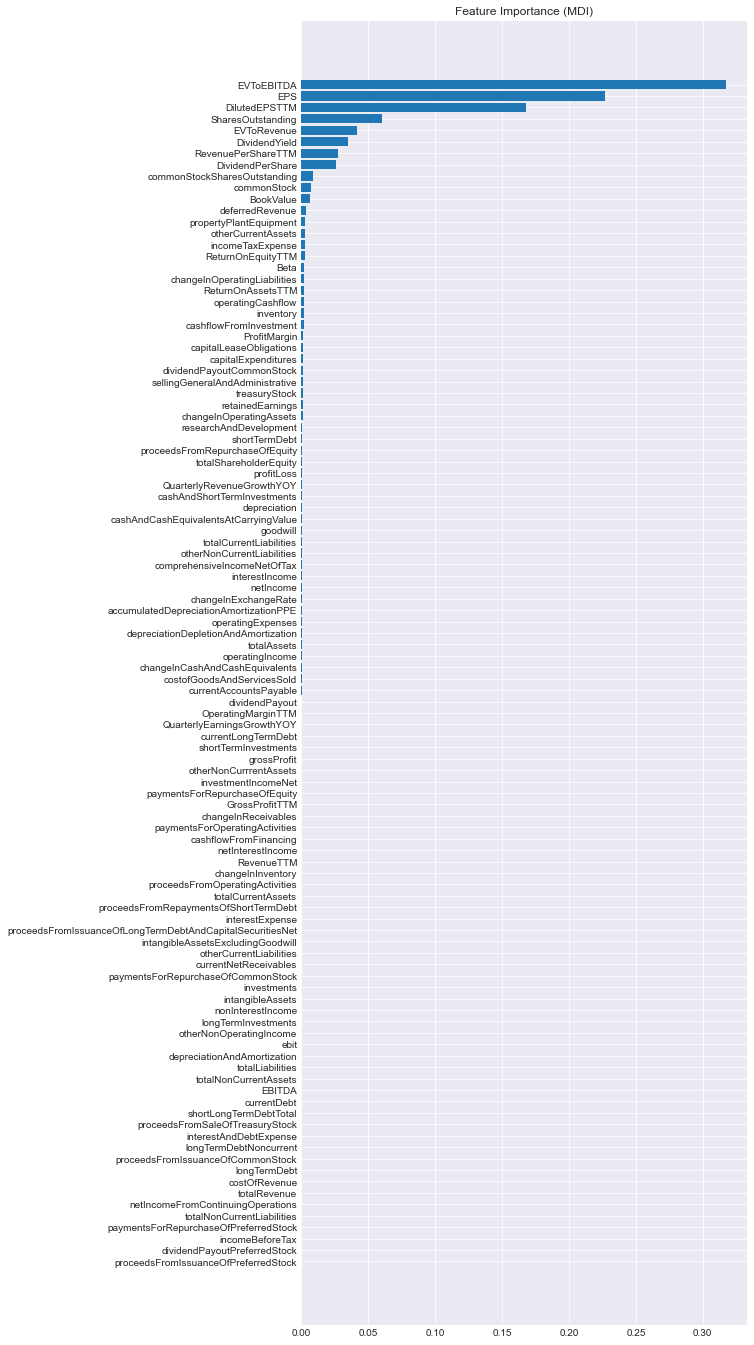

In [46]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 24))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

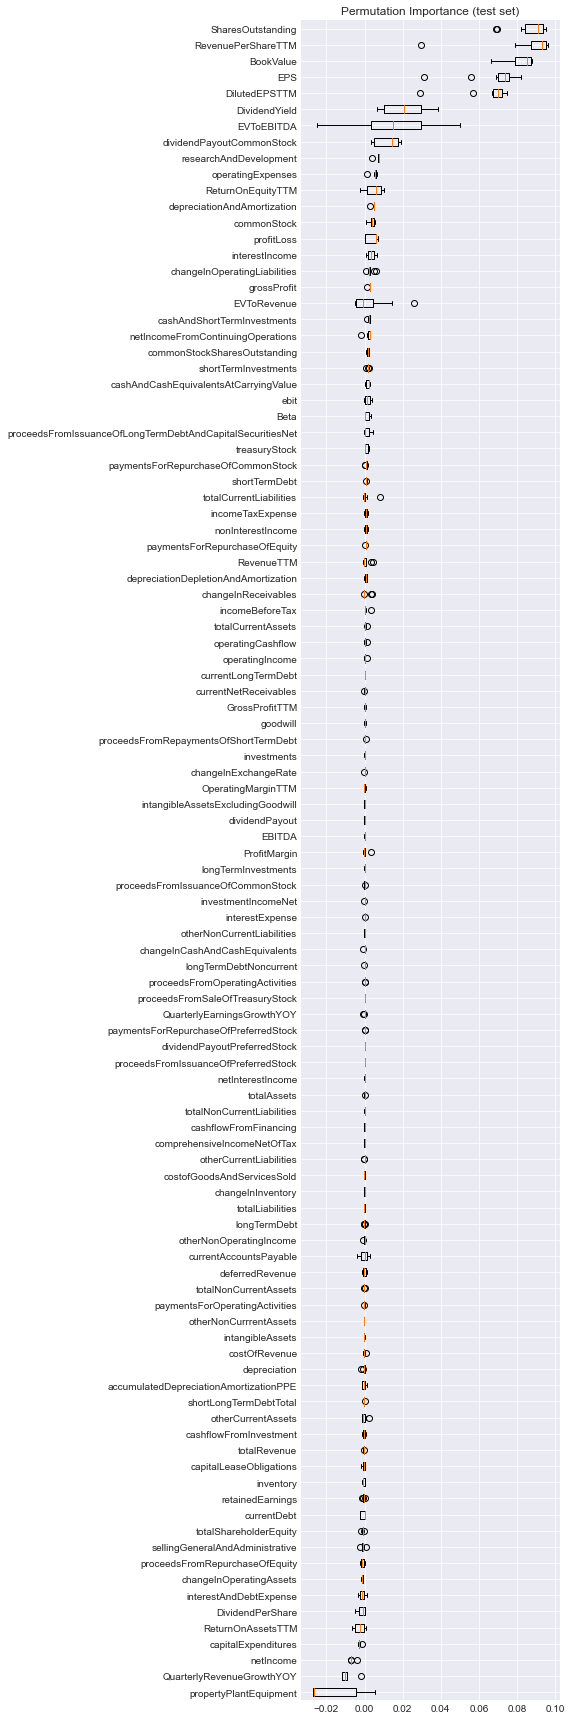

In [47]:
result = permutation_importance(est2, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig = plt.figure(figsize=(8,24))
plt.subplot(1, 1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

---
## Exploratory Data Analysis
We have successfully extracted the Top 7 Most Important Features from our Machine Learning Algorithm above. (We can do a correlation matrix between these 7 factors with `stockPrice`. Next, we will conduct a deeper analysis of the features.

The Top 7 Features to predict a Stock's Price after the release of the Annual Report are:
1. __EPS__ - Earnings per share (EPS) is calculated as a company's profit divided by the outstanding shares of its common stock. The resulting number serves as an indicator of a company's profitability.


2. __EVToEBITDA__ - The EV/EBITDA ratio is a popular metric used as a valuation tool to compare the value of a company, debt included, to the company’s cash earnings less non-cash expenses.


3. __EVToRevenue__ - The enterprise value-to-revenue multiple (EV/R) is a measure of the value of a stock that compares a company's enterprise value to its revenue


4. __DividendYield__ - Dividend yield is the amount of money a company pays shareholders for owning a share of its stock divided by its current stock price.


5. __RevenuePerShareTTM__ - Revenue Per Share Trailing Twelve Months (TTM_ is the financial ratio that measures the total revenue earned per share over a specific time period.


6. __SharesOutstanding__ - Shares outstanding refer to a company's stock currently held by all its shareholders, including share blocks held by institutional investors and restricted shares owned by the company’s officers and insiders.


7. __Book Value__ - Book value is equal to the cost of carrying an asset on a company's balance sheet, and firms calculate it netting the asset against its accumulated depreciation.

(We have excluded DividendPerShare as we have already included DividendYield.)



In [48]:
# Extract the Response and Predictors
y = pd.DataFrame(df['stockPrice'])
X = pd.DataFrame(df.drop(columns=['stockPrice', '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage']))


In [49]:
predictors = ['EPS', 'EVToEBITDA', 'EVToRevenue', 'DividendYield', 'RevenuePerShareTTM', 'SharesOutstanding', 'BookValue']
new_X = pd.DataFrame(df[predictors])
new_y = pd.DataFrame(df['stockPrice'])
new_X.tail(n=10)


EPS  EVToEBITDA  EVToRevenue  DividendYield  RevenuePerShareTTM  \
489  28.360        4.99        0.681         0.0353              354.03   
490   1.240       11.36        5.370         0.0567                8.87   
491   0.000        0.00        0.000         0.0000                0.00   
492  -6.640       65.03        5.360         0.0000               33.08   
493   3.721       37.83       12.570         0.0076               14.93   
494   2.350       20.97        3.358         0.0137               28.83   
495   5.210       19.78        7.160         0.0188               22.17   
496  15.520       19.93        4.109         0.0000              105.28   
497   1.905       18.81        4.067         0.0078               37.57   
498   6.790        0.00        0.000         0.0227               19.93   

     SharesOutstanding  BookValue  
489       5.861100e+07     82.140  
490       1.215000e+09      9.370  
491       0.000000e+00      0.000  
492       1.156580e+08      0.895  
493       2.483820e+08     14.800  
494       1.804000e+08     17.840  
495       2.889810e+08    -26.300  
496       5.308000e+07     55.860  
497       2.089080e+08     60.630  
498       1.516250e+08     46.320

In [50]:
# Let's check if there are any NaN values in the dataset
for col in new_X:
    if new_X[col].isna().sum() > 0:
        print(col)

In [51]:
new_X.describe()

EPS  EVToEBITDA  EVToRevenue  DividendYield  \
count    499.000000  499.000000   499.000000     499.000000   
mean    -191.943639   19.681377     5.166729       0.017165   
std     4477.035318   32.156460     6.861044       0.015138   
min   -99999.990000    0.000000     0.000000       0.000000   
25%        2.528500    9.240000     1.723500       0.003550   
50%        4.944000   14.400000     3.542000       0.015300   
75%        8.540000   21.145000     5.970000       0.026800   
max      320.480000  474.890000   113.510000       0.104000   

       RevenuePerShareTTM  SharesOutstanding   BookValue  
count          499.000000       4.990000e+02  499.000000  
mean            74.551739       6.082723e+08   39.083633  
std            167.586166       1.142299e+09   60.800451  
min              0.000000       0.000000e+00  -71.780000  
25%             19.700000       1.514780e+08   13.160000  
50%             33.630000       2.897600e+08   25.200000  
75%             68.435000       6.060720e+08   46.080000  
max           2503.860000       1.631940e+10  870.900000

In [52]:
new_y.describe()

stockPrice
count   499.000000
mean    215.136701
std     411.515587
min      11.829292
25%      63.465721
50%     118.330002
75%     229.009766
max    5959.330078

In [53]:
# Lets check out the wonky EPS value
new_X.loc[new_X['EPS'] == -99999.990000]

EPS  EVToEBITDA  EVToRevenue  DividendYield  RevenuePerShareTTM  \
248 -99999.99       25.01         3.86         0.0237               47.97   

     SharesOutstanding  BookValue  
248        254547000.0      82.82

In [54]:
new_X = new_X.drop(index = 248)
new_y = new_y.drop(index = 248)

In [55]:
new_X.describe()

EPS  EVToEBITDA  EVToRevenue  DividendYield  RevenuePerShareTTM  \
count  498.000000  498.000000   498.000000     498.000000          498.000000   
mean     8.474124   19.670677     5.169353       0.017152           74.605116   
std     19.319640   32.187905     6.867692       0.015151          167.750433   
min    -20.890000    0.000000     0.000000       0.000000            0.000000   
25%      2.531750    9.240000     1.721250       0.003475           19.660000   
50%      4.947000   14.385000     3.541000       0.015300           33.555000   
75%      8.555000   21.090000     5.970000       0.026800           68.837500   
max    320.480000  474.890000   113.510000       0.104000         2503.860000   

       SharesOutstanding   BookValue  
count       4.980000e+02  498.000000  
mean        6.089826e+08   38.995809  
std         1.143337e+09   60.829897  
min         0.000000e+00  -71.780000  
25%         1.514045e+08   13.130000  
50%         2.900630e+08   25.170000  
75%         6.075045e+08   46.000000  
max         1.631940e+10  870.900000

This looks way better.

# Split up the data

In [56]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size = 0.30, random_state=42)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (348, 1) (348, 7)
Test Set  : (150, 1) (150, 7)


In [57]:
X_train.describe()

EPS  EVToEBITDA  EVToRevenue  DividendYield  RevenuePerShareTTM  \
count  348.000000  348.000000   348.000000     348.000000          348.000000   
mean     8.340506   19.528911     5.264437       0.016566           70.408977   
std     20.466305   34.504808     7.530316       0.015213          168.201304   
min    -20.890000    0.000000     0.000000       0.000000            0.000000   
25%      2.553000    9.360000     1.773750       0.001575           18.992500   
50%      4.992500   14.455000     3.516000       0.015000           33.135000   
75%      8.577500   21.305000     5.992500       0.026125           65.392500   
max    320.480000  474.890000   113.510000       0.104000         2503.860000   

       SharesOutstanding   BookValue  
count       3.480000e+02  348.000000  
mean        6.125760e+08   38.304747  
std         9.938096e+08   61.945369  
min         0.000000e+00  -71.780000  
25%         1.567755e+08   13.472500  
50%         2.968550e+08   24.725000  
75%         6.046395e+08   45.192500  
max         8.069800e+09  870.900000

In [58]:
y_train.describe()

stockPrice
count   348.000000
mean    205.801269
std     419.922408
min      11.829292
25%      64.562450
50%     113.459858
75%     224.190773
max    5959.330078

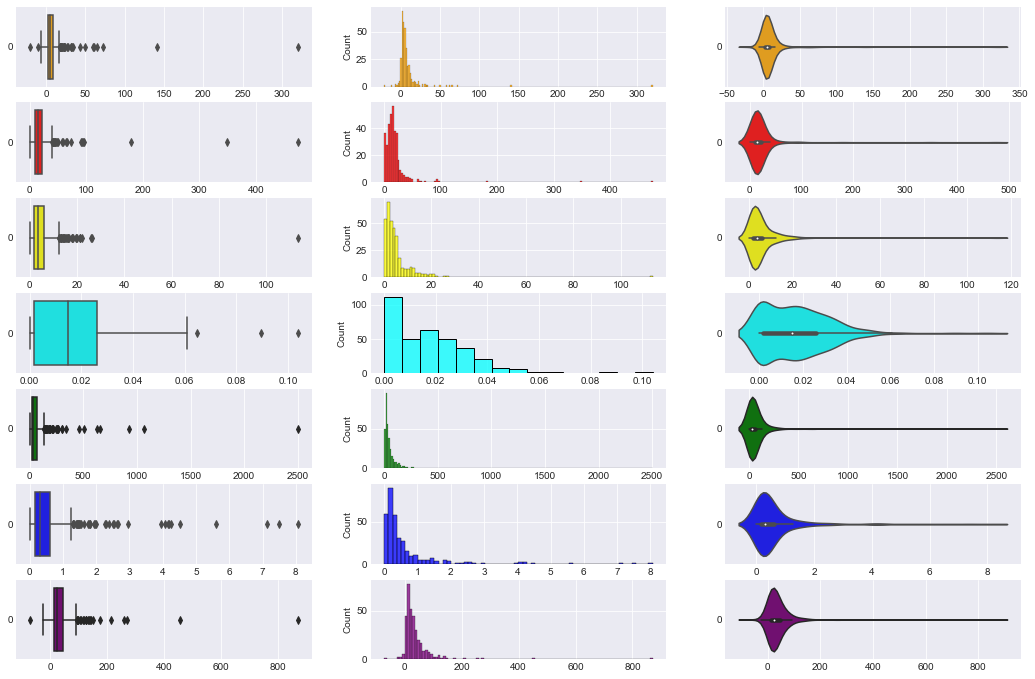

In [59]:
# Draw the distributions of all Predictors
f, axes = plt.subplots(7, 3, figsize=(18, 12))
colors = ['orange', 'red', 'yellow', 'cyan', 'green', 'blue', 'purple']
count = 0
for var in X_train:
    sns.boxplot(data = X_train[var].values, orient = "h", ax = axes[count,0], color=colors[count])
    sns.histplot(data = X_train[var].values, ax = axes[count,1], color=colors[count])
    sns.violinplot(data = X_train[var].values, orient = "h", ax = axes[count,2], color=colors[count])
    count += 1

<AxesSubplot:>

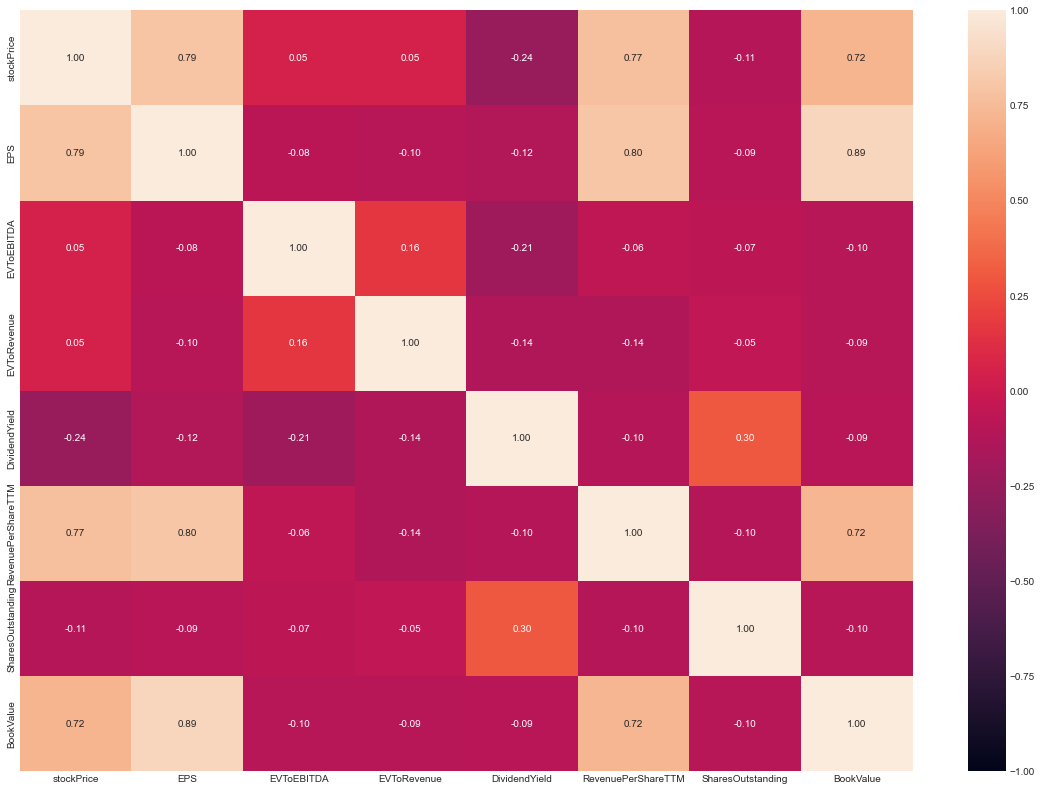

In [60]:
# Correlation between Response and the Predictors
trainDF = pd.concat([y_train, X_train], axis = 1).reindex(y_train.index)

f = plt.figure(figsize=(20, 14))
sns.heatmap(trainDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

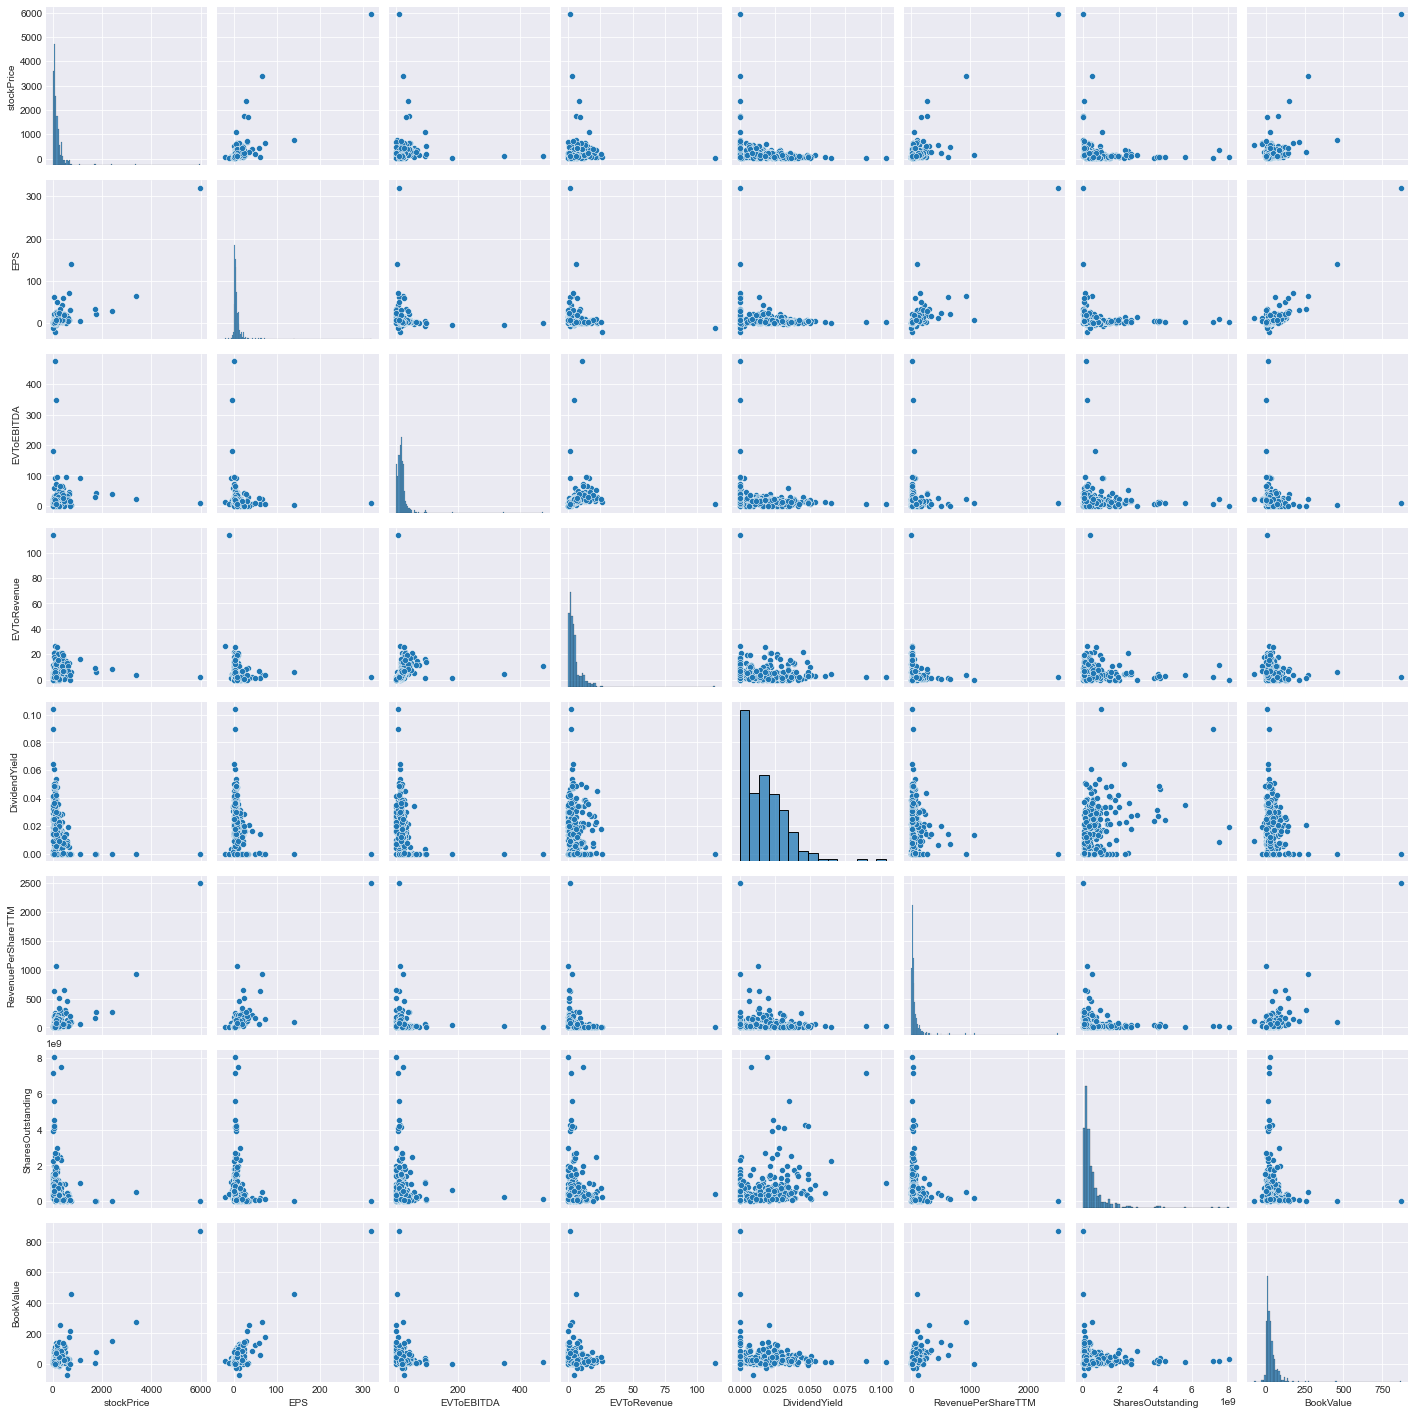

In [61]:
# Relationship between Response and the Predictors
sns.pairplot(data = trainDF)

### Scaling our Predictors before Linear Regression

In [62]:
# Normalize the df
x1 = X_train.values
x2 = X_test.values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x1)
X_test_scaled = scaler.fit_transform(x2)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [63]:
# Summary Statistics for Predictors
X_train_scaled.describe()

0             1             2             3             4  \
count  3.480000e+02  3.480000e+02  3.480000e+02  3.480000e+02  3.480000e+02   
mean   5.104474e-17 -3.062684e-17  4.976862e-17  1.122984e-16 -3.317908e-17   
std    1.001440e+00  1.001440e+00  1.001440e+00  1.001440e+00  1.001440e+00   
min   -1.430282e+00 -5.667914e-01 -7.001057e-01 -1.090487e+00 -4.192022e-01   
25%   -2.831893e-01 -2.951343e-01 -4.642187e-01 -9.868107e-01 -3.061243e-01   
50%   -1.638218e-01 -1.472611e-01 -2.325207e-01 -1.030903e-01 -2.219225e-01   
75%    1.159640e-02  5.154778e-02  9.682351e-02  6.292292e-01 -2.986719e-02   
max    1.527335e+01  1.321604e+01  1.439534e+01  5.755466e+00  1.448832e+01   

                  5             6  
count  3.480000e+02  3.480000e+02  
mean   4.594026e-17  4.083579e-17  
std    1.001440e+00  1.001440e+00  
min   -6.172793e-01 -1.779685e+00  
25%   -4.593001e-01 -4.014506e-01  
50%   -3.181451e-01 -2.195370e-01  
75%   -7.997445e-03  1.113509e-01  
max    7.514480e+00  1.346015e+01

---
## Multi-Variate Linear Regression
We have successfully extracted the Top 7 Most Important Features from our Machine Learning Algorithm above. Next, we will use Multi-Variate Linear Regression to predict the stock price of each stock on the day the report was generated. We will aim to see how good this prediction model is and will score it based on the R2 value.


In [64]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression


# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train_scaled, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Intercept of Regression 	: b =  [205.80126867]
Coefficients of Regression 	: a =  [[185.767508    31.93318658  52.82488828 -45.70090538 161.83037275
    7.45435591  23.06054816]]



Predictors  Coefficients
0                 EPS    185.767508
1          EVToEBITDA     31.933187
2         EVToRevenue     52.824888
3       DividendYield    -45.700905
4  RevenuePerShareTTM    161.830373
5   SharesOutstanding      7.454356
6           BookValue     23.060548

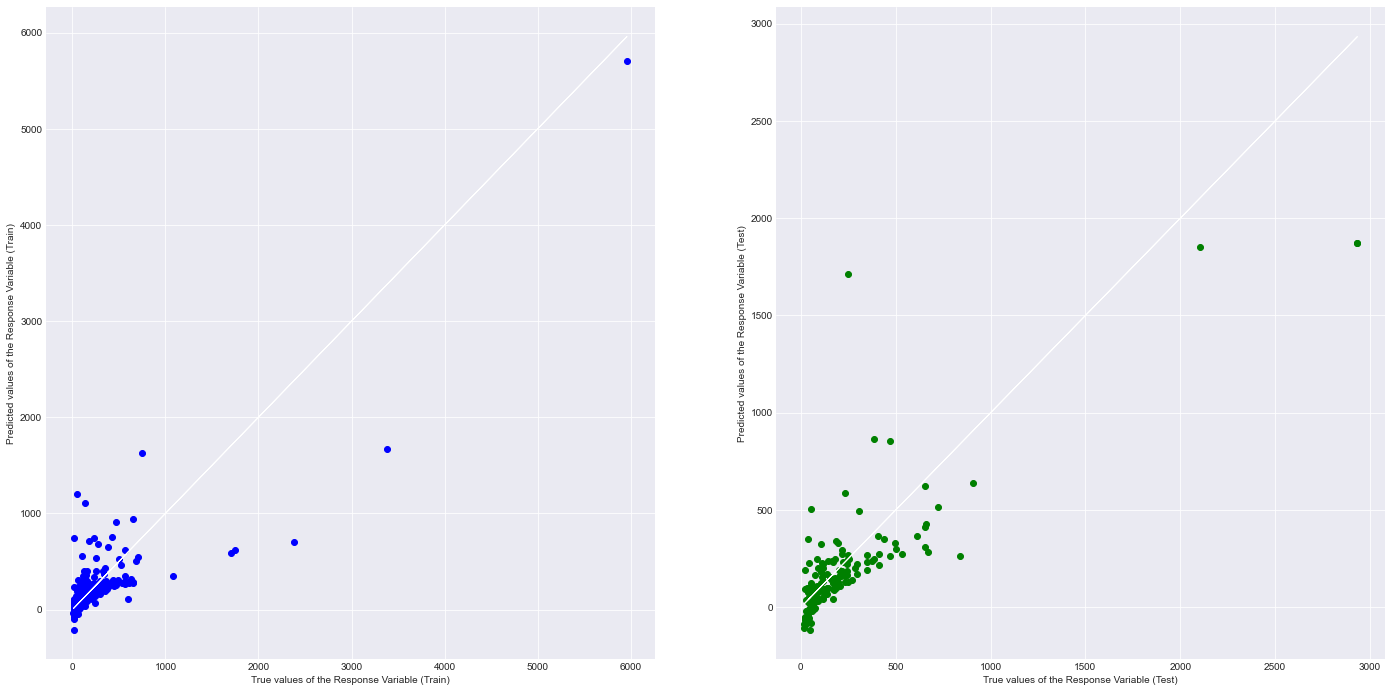

In [65]:
# Predict the Total values from Predictors
y_train_pred = linreg.predict(X_train_scaled)
y_test_pred = linreg.predict(X_test_scaled)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [66]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train_scaled, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test_scaled, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.722084965173913
Mean Squared Error (MSE) 	: 48865.27796439928

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.6891136142800629
Mean Squared Error (MSE) 	: 47747.38974109658



However, We still do not know if our feature selection was effective in picking out the best features to predict the price of a stock.

Let us do a conduct a test to validate our hypothesis. We will use 
* Ridge Regression
* Lasso Regression

We want to compare the $R^2$ and MSE of the above against that generated from the 2 other regression techniques for **ALL** variables without feature selection.


## Ridge Regression

The Ridge Regression Model is also considered as an exploratory method given that it is suited for the analysis of multicollinearity in multiple regression data just like the various financial predictors used to train our model.

Ridge Regression thus provides an extension to conventional regression by adding a regularization penalty to the loss function during training in an attempt to optimise the exploratory of model fit results.

We will use Ridge Regression with `alpha` = 0.05.

In [67]:
# Extract the Response and Predictors
y = pd.DataFrame(df['stockPrice']).values.ravel()
X = pd.DataFrame(df.drop(columns=['stockPrice', '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage']))

# Splitting the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

In [68]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(399, 104) (100, 104)
(399,) (100,)


In [69]:
# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import Ridge

# Ridge Regression using Train Data
ridgeReg = Ridge(alpha=0.05, normalize=True) # create the Ridge Regression Object
ridgeReg.fit(X_train, y_train)               # train the Ridge Regression Model

# Coefficients of the Ridge Regression line
print('Intercept of Regression \t: b = ', ridgeReg.intercept_)
print('Coefficients of Regression \t: a = ', ridgeReg.coef_)
print()

Intercept of Regression 	: b =  -20.906437286719893
Coefficients of Regression 	: a =  [ 7.74606735e-10 -3.30448529e-10 -6.35799976e-10  1.65443208e-09
 -9.26210573e-10  1.06019908e-09  8.48452143e-10 -1.20221370e-08
 -1.06532077e-08  2.58516594e-09 -1.64647518e-09 -1.22557643e-10
  4.32723164e-09 -1.56707861e-09 -2.88801837e-09  2.90845519e-08
  1.63453856e-09 -1.14207782e-08  2.56254495e-07 -5.44222916e-08
  4.35991213e-09 -2.88230890e-08  2.85132118e-09  4.49749938e-07
 -8.20392317e-10 -2.44919028e-07  2.96136496e-09  3.93915942e-11
  1.64010681e-10  4.70836410e-10  2.12570279e-10 -2.09188105e-09
 -4.99897922e-09  1.63911403e-10  3.77596304e-10 -1.58518287e-09
 -2.88763744e-10 -1.22447902e-09  4.08297408e-10  4.95040867e-12
 -2.23037665e-10 -4.88378837e-10 -7.41184439e-11 -6.33431133e-11
  3.60435876e-11  6.25351934e-10  3.31928912e-09  2.09377052e-10
 -1.22055422e-09 -1.53685118e-09  2.61297088e-12  4.61491414e-09
 -1.42629860e-10  2.77822143e-09  3.99533001e-10 -2.20374013e-10
  2

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


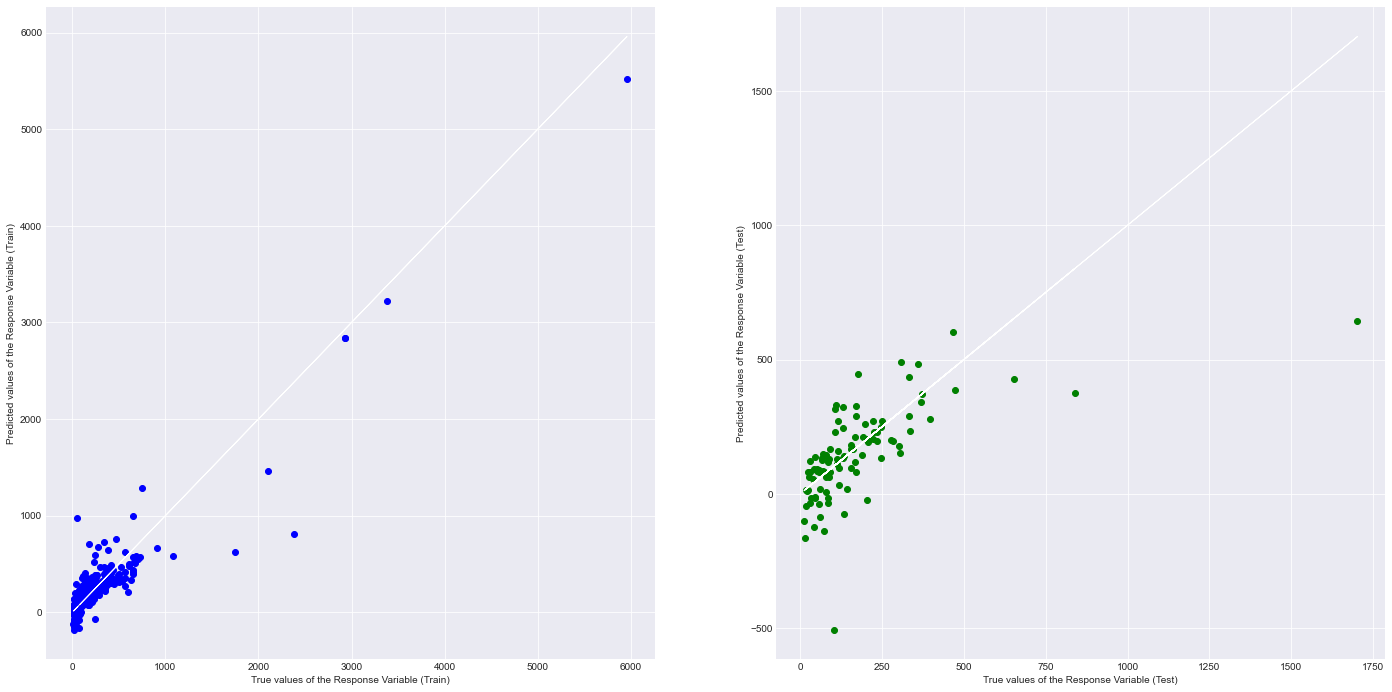

In [70]:
# Predict the Total values from Predictors
y_train_pred = ridgeReg.predict(X_train)
y_test_pred = ridgeReg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [71]:
# Import mean_squared_error from sklearn
from sklearn.metrics import mean_squared_error

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", ridgeReg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", ridgeReg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8752113920264987
Mean Squared Error (MSE) 	: 24988.16718382928

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.37468640691555977
Mean Squared Error (MSE) 	: 26321.046284791966



## Lasso Regression

The Lasso Regression Model is also another viable regression model to explore as it allows us to shrink or regularize coefficients to avoid overfitting.

Lasso Regression is also used when the dataset shows high multicollinearity just like the financial data and predictors used to train our model.

We will use Lasso Regression with `alpha` = 0.1.

In [72]:
from sklearn import linear_model

lassoReg = linear_model.Lasso(alpha=0.3, normalize = True)
lassoReg.fit(X_train, y_train)

# Coefficients of the Lasso Regression line
print('Intercept of Regression \t: b = ', lassoReg.intercept_)
print('Coefficients of Regression \t: a = ', lassoReg.coef_)
print()

Intercept of Regression 	: b =  16.94617201474327
Coefficients of Regression 	: a =  [ 0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.64210809e-09
 -0.00000000e+00  0.00000000e+00 -1.27738324e-09 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.00583396e-09 -4.42067355e-08
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.63640908e-07
 -0.00000000e+00 -1.19901281e-07  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -8.94449874e-10
 -0.00000000e+00 -0.00000000e+00  3.54114195e-10 -1.98884802e-10
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.33038423e-10 -1.40504698e-09 -0.00000000e+00  5.82267535e-09
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


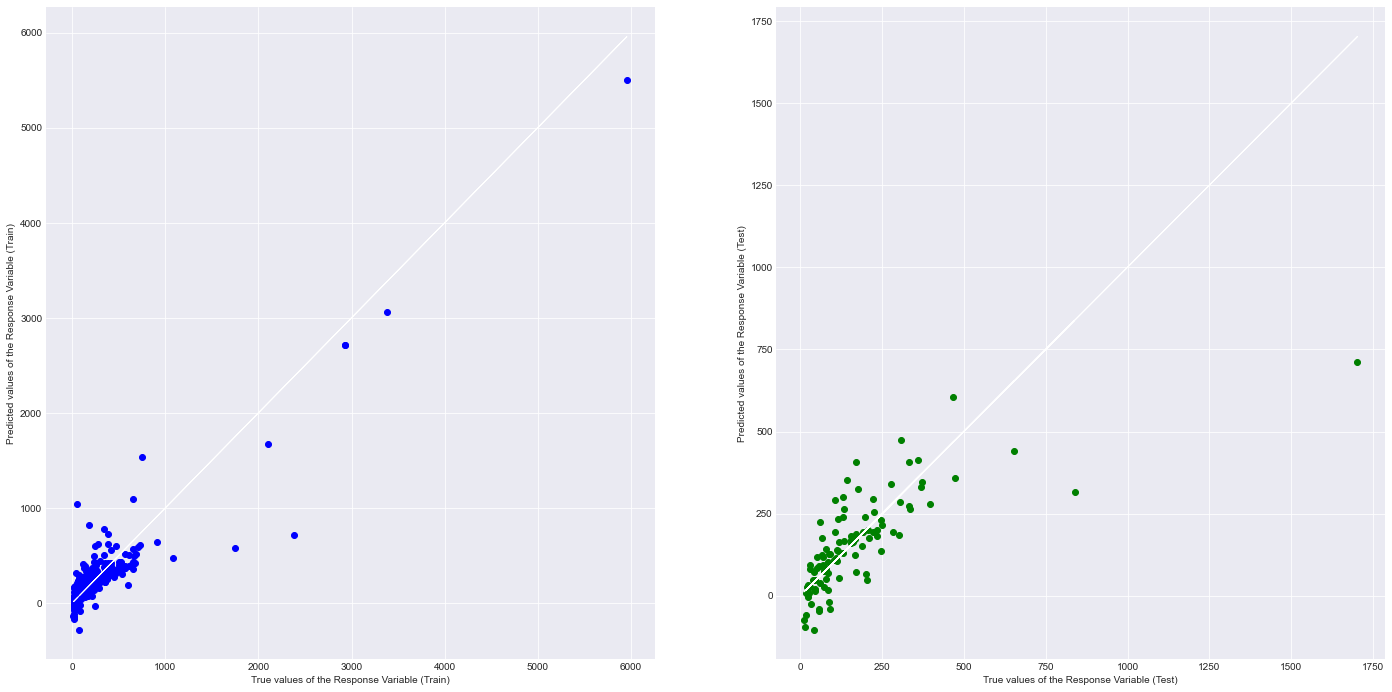

In [73]:
# Predict the Total values from Predictors
y_train_pred = lassoReg.predict(X_train)
y_test_pred = lassoReg.predict(X_test)

# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [74]:

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", lassoReg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", lassoReg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.8590015655264622
Mean Squared Error (MSE) 	: 28234.0873137324

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.543075415273671
Mean Squared Error (MSE) 	: 19233.12283028686



### Conclusion:

We can clearly see that Lasso and Ridge regression were able to perform better for the **Train** datasets. However, Lasso and Ridge unable to perform as well on the **Test** dataset as our Linear Regression on the selected features. This is observed by the highest scoring of both `Explained Variance` and `Mean Squared Error` for the Linear Regression model. This suggests that our feature selection has been effective in selecting the right factors to predict the price of the stock.

However,

## An Alternate Approach

In the first approach, we used `GradientBoostingRegressor` to rank the fundamental factors in terms of their feature and permuation importance to the stock price. We then picked the 7 most important features based on the results of the algorithm.

In this alternate approach, we will not be relying on the feature/permuation importance to select our fundamental factors. Instead, we will choose a set of representative financial indicators based on our own financial knowledge. We will be choosing the following factors, which are targetting at capturing a company's performance or ability from different dimensions.

1. __Debt to Equity ratio__ — leverage ratio of a company.


2. __Dividend Yield__ — amount of money a company pays shareholders for owning a share of its stock divided by its current stock price.


3. __Enterprise Value (EV) / EBITDA__ — a commonly used multiple to determine the value of a company.


4. __Net Debt To EBITDA ratio__ — indicates company’s ability to decrease its debt.


5. __Net Profit Margin__ — how much net income is generated as a percentage of revenue.


6. __Operating Profit Margin__ — how much profit a company makes on a dollar of sales, after paying for variable costs of production, such as wages and raw materials, but before paying interest or tax.


7. __Return on Assets__ — indicates how well a company utilizes its assets, by determining how profitable a company is relative to its total assets.

In [96]:
# Import the necessary libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

#### Importing our data

In [97]:
data_2017 = pd.read_csv('yoy5years/2017.csv',index_col=0)
data_2018 = pd.read_csv('yoy5years/2018.csv',index_col=0)
data_2019 = pd.read_csv('yoy5years/2019.csv',index_col=0)
data_2020 = pd.read_csv('yoy5years/2020.csv',index_col=0)
data_2021 = pd.read_csv('yoy5years/2021.csv',index_col=0)


In [98]:
data_2021.head()

fiscalDateEnding reportedCurrency  operatingCashflow  \
symbol                                                        
MMM          2021-12-31              USD         7454000000   
AOS          2021-12-31              USD          641100000   
ABT          2021-12-31              USD        10533000000   
ABBV         2021-12-31              USD        22777000000   
ABMD         2021-03-31              USD          274578000   

       paymentsForOperatingActivities proceedsFromOperatingActivities  \
symbol                                                                  
MMM                         791000000                            None   
AOS                              None                            None   
ABT                         831000000                            None   
ABBV                       6646000000                            None   
ABMD                         60793000                            None   

       changeInOperatingLiabilities changeInOperatingAssets  \
symbol                                                        
MMM                       274000000              1025000000   
AOS                       142900000               130100000   
ABT                       380000000              1151000000   
ABBV                     1628000000              1660000000   
ABMD                        7802000                10556000   

        depreciationDepletionAndAmortization capitalExpenditures  \
symbol                                                             
MMM                               1915000000          1603000000   
AOS                                 77900000            75100000   
ABT                               3538000000          1885000000   
ABBV                              8503000000           787000000   
ABMD                                25077000            53383000   

       changeInReceivables  ...   Beta 52WeekHigh  52WeekLow  \
symbol                      ...                                
MMM              122000000  ...  0.956     202.24     139.74   
AOS               25500000  ...  1.163      86.42      58.87   
ABT              383000000  ...  0.742     142.10     104.19   
ABBV            1321000000  ...  0.798     150.36      97.51   
ABMD              12059000  ...  1.359     379.30     261.27   

        50DayMovingAverage 200DayMovingAverage SharesOutstanding DividendDate  \
symbol                                                                          
MMM                 169.23              184.97      5.711000e+08   2022-03-12   
AOS                  78.31               73.04      1.314140e+08   2022-02-15   
ABT                 130.01              123.59      1.763480e+09   2022-05-16   
ABBV                137.55              120.24      1.768750e+09   2022-05-16   
ABMD                315.15              324.88      4.551620e+07         None   

       ExDividendDate currentPrice YOYPriceChange  
symbol                                             
MMM        2022-02-17       177.63       0.016248  
AOS        2022-01-28        85.85       0.566034  
ABT        2022-04-13       140.74       0.285414  
ABBV       2022-04-13       135.40       0.263649  
ABMD             None       318.73       1.195715  

[5 rows x 135 columns]

In [99]:
# Key financial indicators selected for experiment
predictors = ['ReturnOnAssetsTTM', 
              'OperatingMarginTTM', 
              'DividendYield', 
              'EVToEBITDA', 
              'ProfitMargin', 
              'shortLongTermDebtTotal', 
              'totalShareholderEquity',
              'EBITDA',
              'YOYPriceChange']

# Drop those stocks with NA values in selected financial indicators
data_2017_extracted = data_2017[predictors].dropna()
data_2018_extracted = data_2018[predictors].dropna()
data_2019_extracted = data_2019[predictors].dropna()
data_2020_extracted = data_2020[predictors].dropna()
data_2021_extracted = data_2021[predictors].dropna()

In [100]:
# Make sure consistency of the stocks group along different time window
indices_2017 = data_2017_extracted.index.tolist()
indices_2018 = data_2018_extracted.index.tolist()
indices_2019 = data_2019_extracted.index.tolist()
indices_2020 = data_2020_extracted.index.tolist()
indices_2021 = data_2021_extracted.index.tolist()

In [101]:
# Function to intersect lists
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [102]:
indices = intersection(indices_2017, indices_2018)
indices = intersection(indices, indices_2019)
indices = intersection(indices, indices_2020)
indices = intersection(indices, indices_2021)

In [103]:
data_2017_extracted = data_2017_extracted.loc[indices]
data_2018_extracted = data_2018_extracted.loc[indices]
data_2019_extracted = data_2019_extracted.loc[indices]
data_2020_extracted = data_2020_extracted.loc[indices]
data_2021_extracted = data_2021_extracted.loc[indices]

We have previously extracted the annualized volatility for each stock, let us put them into the respective dataframes.

In [104]:
df_vol_2017 = pd.read_csv('vol5years/df_vol_2017', usecols=[1,2], index_col=['ticker'])
df_vol_2018 = pd.read_csv('vol5years/df_vol_2018', usecols=[1,2], index_col=['ticker'])
df_vol_2019 = pd.read_csv('vol5years/df_vol_2019', usecols=[1,2], index_col=['ticker'])
df_vol_2020 = pd.read_csv('vol5years/df_vol_2020', usecols=[1,2], index_col=['ticker'])
df_vol_2021 = pd.read_csv('vol5years/df_vol_2021', usecols=[1,2], index_col=['ticker'])

In [105]:
# Next thing we need to do is to replace 'None' to 0 
# And also any other str to 0
# This is so that we can convert the object to float64

def cleanDf(df):
    for column in df:
        df[column] = df[column].replace(['None'], 0)
        df[column] = df[column].replace(['-'], 0)
        df[column] = df[column].replace(['NaN'], 0)
        df[column] = df[column].astype(float)
        df[column] = df[column].fillna(0)  

In [106]:
cleanDf(data_2017_extracted)
cleanDf(data_2018_extracted)
cleanDf(data_2019_extracted)
cleanDf(data_2020_extracted)
cleanDf(data_2021_extracted)

In [107]:
# Function to create DebtToEquityRatio and DebtToEBITDA columns 
def customizeDf(df):
    # Change all Dtypes to float64
    predictors = ['ReturnOnAssetsTTM', 
                  'OperatingMarginTTM', 
                  'DividendYield', 
                  'EVToEBITDA', 
                  'ProfitMargin', 
                  'shortLongTermDebtTotal', 
                  'totalShareholderEquity',
                  'EBITDA',
                  'YOYPriceChange']
    for i in predictors:
        df[i] = df[i].astype(float)
    
    # Add DebtToEquityRatio and DebtToEBITDA
    df['DebtToEquity'] = df['shortLongTermDebtTotal'] / df['totalShareholderEquity']
    df['DebtToEBITDA'] = df['shortLongTermDebtTotal'] / df['EBITDA']

In [108]:
data_2017_extracted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, GE to CDW
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ReturnOnAssetsTTM       452 non-null    float64
 1   OperatingMarginTTM      452 non-null    float64
 2   DividendYield           452 non-null    float64
 3   EVToEBITDA              452 non-null    float64
 4   ProfitMargin            452 non-null    float64
 5   shortLongTermDebtTotal  452 non-null    float64
 6   totalShareholderEquity  452 non-null    float64
 7   EBITDA                  452 non-null    float64
 8   YOYPriceChange          452 non-null    float64
dtypes: float64(9)
memory usage: 35.3+ KB


In [109]:
customizeDf(data_2017_extracted)
customizeDf(data_2018_extracted)
customizeDf(data_2019_extracted)
customizeDf(data_2020_extracted)
customizeDf(data_2021_extracted)

In [110]:
# Check for any NaN values
for col in data_2017_extracted:
    if data_2017_extracted[col].isna().sum() > 0:
        print(col)

DebtToEquity


Since `DebtToEquity` has NaN values after we created it, we will need to clean it again.

In [111]:
# Clean the 5 dataframes
cleanDf(data_2017_extracted)
cleanDf(data_2018_extracted)
cleanDf(data_2019_extracted)
cleanDf(data_2020_extracted)
cleanDf(data_2021_extracted)

In [112]:
# Check AGAIN for any NaN values
for col in data_2017_extracted:
    if data_2017_extracted[col].isna().sum() > 0:
        print(col)

In [113]:
# Drop the 3 columns which we used to calculate DebtToEquityRatio and DebtToEBITDA
to_drop = ['shortLongTermDebtTotal', 'totalShareholderEquity', 'EBITDA']

data_2017_extracted = data_2017_extracted.drop(columns = to_drop)
data_2018_extracted = data_2018_extracted.drop(columns = to_drop)
data_2019_extracted = data_2019_extracted.drop(columns = to_drop)
data_2020_extracted = data_2020_extracted.drop(columns = to_drop)
data_2021_extracted = data_2021_extracted.drop(columns = to_drop)

We will need to now replace any inf or -inf values from the dataframes as these values will render our machine learning in the next steps to be highly inaccurate.

In [114]:
data_2017_extracted = data_2017_extracted.replace([np.inf, -np.inf], 0)
data_2018_extracted = data_2018_extracted.replace([np.inf, -np.inf], 0)
data_2019_extracted = data_2019_extracted.replace([np.inf, -np.inf], 0)
data_2020_extracted = data_2020_extracted.replace([np.inf, -np.inf], 0)
data_2021_extracted = data_2021_extracted.replace([np.inf, -np.inf], 0)

We will want to include each individual stock's annualized volatility into the columns.

In [115]:
# Function to add Volatility Column
def addVolCol(df_vol, extracted_df, vols):
    for i in df_vol.index:
        extracted_df.loc[extracted_df.index == i, ['Volatility']] = vols[i]

In [116]:
# Convert the respective dataframes in Pandas.Series for easier extraction
vols2017 = df_vol_2017['vol_2017']
vols2018 = df_vol_2018['vol_2018']
vols2019 = df_vol_2019['vol_2019']
vols2020 = df_vol_2020['vol_2020']
vols2021 = df_vol_2021['vol_2021']

addVolCol(df_vol_2017, data_2017_extracted, vols2017)
addVolCol(df_vol_2018, data_2018_extracted, vols2018)
addVolCol(df_vol_2019, data_2019_extracted, vols2019)
addVolCol(df_vol_2020, data_2020_extracted, vols2020)
addVolCol(df_vol_2021, data_2021_extracted, vols2021)

In [117]:
# Check AGAIN for any NaN values
for col in data_2017_extracted:
    if data_2017_extracted[col].isna().sum() > 0:
        print(col)

In [118]:
# Clean the 5 dataframes
cleanDf(data_2017_extracted)
cleanDf(data_2018_extracted)
cleanDf(data_2019_extracted)
cleanDf(data_2020_extracted)
cleanDf(data_2021_extracted)

In [119]:
data_2017_extracted

ReturnOnAssetsTTM  OperatingMarginTTM  DividendYield  EVToEBITDA  \
symbol                                                                     
GE                 0.0810              0.1930         0.0000       66.35   
TYL                0.0714              0.1210         0.0000       91.10   
IBM                0.0253              0.0812         0.0295        5.18   
FRT                0.0275              0.2110         0.0320       13.91   
KMI                0.1220              0.2390         0.0117       20.49   
...                   ...                 ...            ...         ...   
MA                 0.0962              0.1170         0.0288       11.95   
HUM                0.0135              0.1780         0.0388       24.03   
RCL                0.1110              0.2280         0.0205        6.15   
VFC                0.0142              0.4340         0.0333        0.00   
CDW                0.0642              0.1620         0.0240       11.90   

        ProfitMargin  YOYPriceChange  DebtToEquity  DebtToEBITDA  Volatility  
symbol                                                                        
GE            0.1820        0.014446      0.000000      0.000000   19.826615  
TYL           0.1020        0.240107      2.084442      0.946350   20.156920  
IBM           0.1230        0.002407     -0.000426     -0.002060   15.846710  
FRT           0.1240       -0.065442      1.111783      3.875055   17.167542  
KMI           0.1850        0.023504      0.045467      0.099995   17.801403  
...              ...             ...           ...           ...         ...  
MA            0.0942        0.465956    -20.882870      1.583019   14.046465  
HUM           0.2670        0.215851      1.468835      7.767077   18.584311  
RCL           0.1850       -0.189408      0.806828      1.304226   22.043340  
VFC           0.3350        0.387066      0.997349      0.000000   19.122974  
CDW           0.1270        0.334037      1.834157      2.395314   19.225397  

[452 rows x 9 columns]

In [120]:
# Remove all other columns except the 7 financial indicators
to_drop = ['YOYPriceChange', 'Volatility']
data_2017_extracted_std = data_2017_extracted
data_2018_extracted_std = data_2018_extracted
data_2019_extracted_std = data_2019_extracted
data_2020_extracted_std = data_2020_extracted
data_2021_extracted_std = data_2021_extracted

data_2017_extracted_std = data_2017_extracted_std.drop(columns=to_drop)
data_2018_extracted_std = data_2018_extracted_std.drop(columns=to_drop)
data_2019_extracted_std = data_2019_extracted_std.drop(columns=to_drop)
data_2020_extracted_std = data_2020_extracted_std.drop(columns=to_drop)
data_2021_extracted_std = data_2021_extracted_std.drop(columns=to_drop)


In [121]:
data_2017_extracted_std

ReturnOnAssetsTTM  OperatingMarginTTM  DividendYield  EVToEBITDA  \
symbol                                                                     
GE                 0.0810              0.1930         0.0000       66.35   
TYL                0.0714              0.1210         0.0000       91.10   
IBM                0.0253              0.0812         0.0295        5.18   
FRT                0.0275              0.2110         0.0320       13.91   
KMI                0.1220              0.2390         0.0117       20.49   
...                   ...                 ...            ...         ...   
MA                 0.0962              0.1170         0.0288       11.95   
HUM                0.0135              0.1780         0.0388       24.03   
RCL                0.1110              0.2280         0.0205        6.15   
VFC                0.0142              0.4340         0.0333        0.00   
CDW                0.0642              0.1620         0.0240       11.90   

        ProfitMargin  DebtToEquity  DebtToEBITDA  
symbol                                            
GE            0.1820      0.000000      0.000000  
TYL           0.1020      2.084442      0.946350  
IBM           0.1230     -0.000426     -0.002060  
FRT           0.1240      1.111783      3.875055  
KMI           0.1850      0.045467      0.099995  
...              ...           ...           ...  
MA            0.0942    -20.882870      1.583019  
HUM           0.2670      1.468835      7.767077  
RCL           0.1850      0.806828      1.304226  
VFC           0.3350      0.997349      0.000000  
CDW           0.1270      1.834157      2.395314  

[452 rows x 7 columns]

In [122]:
# Standardize column values using StandardScaler()
scaler = StandardScaler()
data_2017_extracted_std = scaler.fit_transform(data_2017_extracted_std)
data_2018_extracted_std = scaler.fit_transform(data_2017_extracted_std)
data_2019_extracted_std = scaler.fit_transform(data_2017_extracted_std)
data_2020_extracted_std = scaler.fit_transform(data_2017_extracted_std)
data_2021_extracted_std = scaler.fit_transform(data_2017_extracted_std)

In [123]:
# DONT REPEAT
data_2017_extracted_std = pd.DataFrame(data_2017_extracted_std)
data_2018_extracted_std = pd.DataFrame(data_2018_extracted_std)
data_2019_extracted_std = pd.DataFrame(data_2019_extracted_std)
data_2020_extracted_std = pd.DataFrame(data_2020_extracted_std)
data_2021_extracted_std = pd.DataFrame(data_2021_extracted_std)

---
## 2017

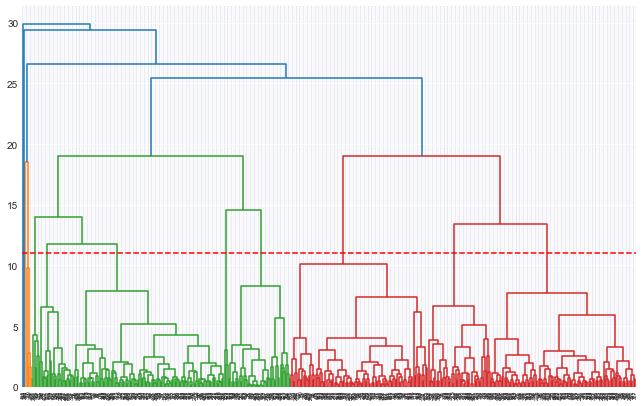

In [124]:
# Create dendrogram
dendrogram_2017 = sch.dendrogram(sch.linkage(data_2017_extracted_std, method='ward'))
plt.axhline(y=11, color='r', linestyle='--')

From the dendrogram, we see the line y=11 cuts through 11 clusters. As such, we will be using `n_clusters` = 11. Coincidentally, this agrees with the fact that there are 11 distinct sectors in the S&P 500.

In [125]:
# Create clusters
hc_2017 = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')

# Save clusters for chart
y_hc_2017 = hc_2017.fit_predict(data_2017_extracted_std)

# Choose the top 3 cluster with highest returns to price volatility ratio
data_2017_extracted['cluster_2017'] = pd.Series(y_hc_2017, index=data_2017_extracted.index)
data_2017_clustered_2017 = data_2017_extracted.groupby('cluster_2017').mean()
data_2017_clustered_2017['returnsTopricevol'] = data_2017_clustered_2017['YOYPriceChange'] / data_2017_clustered_2017['Volatility']

num_of_stocks_2017 = []
for n in range(len(set(y_hc_2017))):
    num_of_stocks_2017.append(data_2017_extracted['cluster_2017'][data_2017_extracted['cluster_2017'] == n].count())

    
# Creating new column with the respective values:
data_2017_clustered_2017['num_of_stocks'] = pd.Series(num_of_stocks_2017, index=data_2017_clustered_2017.index)

Next, we want to illustrate the characteristics of the clusters by plotting a line graph.

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

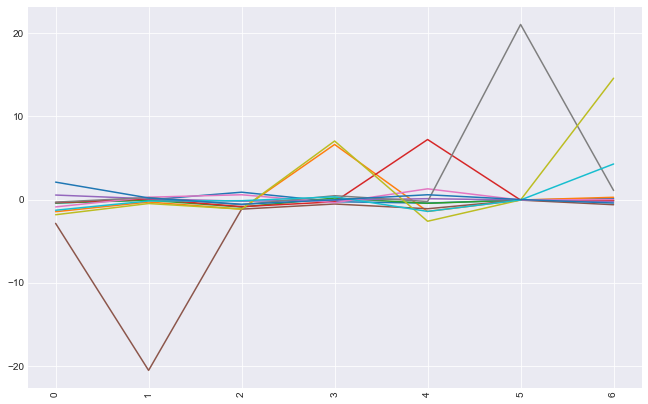

In [126]:
# Plot a line graph to see the characteristics of the clusters
data_2017_extracted_std['cluster_2017'] = pd.Series(y_hc_2017, index=data_2017_extracted_std.index)
data_2017_clustered_std = data_2017_extracted_std.groupby('cluster_2017').mean()
plt.plot(data_2017_clustered_std.T)
plt.xticks(rotation=90)

In [127]:
# Visualising Clusters
from sklearn.decomposition import PCA #Principal Component Analysis


In [128]:
pca = PCA(n_components = 2)
pc2d = pd.DataFrame(pca.fit_transform(data_2017_extracted.drop(['cluster_2017'], axis=1)))

In [129]:
pc2d

0          1
0   -10.092565  47.128754
1    -7.933156  71.892472
2   -10.270284 -14.040311
3    -9.129781  -5.163798
4   -10.181547   1.283526
..         ...        ...
447 -31.127349  -7.174268
448  -8.740398   5.105282
449  -9.469323 -12.957195
450  -9.293714 -19.183752
451  -8.418632  -7.206045

[452 rows x 2 columns]

In [130]:
pc2d.describe()

0             1
count  4.520000e+02  4.520000e+02
mean  -2.012156e-15 -1.006078e-15
std    1.719712e+02  2.580865e+01
min   -3.112735e+01 -1.929350e+01
25%   -9.975677e+00 -9.662408e+00
50%   -9.565811e+00 -4.695870e+00
75%   -8.969053e+00  2.063911e+00
max    3.616066e+03  3.297369e+02

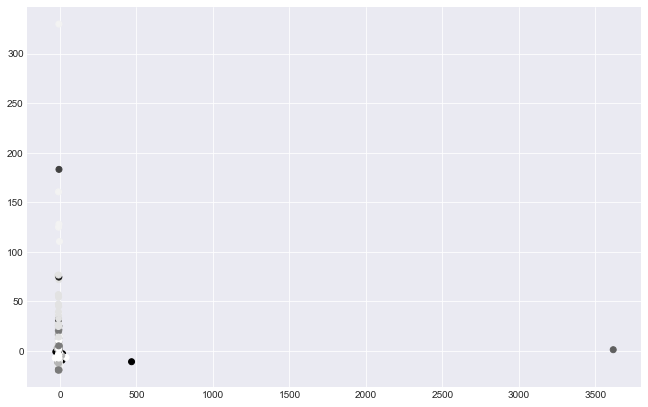

In [131]:

plt.scatter(pc2d[0], pc2d[1], c=hc_2017.labels_)

In [132]:
from scipy import stats
pc2d['clusters'] = hc_2017.labels_
newpc2d = pc2d[(np.abs(stats.zscore(pc2d)) < 1.5).all(axis=1)]



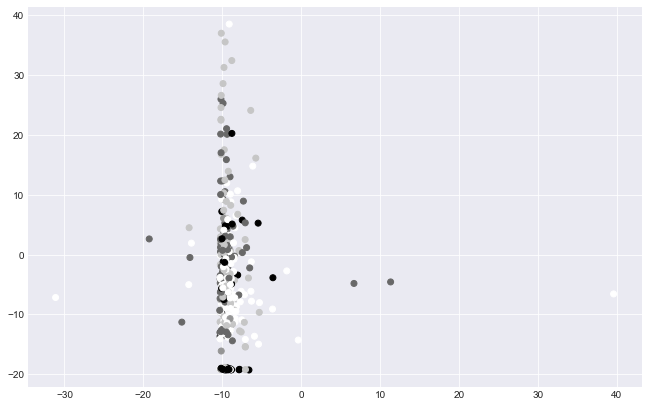

In [133]:
plt.scatter(newpc2d[0], newpc2d[1], c=newpc2d['clusters'])

After we have conduted our cluster analysis, a criteria is needed to help make what goes into a portfolio. We will be using YOYReturns-to-Volatility ratio to make this decision. 

As seen in the other notebook which was used to extract and calculate each individual stock's price volatility throughout the whole year, this ratio is very similar to the __Sharpe Ratio__, the ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.

In [134]:
# Match cluster formed in 2017 to 2018 data to see the performance
data_2018_extracted['cluster_2017'] = pd.Series(y_hc_2017, index=data_2018_extracted.index)
data_2018_clustered_2017 = data_2018_extracted.groupby('cluster_2017').mean()
data_2018_clustered_2017['returnsTopricevol'] = data_2018_clustered_2017['YOYPriceChange'] / data_2018_clustered_2017['Volatility']
data_2018_clustered_2017['num_of_stocks'] = pd.Series(num_of_stocks_2017, index=data_2018_clustered_2017.index)

Portfolio is constructed with equal weighted investments onto all stocks in these 3 clusters, and there are 10 stocks in total.

In [135]:
# Comparison with selection purely based on priceToVol ratio
data_2017_extracted['returnsTopricevol'] = data_2017_extracted['YOYPriceChange'] / data_2017_extracted['Volatility']
data_2017_extracted.sort_values("returnsTopricevol", inplace = True, ascending=False)

data_17_clustered_17 = data_2017_clustered_2017.loc[:, ['YOYPriceChange', 'Volatility', 'returnsTopricevol', 'num_of_stocks']]
data_17_clustered_17.sort_values("returnsTopricevol", inplace = True, ascending=False)

# Count the number of stocks in the top 3 clusters
num_2017_selected_stocks = data_17_clustered_17[:3]['num_of_stocks'].sum()

# Selected cluster's index
selected_cluster_2017_indices = data_17_clustered_17[:3].index


In [136]:
# Performance of the selected cluster in 2018
perform_18_cluster_17 = data_2018_clustered_2017.loc[selected_cluster_2017_indices]
returns_cluster_18_17 = perform_18_cluster_17['YOYPriceChange'].dot(perform_18_cluster_17['num_of_stocks']) / perform_18_cluster_17['num_of_stocks'].sum()

# Performance of the selected top stocks in 2018
top_17 = data_2017_extracted[:num_2017_selected_stocks].index
returns_top_18_17 = data_2018_extracted.loc[top_17]['YOYPriceChange'].mean()

# Performance comparison
print('2017: ', returns_cluster_18_17, ' vs ', returns_top_18_17)

2017:  0.08456987291666668  vs  0.07255595000000001


We will repeat the above analysis for 2018, 2019 and 2020 to get a more conclusive result.

___
## 2018

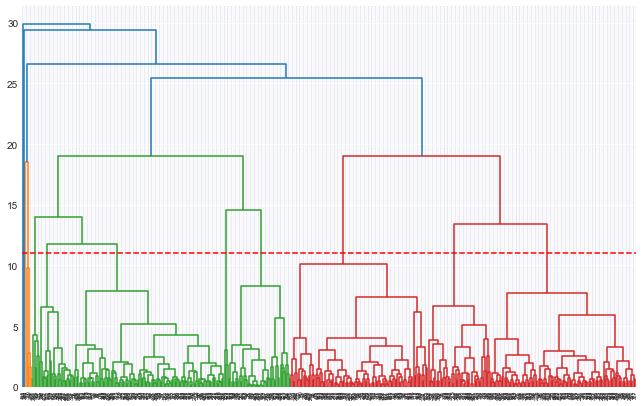

In [137]:
# Create dendrogram
dendrogram_2018 = sch.dendrogram(sch.linkage(data_2018_extracted_std, method='ward'))
plt.axhline(y=11, color='r', linestyle='--')

In [138]:
# Create clusters
hc_2018 = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')

# Save clusters for chart
y_hc_2018 = hc_2018.fit_predict(data_2018_extracted_std)

# Choose the top 3 cluster with highest returns to price volatility ratio
data_2018_extracted['cluster_2018'] = pd.Series(y_hc_2018, index=data_2018_extracted.index)
data_2018_clustered_2018 = data_2018_extracted.groupby('cluster_2018').mean()
data_2018_clustered_2018['returnsTopricevol'] = data_2018_clustered_2018['YOYPriceChange'] / data_2018_clustered_2018['Volatility']

# Calculate total number of stocks in Top 3 Clusters
num_of_stocks_2018 = []
for n in range(len(set(y_hc_2018))):
    num_of_stocks_2018.append(data_2018_extracted['cluster_2018'][data_2018_extracted['cluster_2018'] == n].count())

data_2018_clustered_2018['num_of_stocks'] = pd.Series(num_of_stocks_2018, index=data_2018_clustered_2018.index)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

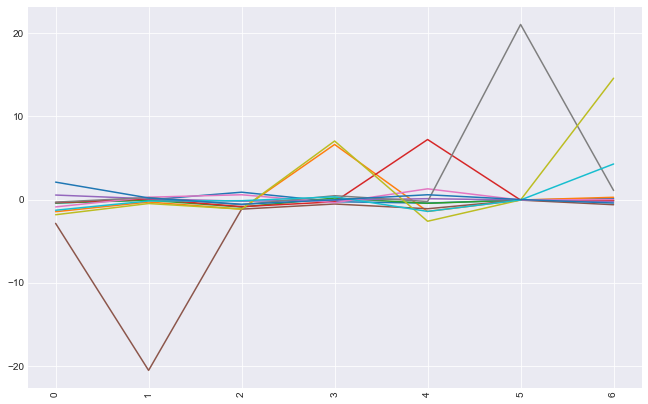

In [139]:
# Plot a line graph to see the characteristics of the clusters
data_2018_extracted_std['cluster_2018'] = pd.Series(y_hc_2018, index=data_2018_extracted_std.index)
data_2018_clustered_std = data_2018_extracted_std.groupby('cluster_2018').mean()

plt.plot(data_2018_clustered_std.T)
plt.xticks(rotation=90)

In [140]:
# Match cluster formed in 2017 to 2018 data to see the performance
data_2019_extracted['cluster_2018'] = pd.Series(y_hc_2018, index=data_2019_extracted.index)
data_2019_clustered_2018 = data_2019_extracted.groupby('cluster_2018').mean()
data_2019_clustered_2018['returnsTopricevol'] = data_2019_clustered_2018['YOYPriceChange'] / data_2019_clustered_2018['Volatility']
data_2019_clustered_2018['num_of_stocks'] = pd.Series(num_of_stocks_2018, index=data_2019_clustered_2018.index)

In [141]:
# Comparison
data_2018_extracted['returnsTopricevol'] = data_2018_extracted['YOYPriceChange'] / data_2018_extracted['Volatility']
data_2018_extracted.sort_values("returnsTopricevol", inplace = True, ascending=False)

data_18_clustered_18 = data_2018_clustered_2018.loc[:, ['YOYPriceChange', 'Volatility', 'returnsTopricevol', 'num_of_stocks']]
data_18_clustered_18.sort_values("returnsTopricevol", inplace = True, ascending=False)

num_2018_selected_stocks = data_18_clustered_18[:3]['num_of_stocks'].sum()

selected_cluster_2018_indices = data_18_clustered_18[:3].index

perform_19_cluster_18 = data_2019_clustered_2018.loc[selected_cluster_2018_indices]

returns_cluster_19_18 = perform_19_cluster_18['YOYPriceChange'].dot(perform_19_cluster_18['num_of_stocks']) / perform_19_cluster_18['num_of_stocks'].sum()
top_18 = data_2018_extracted[:num_2018_selected_stocks].index
returns_top_19_18 = data_2019_extracted.loc[top_18]['YOYPriceChange'].mean()

print('2018: ', returns_cluster_19_18, ' vs ', returns_top_19_18)

2018:  0.30560348  vs  0.14285586


---
## 2019

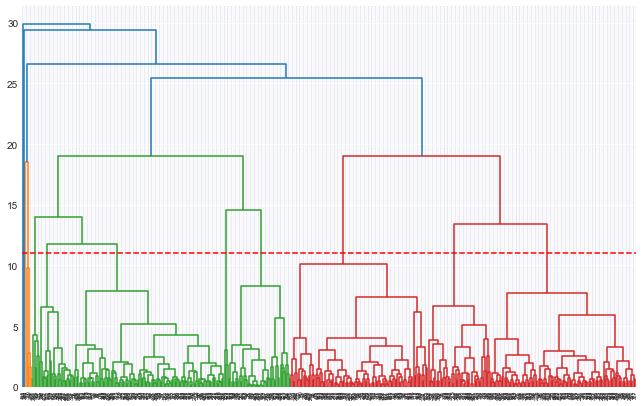

In [142]:
# Create dendrogram
dendrogram_2019 = sch.dendrogram(sch.linkage(data_2019_extracted_std, method='ward'))
plt.axhline(y=11, color='r', linestyle='--')

In [143]:
# Create clusters
hc_2019 = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')

# Save clusters for chart
y_hc_2019 = hc_2019.fit_predict(data_2019_extracted_std)

# Choose the top 3 cluster with highest returns to price volatility ratio
data_2019_extracted['cluster_2019'] = pd.Series(y_hc_2019, index=data_2019_extracted.index)
data_2019_clustered_2019 = data_2019_extracted.groupby('cluster_2019').mean()
data_2019_clustered_2019['returnsTopricevol'] = data_2019_clustered_2019['YOYPriceChange'] / data_2019_clustered_2019['Volatility']

In [144]:
# Calculate total number of stocks in Top 3 Clusters
num_of_stocks_2019 = []
for n in range(len(set(y_hc_2019))):
    num_of_stocks_2019.append(data_2019_extracted['cluster_2019'][data_2019_extracted['cluster_2019'] == n].count())

data_2019_clustered_2019['num_of_stocks'] = pd.Series(num_of_stocks_2019, index=data_2019_clustered_2019.index)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

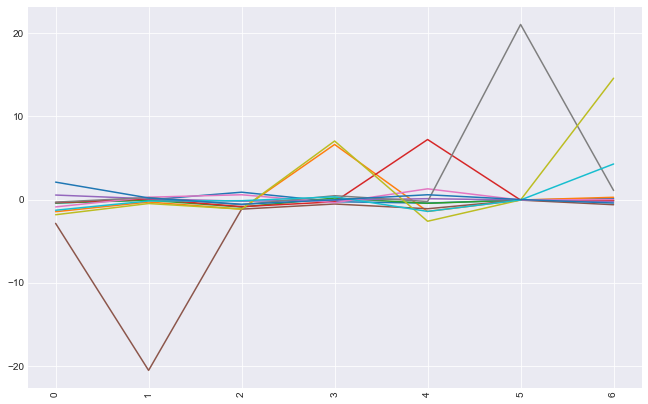

In [145]:
# Plot a line graph to see the characteristics of the clusters
data_2019_extracted_std['cluster_2019'] = pd.Series(y_hc_2019, index=data_2019_extracted_std.index)
data_2019_clustered_std = data_2019_extracted_std.groupby('cluster_2019').mean()

plt.plot(data_2019_clustered_std.T)
plt.xticks(rotation=90)

In [146]:
# Match cluster formed in 2019 to 2020 data to see the performance
data_2020_extracted['cluster_2019'] = pd.Series(y_hc_2019, index=data_2020_extracted.index)
data_2020_clustered_2019 = data_2020_extracted.groupby('cluster_2019').mean()
data_2020_clustered_2019['returnsTopricevol'] = data_2020_clustered_2019['YOYPriceChange'] / data_2020_clustered_2019['Volatility']
data_2020_clustered_2019['num_of_stocks'] = pd.Series(num_of_stocks_2019, index=data_2020_clustered_2019.index)

In [147]:
# Comparison
data_2019_extracted['returnsTopricevol'] = data_2019_extracted['YOYPriceChange'] / data_2019_extracted['Volatility']
data_2019_extracted.sort_values("returnsTopricevol", inplace = True, ascending=False)

data_19_clustered_19 = data_2019_clustered_2019.loc[:, ['YOYPriceChange', 'Volatility', 'returnsTopricevol', 'num_of_stocks']]
data_19_clustered_19.sort_values("returnsTopricevol", inplace = True, ascending=False)

num_2019_selected_stocks = data_19_clustered_19[:3]['num_of_stocks'].sum()

selected_cluster_2019_indices = data_19_clustered_19[:3].index

perform_20_cluster_19 = data_2020_clustered_2019.loc[selected_cluster_2019_indices]

returns_cluster_20_19 = perform_20_cluster_19['YOYPriceChange'].dot(perform_20_cluster_19['num_of_stocks']) / perform_20_cluster_19['num_of_stocks'].sum()
top_19 = data_2019_extracted[:num_2019_selected_stocks].index
returns_top_20_19 = data_2020_extracted.loc[top_19]['YOYPriceChange'].mean()

print('2019: ', returns_cluster_20_19, ' vs ', returns_top_20_19)

2019:  0.15609761111111112  vs  1.0735064333333333


---
## 2020

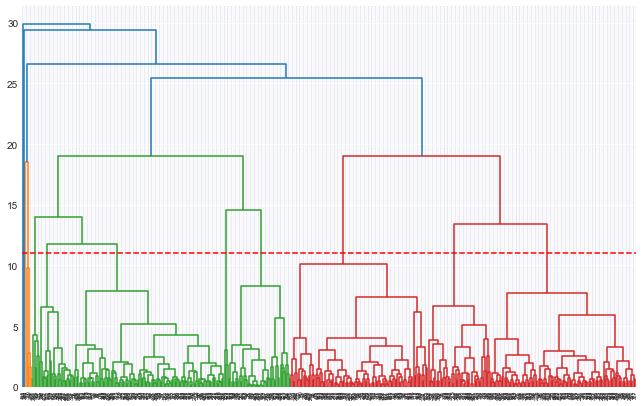

In [148]:
# Create dendrogram
dendrogram_2020 = sch.dendrogram(sch.linkage(data_2020_extracted_std, method='ward'))
plt.axhline(y=11, color='r', linestyle='--')

In [149]:
# Create clusters
hc_2020 = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')
# Save clusters for chart
y_hc_2020 = hc_2020.fit_predict(data_2019_extracted_std)

# Choose the top 3 cluster with highest returns to price volatility ratio
data_2020_extracted['cluster_2020'] = pd.Series(y_hc_2020, index=data_2020_extracted.index)
data_2020_clustered_2020 = data_2020_extracted.groupby('cluster_2020').mean()
data_2020_clustered_2020['returnsTopricevol'] = data_2020_clustered_2020['YOYPriceChange'] / data_2020_clustered_2020['Volatility']

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [150]:
# Calculate total number of stocks in Top 3 Clusters
num_of_stocks_2020 = []
for n in range(len(set(y_hc_2020))):
    num_of_stocks_2020.append(data_2020_extracted['cluster_2020'][data_2020_extracted['cluster_2020'] == n].count())

data_2020_clustered_2020['num_of_stocks'] = pd.Series(num_of_stocks_2020, index=data_2020_clustered_2020.index)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

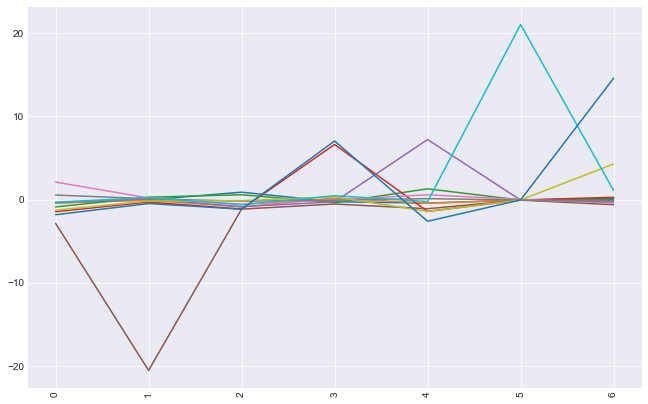

In [151]:
# Plot a line graph to see the characteristics of the clusters
data_2020_extracted_std['cluster_2020'] = pd.Series(y_hc_2020, index=data_2020_extracted_std.index)
data_2020_clustered_std = data_2020_extracted_std.groupby('cluster_2020').mean()

plt.plot(data_2020_clustered_std.T)
plt.xticks(rotation=90)

In [152]:
# Match cluster formed in 2020 to 2021 data to see the performance
data_2021_extracted['cluster_2020'] = pd.Series(y_hc_2020, index=data_2021_extracted.index)
data_2021_clustered_2020 = data_2021_extracted.groupby('cluster_2020').mean()
data_2021_clustered_2020['returnsTopricevol'] = data_2021_clustered_2020['YOYPriceChange'] / data_2021_clustered_2020['Volatility']
data_2021_clustered_2020['num_of_stocks'] = pd.Series(num_of_stocks_2020, index=data_2021_clustered_2020.index)

In [153]:
# Comparison
data_2020_extracted['returnsTopricevol'] = data_2020_extracted['YOYPriceChange'] / data_2020_extracted['Volatility']
data_2020_extracted.sort_values("returnsTopricevol", inplace = True, ascending=False)

data_20_clustered_20 = data_2020_clustered_2020.loc[:, ['YOYPriceChange', 'Volatility', 'returnsTopricevol', 'num_of_stocks']]
data_20_clustered_20.sort_values("returnsTopricevol", inplace = True, ascending=False)

num_2020_selected_stocks = data_20_clustered_20[:3]['num_of_stocks'].sum()

selected_cluster_2020_indices = data_20_clustered_20[:3].index

perform_21_cluster_20 = data_2021_clustered_2020.loc[selected_cluster_2020_indices]

returns_cluster_21_20 = perform_21_cluster_20['YOYPriceChange'].dot(perform_21_cluster_20['num_of_stocks']) / perform_21_cluster_20['num_of_stocks'].sum()
top_20 = data_2020_extracted[:num_2020_selected_stocks].index
returns_top_21_20 = data_2021_extracted.loc[top_20]['YOYPriceChange'].mean()

print('2020: ', returns_cluster_21_20, ' vs ', returns_top_21_20)



2020:  0.2516570711538462  vs  0.26901108846153843


In [154]:
overallResults = pd.DataFrame(columns=['Cluster', 'Top 10'], index=['2017', '2018', '2019', '2020'])

In [155]:
overallResults.loc['2017'] = [returns_cluster_18_17, returns_top_18_17]
overallResults.loc['2018'] = [returns_cluster_19_18, returns_top_19_18]
overallResults.loc['2019'] = [returns_cluster_20_19, returns_top_20_19]
overallResults.loc['2020'] = [returns_cluster_21_20, returns_top_21_20]

In [156]:
overallResults

Cluster    Top 10
2017   0.08457  0.072556
2018  0.305603  0.142856
2019  0.156098  1.073506
2020  0.251657  0.269011

## Possible reasons for better performance
It can’t be concluded that portfolio construction through cluster analysis of financial indicators would always give a superior performance. But it generated higher returns over stock selection in __2017__ and __2018__ and was not far behind in  __2020__ by only considering returns and risks. This shows that fundamental analysis really adds some value, and cluster analysis has helped to simplify the analysis process.


Below are some possible explanations for the better performance:
* Value of fundamental analysis —Financial indicators measure a company’s performance from different dimensions. So returns of a company with good financial performance should be more sustainable than returns “randomly generated”. This means that there is a need to reconsider each of the financial indicators periodically and update the portfolio allocation so as to maintain its sustainable performance. This will mean that a trader/portfolio manager will incur additional costs and if he does not change his portfolio periodically, its performance may detoriate in the future.


* Diversification benefits — Cluster analysis helps to distinguish stocks with different characteristics. In other words, the three clusters chosen should be quite different fundamentally. Such diversification prevents the portfolio suffering greatly as it limits our exposure to any specific types (sector/industry/country) of companies.


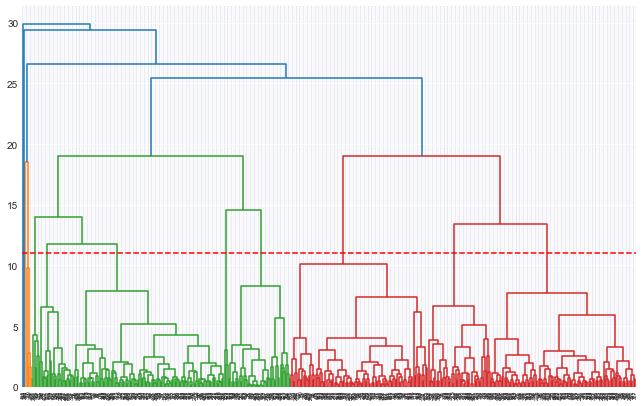

In [157]:
# Create dendrogram
dendrogram_2021 = sch.dendrogram(sch.linkage(data_2021_extracted_std, method='ward'))
plt.axhline(y=11, color='r', linestyle='--')

In [158]:
# Create clusters
hc_2021 = AgglomerativeClustering(n_clusters=11, affinity = 'euclidean', linkage = 'ward')
# Save clusters for chart
y_hc_2021 = hc_2021.fit_predict(data_2019_extracted_std)

# Choose the top 3 cluster with highest returns to price volatility ratio
data_2021_extracted['cluster_2021'] = pd.Series(y_hc_2021, index=data_2021_extracted.index)
data_2021_clustered_2021 = data_2021_extracted.groupby('cluster_2021').mean()
data_2021_clustered_2021['returnsTopricevol'] = data_2021_clustered_2021['YOYPriceChange'] / data_2021_clustered_2021['Volatility']

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [159]:
# Calculate total number of stocks in Top 3 Clusters
num_of_stocks_2021 = []
for n in range(len(set(y_hc_2021))):
    num_of_stocks_2021.append(data_2021_extracted['cluster_2021'][data_2021_extracted['cluster_2021'] == n].count())

data_2021_clustered_2021['num_of_stocks'] = pd.Series(num_of_stocks_2021, index=data_2021_clustered_2021.index)


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

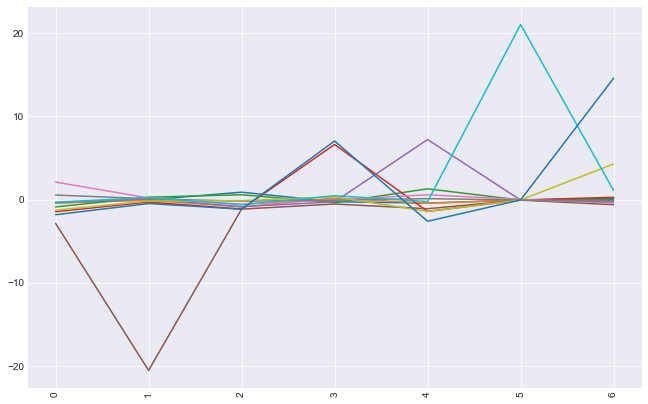

In [160]:
# Plot a line graph to see the characteristics of the clusters
data_2021_extracted_std['cluster_2021'] = pd.Series(y_hc_2021, index=data_2021_extracted_std.index)
data_2021_clustered_std = data_2021_extracted_std.groupby('cluster_2021').mean()

plt.plot(data_2021_clustered_std.T)
plt.xticks(rotation=90)

In [161]:
data_2021_extracted['returnsTopricevol'] = data_2021_extracted['YOYPriceChange'] / data_2021_extracted['Volatility']
data_2021_extracted.sort_values("returnsTopricevol", inplace = True, ascending=False)

data_21_clustered_21 = data_2021_clustered_2021.loc[:, ['YOYPriceChange', 'Volatility', 'returnsTopricevol', 'num_of_stocks']]
data_21_clustered_21.sort_values("returnsTopricevol", inplace = True, ascending=False)

In [162]:
# Top 3 Clusters
data_21_clustered_21.iloc[:3]

YOYPriceChange  Volatility  returnsTopricevol  num_of_stocks
cluster_2021                                                              
4                   0.552663   24.554832           0.022507              3
1                   0.386713   28.749255           0.013451            101
8                   0.342344   28.200339           0.012140              5

In [163]:
sym_7 = data_2021_extracted.loc[data_2021_extracted['cluster_2021'] == 4]
sym_0 = data_2021_extracted.loc[data_2021_extracted['cluster_2021'] == 2]
sym_2 = data_2021_extracted.loc[data_2021_extracted['cluster_2021'] == 8]

Below are the list of stocks to buy this year.

In [164]:
stocks_to_buy = list(sym_7.index) + list(sym_0.index) + list(sym_2.index)
stocks_to_buy

['UDR',
 'TECH',
 'ETR',
 'PLD',
 'REG',
 'CPRT',
 'STX',
 'FE',
 'BBWI',
 'J',
 'EW',
 'TTWO',
 'AVY',
 'VFC',
 'ORCL',
 'AFL',
 'EA',
 'COO',
 'ARE',
 'HIG',
 'BEN',
 'NSC',
 'RMD',
 'AWK',
 'LEN',
 'CB',
 'KMX',
 'EXPD',
 'LH',
 'TSLA',
 'VRSN',
 'BSX',
 'AMP',
 'HUM',
 'KO',
 'DLTR',
 'DD',
 'EXR',
 'CMS',
 'QCOM',
 'D',
 'K',
 'NWL',
 'HON',
 'CMCSA',
 'BA',
 'BK',
 'SRE',
 'LVS',
 'RL',
 'TEL',
 'GWW',
 'PEAK',
 'ALK']

### Limitations
As seen from the results produced in `stocks_to_buy` in 2022, the number of stocks that the retail investor needs to buy to be able to have a diversified portfolio may be unrealistic (109 stocks!). This will pose several limitations to the average retail investor.

1. Fees incurred from buying so many different stocks may be significant.
2. A large amount of money will be required to purchase just 1 of each stock generated from our model.

### Future work
To address the above problems, we can perhaps further the way we build the portfolio by either optimizing or adding a limit to how many stocks can be grouped into each cluster. Another possibility after will be to experiment with the weight of each stock in a portfolio based on other risks and factors. For example, we can conduct sentiment analysis on social media and new outlets or even conduct some form of macroeconomic analysis as an additional filter to our portfolio construction process.